# Overview
This python notebook processes data from estimation and control experiments to produce visualizations and plots used for the paper. 

In [2]:
## Imports
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
from scipy import signal
import dask.array as da
import cvxpy as cp
import psycopg2
import hdf5storage
import h5py
import pickle
import logging
from sys import getsizeof
from scipy import signal
import dask.array as da
from dask.distributed import Client, LocalCluster
import pandas as pd
from matplotlib.patches import ConnectionPatch
from matplotlib.gridspec import GridSpec
from PIL import Image


config = dotenv_values("../.env")


In [3]:
# Config parameter 
computeEstimationErrors= False


In [4]:
# # Setup Dask client
if computeEstimationErrors:
    client = Client('tcp://127.0.0.1:8786')
    client.cluster

In [5]:
# Dataset variables
TrainingDataSetFilepath = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/"
romDir = config["currentDirectory"] + "data/archivedDataSets/ContiguousAssembly/ROMsWithObserverGains/"
processedDataDir = config["currentDirectory"] + "data/processedData/"
visualizationDir = config["currentDirectory"] + "data/visualizations/"

# Estimation Experiments 

## Read in Data

In [6]:
####### # Set up hyperparameters for ROMs  #######
n_timesteps = 1000 # Number of timesteps to pull from each episode
dt = 0.01
ns_ROM = np.arange(2,22,2) # Dimensions of ROM state space

# Training Trials 
train_trials = [39, 16,35] #[0,1,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,22,23,24,26,27,28,29,30,31,32,33,35,36,37,39]
n_train = len(train_trials) # Number of training trials

# Testing Trials
test_trials = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38] #[2,9,10,17,21,25,34,38]
n_test = len(test_trials) # Number of testing trials

# Combined list of trials
trials = train_trials + test_trials
# totalTrials = 40
errors_filename = "relativeOutputEstimationErrors_" + str(n_timesteps) + "timesteps_" + str(dt) + "dt_" + str(trials) + "trials.csv"


In [7]:
if computeEstimationErrors:
    # Read in all data 
    data = h5py.File(TrainingDataSetFilepath+ "FreqSweepDataset.hdf5", 'r')
    X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
    X_fom = X_fom[:,:,0:]
    U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
    U_fom = U_fom[:,:,0:]
    Y_fom = da.from_array(data["outputData"], chunks=(4096, 4096,1))
    Y_fom = Y_fom[:,:,0:]
    x0 = data["stateData"][:,0,0]
    y0 = data["outputData"][:,0,0]
    n = X_fom.shape[0]
    l = U_fom.shape[0]
    m = Y_fom.shape[0]
    # # Collect initial condition offsets for each episode and center each episode
    X0 = X_fom[:,0,0]
    Y0 = Y_fom[:,0,0]
    # Center each episode about the initial condition

    X_fom = X_fom - X0[:,np.newaxis,np.newaxis]
    Y_fom = Y_fom - Y0[:,np.newaxis,np.newaxis]
    print("Done loading in data.")

## Calculate Estimation Errors Over All Trials for All Models

In [8]:
# Helper function that takes a model and returns the relative output estimation error and optionally the
# full order state reconstruction error in both the open and closed loop settings
def getError(A=0,B=0,C=0,D=0,L=0,basis=0, trialNumber=0, timesteps = 1000, OL=True, stateReconstruction=False):
    '''
    Function to compute the relative output estimation error and optionally the full order state reconstruction error
    in both the open and closed loop settings
    
    Parameters
    ----------
    A : np.ndarray
        State matrix of the reduced order model
    B : np.ndarray
        Input matrix of the reduced order model
    C : np.ndarray
        Output matrix of the reduced order model
    D : np.ndarray
        Feedthrough matrix of the reduced order model
    L : np.ndarray
        Observer gain matrix of the reduced order model
    basis : np.ndarray
        Basis matrix of the reduced order model
    trialNumber : int
        Trial number to compute the error for
    timesteps : int
        Number of timesteps to compute the error for
    OL : bool
        Whether to compute the open loop error or closed loop error. Default is True (open loop)
    stateReconstruction : bool
        Whether to compute the state reconstruction error. Default is False (do not compute state reconstruction error)
    Returns
    -------
    error: float
        Relative output estimation error
    stateError: float
        Full order state reconstruction error - only returned if stateReconstruction is True
    '''
    # Get the number of states, inputs, and outputs for ROM
    n_rom= A.shape[0]
    n_fom = X_fom.shape[0]
    l = B.shape[1]
    m = C.shape[0]
    # Initialize matrices to hold the state and output data
    x_rom_hat = np.zeros((n_rom,timesteps))
    yhat = np.zeros((m,timesteps))
    # Initialize matrix to hold the full order state data if state reconstruction is True
    if stateReconstruction:
        x_fom_hat = np.zeros((n_fom,timesteps))
    # Get input data for the trial
    u = U_fom[:,0:timesteps,trialNumber].compute()
    # # Get the initial condition for the trial
    # x0 = X_fom[:,0,trialNumber].compute()
    # y0 = Y_fom[:,0,trialNumber].compute()
    # Get true outputs
    y_true = Y_fom[:,0:timesteps,trialNumber].compute()
    # Get true full-order state data if state reconstruction is True
    if stateReconstruction:
        x_fom = X_fom[:,0:timesteps,trialNumber].compute()

    # Simulate the system using the reduced order model and conditional open/closed loop
    if OL: 
        for i in range(1,timesteps): 
            # Compute the state and output data using the reduced order model
            x_rom_hat[:,i] = A @ x_rom_hat[:,i-1] + B @ u[:,i-1]
            if np.ndim(D) != 0:
                yhat[:,i] = C @ x_rom_hat[:,i] + D @ u[:,i]
            else:
                yhat[:,i] = C @ x_rom_hat[:,i]
        if stateReconstruction:
            x_fom_hat = basis @ x_rom_hat
    else:
        for i in range(1,timesteps):
            # Compute the state and output data using the reduced order model
            x_rom_hat[:,i] = A @ x_rom_hat[:,i-1] + B @ u[:,i-1] - L @ (yhat[:, i-1] - y_true[:,i-1])
            if np.ndim(D) != 0:
                yhat[:,i] = C @ x_rom_hat[:,i] + D @ u[:,i]
            else:
                yhat[:,i] = C @ x_rom_hat[:,i]
        if stateReconstruction:
            x_fom_hat = basis @ x_rom_hat
            

    # Compute the relative output estimation error
    error = np.linalg.norm(yhat - y_true[:,0:timesteps], ord='fro') / np.linalg.norm(y_true[:,0:timesteps], ord='fro')
    # Compute the full order state reconstruction error if state reconstruction is True
    if stateReconstruction:
        stateError = np.linalg.norm(x_fom_hat - x_fom[:,0:timesteps], ord='fro') / np.linalg.norm(x_fom[:,0:timesteps], ord='fro')
        return error, stateError
    else:
        return error

In [9]:
if computeEstimationErrors:
    # Initiialize pandas dataframe to hold relative prediction errors for each ROM type and each trial 
    errors = pd.DataFrame(columns=["trial", "romDim", "numTraining", "romType", "OL", "trainingEp","outputError","fomStateError"])

In [10]:
# Helper function to add a new row to the dataframe
def errorDFAddRow(trial, romDim, numTraining, romType, OL, trainingEp, outputError, fomStateError):
    '''
    Function to add a new row to the errors dataframe
    
    Parameters
    ----------
    trial : int
        Trial number
    romDim : int
        Dimension of the reduced order model
    numTraining : int
        Number of training trials
    romType : str
        Type of reduced order model (e.g. "ERA", "DMD", "DMDc")
    OL : bool
        Whether the model is open loop or closed loop
    trainingEp : int
        Training episode number
    outputError : float
        Relative output estimation error
    fomStateError : float
        Full order state reconstruction error - only returned if stateReconstruction is True
    
    Returns
    -------
    None
    '''
    
    # Add a new row to the dataframe with the given parameters
    errors.loc[len(errors)] = [trial, romDim, numTraining, romType, OL, trainingEp, outputError, fomStateError]

In [11]:
if computeEstimationErrors:
    ##### Iterate over each trial, romType, and romDim computing the relative output estimation error and FOM state reconstruction error in open and closed loop contexts
    # ERA ROMs
    for romDim in ns_ROM:
        print("Starting with ROM dimension: " + str(romDim))
        # Load in the ROM matrices
        era_mats = scipy.io.loadmat(romDir + "eraSystemMatricesAndGains_" + str(romDim) + "dim_" + "1" + "train.mat")
        A_era = era_mats["A_era"]
        B_era = era_mats["B_era"]
        C_era = era_mats["C_era"]
        D_era = era_mats["D_era"]
        L_era = era_mats["L_era"]

        # Training trials
        for trial in train_trials:
            print("Starting with training trial: " + str(trial))
            # Get errors
            error_era = getError(A_era, B_era, C_era, D_era, L_era, basis=0, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=False)
            error_era_cl = getError(A_era, B_era, C_era, D_era, L_era, basis=0, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=False)
            # Append errors to dataframe
            errorDFAddRow(trial, romDim, 1, "ERA", True, True, error_era, 0)
            errorDFAddRow(trial, romDim, 1, "ERA", False, True, error_era_cl, 0)

        # Testing trials
        for trial in test_trials:
            print("Starting with testing trial: " + str(trial))
            # Get errors
            error_era = getError(A_era, B_era, C_era, D_era, L_era, basis=0, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=False)
            error_era_cl = getError(A_era, B_era, C_era, D_era, L_era, basis=0, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=False)
            # Append errors to dataframe
            errorDFAddRow(trial, romDim, 1, "ERA", True, False, error_era, 0)
            errorDFAddRow(trial, romDim, 1, "ERA", False, False, error_era_cl, 0)
    # DMDc ROMs
    for numTraining in [1, 2, 3]:
        for romDim in ns_ROM:
            print("Starting with ROM dimension: " + str(romDim) + " and number of training trials: " + str(numTraining))
            # Load in the ROM matrices
            dmdc_mats = scipy.io.loadmat(romDir + "dmdcSystemMatricesAndGains_" + str(romDim) + "dim_" + str(numTraining) + "train.mat")
            A_dmdc = dmdc_mats["A_dmdc"]
            B_dmdc = dmdc_mats["B_dmdc"]
            C_dmdc = dmdc_mats["C_dmdc"]
            D_dmdc = 0
            L_dmdc = dmdc_mats["L_dmdc"]
            basis_dmdc = dmdc_mats["basis_dmdc"]
            # Training trials
            for trial in train_trials:
                print("Starting with training trial: " + str(trial))
                # Get errors
                error_dmdc, fomError_dmdc = getError(A_dmdc, B_dmdc, C_dmdc, D_dmdc, L_dmdc, basis=basis_dmdc, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=True)
                error_dmdc_cl, fomError_dmdc_cl = getError(A_dmdc, B_dmdc, C_dmdc, D_dmdc, L_dmdc, basis=basis_dmdc, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=True)
                # Append errors to dataframe
                errorDFAddRow(trial, romDim, numTraining, "DMDc", True, True, error_dmdc, fomError_dmdc)
                errorDFAddRow(trial, romDim, numTraining, "DMDc", False, True, error_dmdc_cl, fomError_dmdc_cl)
            # Testing trials
            for trial in test_trials:
                print("Starting with testing trial: " + str(trial))
                # Get errors
                error_dmdc, fomError_dmdc = getError(A_dmdc, B_dmdc, C_dmdc, D_dmdc, L_dmdc, basis=basis_dmdc, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=True)
                error_dmdc_cl, fomError_dmdc_cl = getError(A_dmdc, B_dmdc, C_dmdc, D_dmdc, L_dmdc, basis=basis_dmdc, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=True)
                # Append errors to dataframe
                errorDFAddRow(trial, romDim, numTraining, "DMDc", True, False, error_dmdc, fomError_dmdc)
                errorDFAddRow(trial, romDim, numTraining, "DMDc", False, False, error_dmdc_cl, fomError_dmdc_cl)
    # lopinf ROMs
    for numTraining in [1, 2, 3]:
        for romDim in ns_ROM:
            print("Starting with ROM dimension: " + str(romDim) + " and number of training trials: " + str(numTraining))
            # Load in the ROM matrices
            lopinf_mats = scipy.io.loadmat(romDir + "lopinfSystemMatricesAndGains_" + str(romDim) + "dim_" + str(numTraining) + "train.mat")
            A_lopinf = lopinf_mats["A_lopinf"]
            B_lopinf = lopinf_mats["B_lopinf"]
            C_lopinf = lopinf_mats["C_lopinf"]
            D_lopinf = lopinf_mats["D_lopinf"]
            L_lopinf = lopinf_mats["L_lopinf"]
            basis_lopinf = lopinf_mats["basis_lopinf"]
            # Training trials
            for trial in train_trials:
                print("Starting with training trial: " + str(trial))
                # Get errors
                error_lopinf, fomError_lopinf = getError(A_lopinf, B_lopinf, C_lopinf, 0, L_lopinf, basis=basis_lopinf, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=True)
                error_lopinf_cl, fomError_lopinf_cl = getError(A_lopinf, B_lopinf, C_lopinf, 0, L_lopinf, basis=basis_lopinf, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=True)
                # Append errors to dataframe
                errorDFAddRow(trial, romDim, numTraining, "lopInf", True, True, error_lopinf, fomError_lopinf)
                errorDFAddRow(trial, romDim, numTraining, "lopInf", False, True, error_lopinf_cl, fomError_lopinf_cl)
            # Testing trials
            for trial in test_trials:
                print("Starting with testing trial: " + str(trial))
                # Get errors
                error_lopinf, fomError_lopinf = getError(A_lopinf, B_lopinf, C_lopinf, 0, L_lopinf, basis=basis_lopinf, trialNumber=trial, timesteps=n_timesteps, OL=True, stateReconstruction=True)
                error_lopinf_cl, fomError_lopinf_cl = getError(A_lopinf, B_lopinf, C_lopinf, 0, L_lopinf, basis=basis_lopinf, trialNumber=trial, timesteps=n_timesteps, OL=False, stateReconstruction=True)
                # Append errors to dataframe
                errorDFAddRow(trial, romDim, numTraining, "lopInf", True, False, error_lopinf, fomError_lopinf)
                errorDFAddRow(trial, romDim, numTraining, "lopInf", False, False, error_lopinf_cl, fomError_lopinf_cl)

In [12]:
if computeEstimationErrors:
    # Lists of trials for each frequency
    freqs= {
        "0.1": [0,5,10,15,20,25,30,35],
        "0.3": [1,6,11,16,21,26,31,36],
        "0.5": [2,7,12,17,22,27,32,37],
        "1.0": [3,8,13,18,23,28,33,38],
        "1.5": [4,9,14,19,24,29,34,39]
        }
    # add frequency to the errors dataframe as floats in a new column
    errors["frequency"] = 0.0
    for freq in freqs.keys():
        for trial in freqs[freq]:
            errors.loc[errors["trial"] == trial, "frequency"] = float(freq)


In [13]:
if computeEstimationErrors:
    # Display the errors dataframe
    # print(errors)
    # Save the errors dataframe to a csv file with the current date and time
    errors.to_csv(processedDataDir + errors_filename, index=False)

## Analyses

In [14]:
# Read in the errors dataframe from the csv file
errors = pd.read_csv(processedDataDir + errors_filename)

### Estimation Accuracy as Function of Dataset Size

In [15]:
# New dataframe to hold the mean and standard deviation of the errors as a function of the number of training trials
dataSizeErrors = errors.groupby(["romDim", "numTraining", "romType", "OL", "trainingEp"]).agg({"outputError": ["mean", "std"], "fomStateError": ["mean", "std"]}).reset_index()
# Rename the columns
dataSizeErrors.columns = ["romDim", "numTraining", "romType", "OL", "trainingEp", "outputError_mean", "outputError_std", "fomStateError_mean", "fomStateError_std"]

In [16]:
# Grab statistics for each ROM type and number of trainings trials separating by open and closed loop
# Open loop errors
era_OL = dataSizeErrors[(dataSizeErrors["romType"] == "ERA") & (dataSizeErrors["OL"] == True) & (dataSizeErrors["trainingEp"] == False)]
dmdc_OL = dataSizeErrors[(dataSizeErrors["romType"] == "DMDc") & (dataSizeErrors["OL"] == True) & (dataSizeErrors["trainingEp"] == False)]
lopinf_OL = dataSizeErrors[(dataSizeErrors["romType"] == "lopInf") & (dataSizeErrors["OL"] == True) & (dataSizeErrors["trainingEp"] == False)]
# Closed loop errors
era_CL = dataSizeErrors[(dataSizeErrors["romType"] == "ERA") & (dataSizeErrors["OL"] == False) & (dataSizeErrors["trainingEp"] == False)]
dmdc_CL = dataSizeErrors[(dataSizeErrors["romType"] == "DMDc") & (dataSizeErrors["OL"] == False) & (dataSizeErrors["trainingEp"] == False)]
lopinf_CL = dataSizeErrors[(dataSizeErrors["romType"] == "lopInf") & (dataSizeErrors["OL"] == False) & (dataSizeErrors["trainingEp"] == False)]


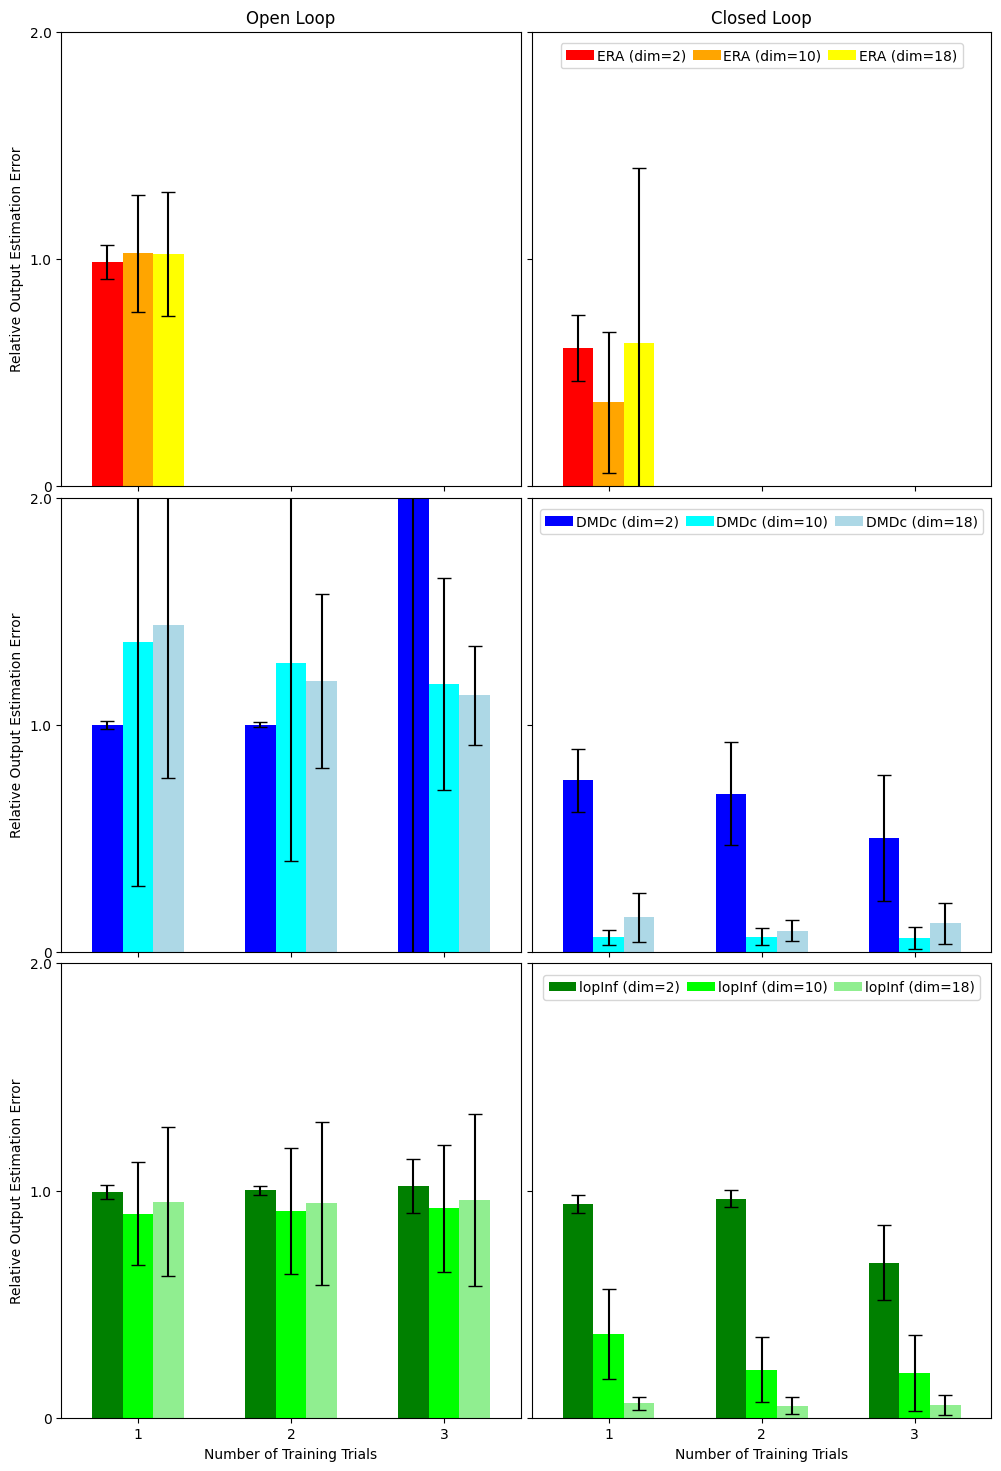

In [17]:
# Plot errors of open/closed loop for models of dimension 2, 12, and 18 as bar plots with error bars
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

width = 0.2  # Width of the bars

# ERA
ax[0, 0].bar(era_OL[era_OL["romDim"] == 2]["numTraining"] - width, era_OL[era_OL["romDim"] == 2]["outputError_mean"], 
             yerr=era_OL[era_OL["romDim"] == 2]["outputError_std"], width=width, label="ERA (dim=2)", color='red', capsize=5)
ax[0, 0].bar(era_OL[era_OL["romDim"] == 10]["numTraining"], era_OL[era_OL["romDim"] == 10]["outputError_mean"], 
             yerr=era_OL[era_OL["romDim"] == 10]["outputError_std"], width=width, label="ERA (dim=10)", color='orange', capsize=5)
ax[0, 0].bar(era_OL[era_OL["romDim"] == 18]["numTraining"] + width, era_OL[era_OL["romDim"] == 18]["outputError_mean"], 
             yerr=era_OL[era_OL["romDim"] == 18]["outputError_std"], width=width, label="ERA (dim=18)", color='yellow', capsize=5)

ax[0, 1].bar(era_CL[era_CL["romDim"] == 2]["numTraining"] - width, era_CL[era_CL["romDim"] == 2]["outputError_mean"], 
             yerr=era_CL[era_CL["romDim"] == 2]["outputError_std"], width=width, label="ERA (dim=2)", color='red', capsize=5)
ax[0, 1].bar(era_CL[era_CL["romDim"] == 10]["numTraining"], era_CL[era_CL["romDim"] == 10]["outputError_mean"], 
             yerr=era_CL[era_CL["romDim"] == 10]["outputError_std"], width=width, label="ERA (dim=10)", color='orange', capsize=5)
ax[0, 1].bar(era_CL[era_CL["romDim"] == 18]["numTraining"] + width, era_CL[era_CL["romDim"] == 18]["outputError_mean"], 
             yerr=era_CL[era_CL["romDim"] == 18]["outputError_std"], width=width, label="ERA (dim=18)", color='yellow', capsize=5)

# DMDc
ax[1, 0].bar(dmdc_OL[dmdc_OL["romDim"] == 2]["numTraining"] - width, dmdc_OL[dmdc_OL["romDim"] == 2]["outputError_mean"], 
             yerr=dmdc_OL[dmdc_OL["romDim"] == 2]["outputError_std"], width=width, label="DMDc (dim=2)", color='blue', capsize=5)
ax[1, 0].bar(dmdc_OL[dmdc_OL["romDim"] == 10]["numTraining"], dmdc_OL[dmdc_OL["romDim"] == 10]["outputError_mean"], 
             yerr=dmdc_OL[dmdc_OL["romDim"] == 10]["outputError_std"], width=width, label="DMDc (dim=10)", color='cyan', capsize=5)
ax[1, 0].bar(dmdc_OL[dmdc_OL["romDim"] == 18]["numTraining"] + width, dmdc_OL[dmdc_OL["romDim"] == 18]["outputError_mean"], 
             yerr=dmdc_OL[dmdc_OL["romDim"] == 18]["outputError_std"], width=width, label="DMDc (dim=18)", color='lightblue', capsize=5)

ax[1, 1].bar(dmdc_CL[dmdc_CL["romDim"] == 2]["numTraining"] - width, dmdc_CL[dmdc_CL["romDim"] == 2]["outputError_mean"], 
             yerr=dmdc_CL[dmdc_CL["romDim"] == 2]["outputError_std"], width=width, label="DMDc (dim=2)", color='blue', capsize=5)
ax[1, 1].bar(dmdc_CL[dmdc_CL["romDim"] == 10]["numTraining"], dmdc_CL[dmdc_CL["romDim"] == 10]["outputError_mean"], 
             yerr=dmdc_CL[dmdc_CL["romDim"] == 10]["outputError_std"], width=width, label="DMDc (dim=10)", color='cyan', capsize=5)
ax[1, 1].bar(dmdc_CL[dmdc_CL["romDim"] == 18]["numTraining"] + width, dmdc_CL[dmdc_CL["romDim"] == 18]["outputError_mean"], 
             yerr=dmdc_CL[dmdc_CL["romDim"] == 18]["outputError_std"], width=width, label="DMDc (dim=18)", color='lightblue', capsize=5)

# lopInf
ax[2, 0].bar(lopinf_OL[lopinf_OL["romDim"] == 2]["numTraining"] - width, lopinf_OL[lopinf_OL["romDim"] == 2]["outputError_mean"], 
             yerr=lopinf_OL[lopinf_OL["romDim"] == 2]["outputError_std"], width=width, label="lopInf (dim=2)", color='green', capsize=5)
ax[2, 0].bar(lopinf_OL[lopinf_OL["romDim"] == 10]["numTraining"], lopinf_OL[lopinf_OL["romDim"] == 10]["outputError_mean"], 
             yerr=lopinf_OL[lopinf_OL["romDim"] == 10]["outputError_std"], width=width, label="lopInf (dim=10)", color='lime', capsize=5)
ax[2, 0].bar(lopinf_OL[lopinf_OL["romDim"] == 18]["numTraining"] + width, lopinf_OL[lopinf_OL["romDim"] == 18]["outputError_mean"], 
             yerr=lopinf_OL[lopinf_OL["romDim"] == 18]["outputError_std"], width=width, label="lopInf (dim=18)", color='lightgreen', capsize=5)

ax[2, 1].bar(lopinf_CL[lopinf_CL["romDim"] == 2]["numTraining"] - width, lopinf_CL[lopinf_CL["romDim"] == 2]["outputError_mean"], 
             yerr=lopinf_CL[lopinf_CL["romDim"] == 2]["outputError_std"], width=width, label="lopInf (dim=2)", color='green', capsize=5)
ax[2, 1].bar(lopinf_CL[lopinf_CL["romDim"] == 10]["numTraining"], lopinf_CL[lopinf_CL["romDim"] == 10]["outputError_mean"], 
             yerr=lopinf_CL[lopinf_CL["romDim"] == 10]["outputError_std"], width=width, label="lopInf (dim=10)", color='lime', capsize=5)
ax[2, 1].bar(lopinf_CL[lopinf_CL["romDim"] == 18]["numTraining"] + width, lopinf_CL[lopinf_CL["romDim"] == 18]["outputError_mean"], 
             yerr=lopinf_CL[lopinf_CL["romDim"] == 18]["outputError_std"], width=width, label="lopInf (dim=18)", color='lightgreen', capsize=5)

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 2])
        ax[i, j].set_xlim([0.5, 3.5])
        ax[i, j].set_xticks([1, 2, 3])
        ax[i, j].set_xticklabels(["1", "2", "3"] if i == 2 else [])
        ax[i, j].set_yticks([0, 1.0, 2.0])
        ax[i, j].set_yticklabels([0, 1.0, 2.0] if j == 0 else [])
        if i == 2:
            ax[i, j].set_xlabel("Number of Training Trials")
        if j == 0:
            ax[i, j].set_ylabel("Relative Output Estimation Error")
        if j == 1:
            ax[i, j].legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=10, frameon=True, handletextpad=0.2, columnspacing=0.5)
# Set titles only for the topmost plots
ax[0, 0].set_title("Open Loop")
ax[0, 1].set_title("Closed Loop")
# Reduce vertical whitespace between plots
fig.subplots_adjust(hspace=0.025)
fig.subplots_adjust(wspace=0.025)

# Save svg
plt.savefig(visualizationDir + "outputEstimationErrors_trialGroups.svg", format='svg', dpi=1200)

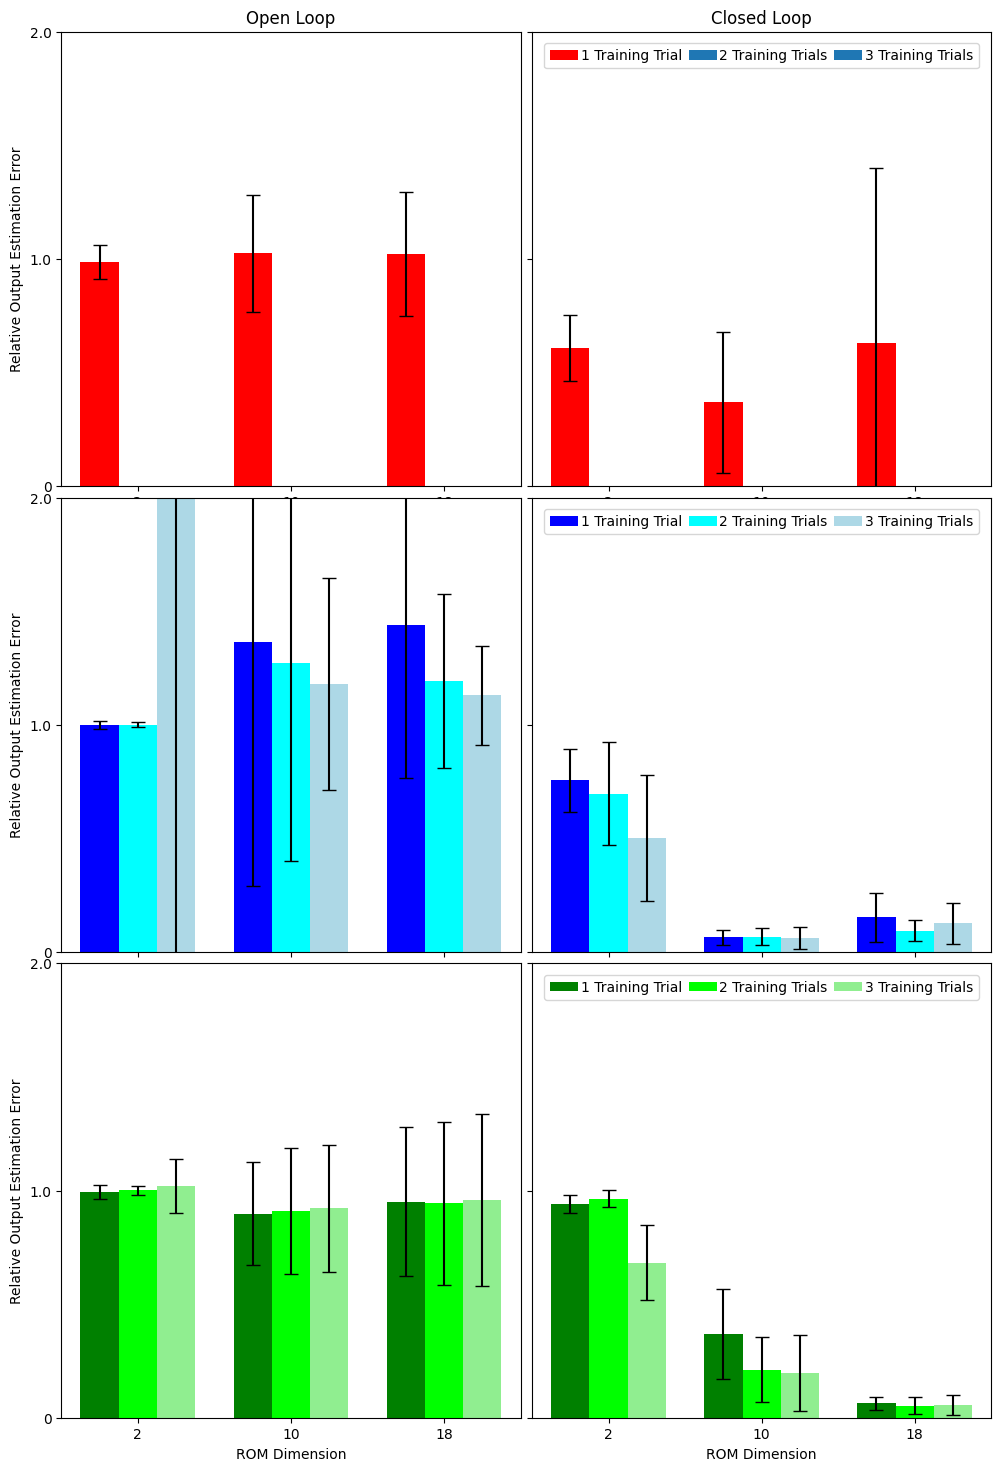

In [18]:
# Plot errors of open/closed loop for models of dimension 2, 10, and 18 as bar plots with error bars
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

width = 2  # Increased width for thicker bars

# ERA - open loop
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 1)]
ax[0, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='red', capsize=5)
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 2)]
ax[0, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='orange', capsize=5)
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 3)]
ax[0, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='yellow', capsize=5)

# ERA - closed loop
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 1)]
ax[0, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='red', capsize=5)
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 2)]
ax[0, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='orange', capsize=5)
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 3)]
ax[0, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='yellow', capsize=5)

# DMDc - open loop
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 1)]
ax[1, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='blue', capsize=5)
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 2)]
ax[1, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='cyan', capsize=5)
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 3)]
ax[1, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightblue', capsize=5)

# DMDc - closed loop
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 1)]
ax[1, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='blue', capsize=5)
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 2)]
ax[1, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='cyan', capsize=5)
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 3)]
ax[1, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightblue', capsize=5)

# lopInf - open loop
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 1)]
ax[2, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='green', capsize=5)
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 2)]
ax[2, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='lime', capsize=5)
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 3)]
ax[2, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightgreen', capsize=5)

# lopInf - closed loop
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 1)]
ax[2, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='green', capsize=5)
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 2)]
ax[2, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='lime', capsize=5)
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 3)]
ax[2, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightgreen', capsize=5)

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 2])
        ax[i, j].set_xlim([-2, 22])
        ax[i, j].set_xticks([2, 10, 18])
        ax[i, j].set_yticks([0, 1.0, 2.0])
        ax[i, j].set_yticklabels([0, 1.0, 2.0] if j == 0 else [])

        if i == 2:
            ax[i, j].set_xlabel("ROM Dimension")
        if j == 0:
            ax[i, j].set_ylabel("Relative Output Estimation Error")
        if j == 1:
            ax[i, j].legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=10, frameon=True, handletextpad=0.2, columnspacing=0.5)

ax[0, 0].set_title("Open Loop")
ax[0, 1].set_title("Closed Loop")
fig.subplots_adjust(hspace=0.025, wspace=0.025)

plt.savefig(visualizationDir + "outputEstimationErrors_dimGroups.svg", format='svg', dpi=1200)

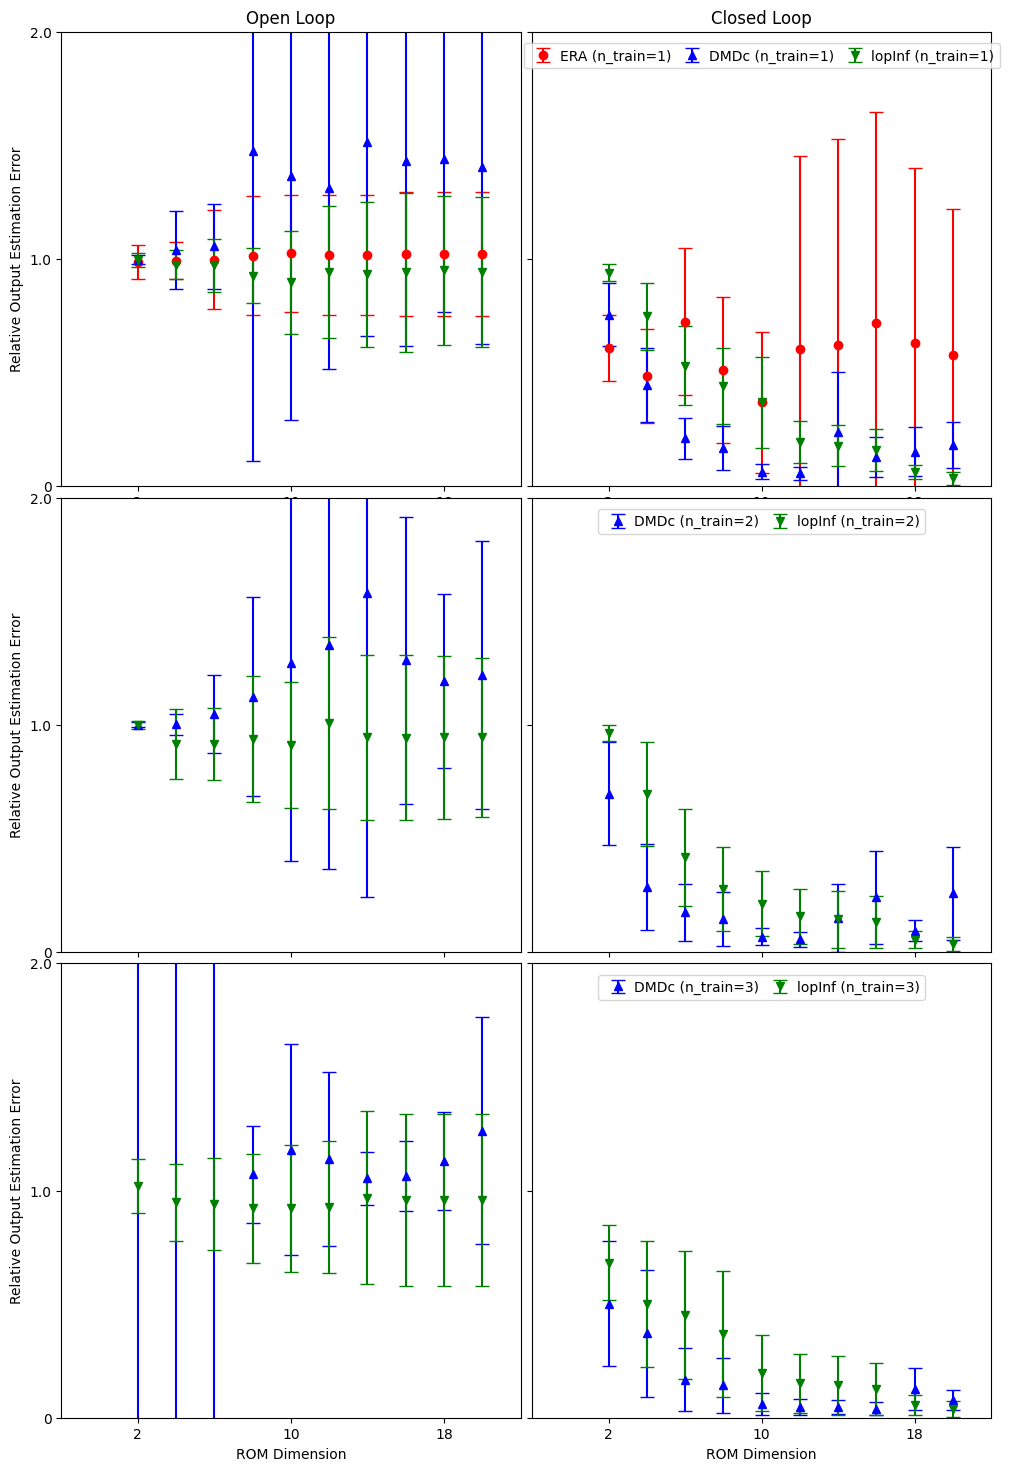

In [19]:
# Plot average prediction errors as a function of rom dimension with error bars
fig, ax = plt.subplots(3,2, figsize=(12, 18))
ax[0,0].errorbar(era_OL[era_OL["numTraining"] == 1]["romDim"], era_OL[era_OL["numTraining"] == 1]["outputError_mean"], yerr=era_OL[era_OL["numTraining"] == 1]["outputError_std"], label="ERA (n_train=1)", fmt='o', capsize=5, color='red')

ax[0,1].errorbar(era_CL[era_CL["numTraining"] == 1]["romDim"], era_CL[era_CL["numTraining"] == 1]["outputError_mean"], yerr=era_CL[era_CL["numTraining"] == 1]["outputError_std"], label="ERA (n_train=1)", fmt='o', capsize=5, color='red')

ax[0,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 1]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 1]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 1]["outputError_std"], label="DMDc (n_train=1)", fmt='^', capsize=5, color='blue')
ax[1,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 2]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 2]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 2]["outputError_std"], label="DMDc (n_train=2)", fmt='^', capsize=5, color='blue')
ax[2,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 3]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 3]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 3]["outputError_std"], label="DMDc (n_train=3)", fmt='^', capsize=5, color='blue')

ax[0,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 1]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 1]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 1]["outputError_std"], label="DMDc (n_train=1)", fmt='^', capsize=5, color='blue')
ax[1,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 2]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 2]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 2]["outputError_std"], label="DMDc (n_train=2)", fmt='^', capsize=5, color='blue')
ax[2,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 3]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 3]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 3]["outputError_std"], label="DMDc (n_train=3)", fmt='^', capsize=5, color='blue')

ax[0,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 1]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 1]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 1]["outputError_std"], label="lopInf (n_train=1)", fmt='v', capsize=5, color='green')
ax[1,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 2]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 2]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 2]["outputError_std"], label="lopInf (n_train=2)", fmt='v', capsize=5, color='green')
ax[2,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 3]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 3]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 3]["outputError_std"], label="lopInf (n_train=3)", fmt='v', capsize=5, color='green')

ax[0,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 1]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 1]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 1]["outputError_std"], label="lopInf (n_train=1)", fmt='v', capsize=5, color='green')
ax[1,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 2]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 2]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 2]["outputError_std"], label="lopInf (n_train=2)", fmt='v', capsize=5, color='green')
ax[2,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 3]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 3]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 3]["outputError_std"], label="lopInf (n_train=3)", fmt='v', capsize=5, color='green')

for i in range(3):
    for j in range(2):
        ax[i, j].set_ylim([0, 2])
        ax[i, j].set_xlim([-2, 22])
        ax[i, j].set_xticks([2, 10, 18])
        ax[i, j].set_yticks([0, 1.0, 2.0])
        ax[i, j].set_yticklabels([0, 1.0, 2.0] if j == 0 else [])

        if i == 2:
            ax[i, j].set_xlabel("ROM Dimension")
        if j == 0:
            ax[i, j].set_ylabel("Relative Output Estimation Error")
        if j == 1:
            ax[i, j].legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=10, frameon=True, handletextpad=0.2, columnspacing=0.5)

ax[0, 0].set_title("Open Loop")
ax[0, 1].set_title("Closed Loop")
fig.subplots_adjust(hspace=0.025, wspace=0.025)

# save as svg
plt.savefig(visualizationDir + "outputEstimationErrors_dim.svg", format='svg', dpi=1200)


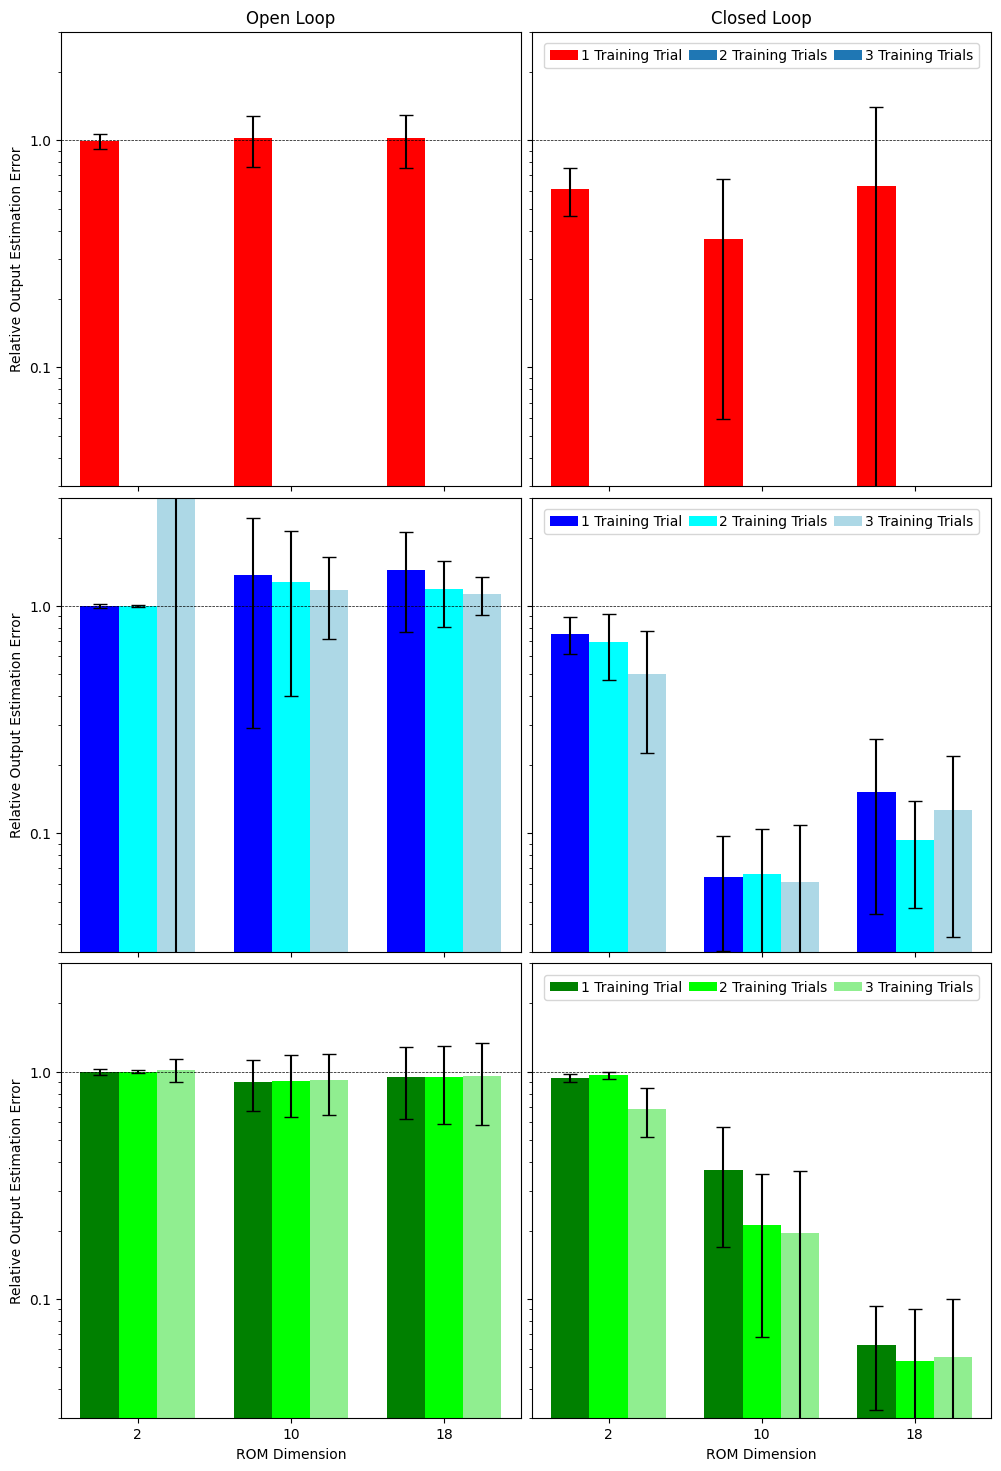

In [20]:
# Plot errors of open/closed loop for models of dimension 2, 10, and 18 as bar plots with error bars
fig, ax = plt.subplots(3, 2, figsize=(12, 18))

width = 2  # Increased width for thicker bars

# ERA - open loop
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 1)]
ax[0, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='red', capsize=5)
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 2)]
ax[0, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='orange', capsize=5)
df = era_OL[(era_OL["romDim"].isin([2, 10, 18])) & (era_OL["numTraining"] == 3)]
ax[0, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='yellow', capsize=5)

# ERA - closed loop
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 1)]
ax[0, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='red', capsize=5)
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 2)]
ax[0, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='orange', capsize=5)
df = era_CL[(era_CL["romDim"].isin([2, 10, 18])) & (era_CL["numTraining"] == 3)]
ax[0, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='yellow', capsize=5)

# DMDc - open loop
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 1)]
ax[1, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='blue', capsize=5)
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 2)]
ax[1, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='cyan', capsize=5)
df = dmdc_OL[(dmdc_OL["romDim"].isin([2, 10, 18])) & (dmdc_OL["numTraining"] == 3)]
ax[1, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightblue', capsize=5)

# DMDc - closed loop
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 1)]
ax[1, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='blue', capsize=5)
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 2)]
ax[1, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='cyan', capsize=5)
df = dmdc_CL[(dmdc_CL["romDim"].isin([2, 10, 18])) & (dmdc_CL["numTraining"] == 3)]
ax[1, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightblue', capsize=5)

# lopInf - open loop
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 1)]
ax[2, 0].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='green', capsize=5)
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 2)]
ax[2, 0].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='lime', capsize=5)
df = lopinf_OL[(lopinf_OL["romDim"].isin([2, 10, 18])) & (lopinf_OL["numTraining"] == 3)]
ax[2, 0].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightgreen', capsize=5)

# lopInf - closed loop
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 1)]
ax[2, 1].bar(df["romDim"] - width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="1 Training Trial", color='green', capsize=5)
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 2)]
ax[2, 1].bar(df["romDim"], df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="2 Training Trials", color='lime', capsize=5)
df = lopinf_CL[(lopinf_CL["romDim"].isin([2, 10, 18])) & (lopinf_CL["numTraining"] == 3)]
ax[2, 1].bar(df["romDim"] + width, df["outputError_mean"], 
             yerr=df["outputError_std"], width=width, label="3 Training Trials", color='lightgreen', capsize=5)

for i in range(3):
    for j in range(2):
        # Horizontal lines
        ax[i, j].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
        ax[i, j].set_yscale("log")
        ax[i, j].set_ylim([3e-2, 3])
        ax[i, j].set_xlim([-2, 22])
        ax[i, j].set_xticks([2, 10, 18])
        ax[i, j].set_xticklabels([2, 10, 18] if i == 2 else [])
        ax[i, j].set_yticks([0.1, 1.0])
        ax[i, j].set_yticklabels([0.1, 1.] if j == 0 else [])

        if i == 2:
            ax[i, j].set_xlabel("ROM Dimension")
        if j == 0:
            ax[i, j].set_ylabel("Relative Output Estimation Error")
        if j == 1:
            ax[i, j].legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=10, frameon=True, handletextpad=0.2, columnspacing=0.5)

ax[0, 0].set_title("Open Loop")
ax[0, 1].set_title("Closed Loop")
fig.subplots_adjust(hspace=0.025, wspace=0.025)

plt.savefig(visualizationDir + "outputEstimationErrors_dimGroups_logy.svg", format='svg', dpi=1200, transparent=True, bbox_inches='tight')

In [21]:
# Print prediction errors for DMDc Open loop with dimensions 2 and 4 trained on 3 trials
print("DMDc Open Loop with dimensions 2 and 4 trained on 3 trials:")
print(dmdc_OL[(dmdc_OL["romDim"] == 2) & (dmdc_OL["numTraining"] == 3)][["romDim", "numTraining", "outputError_mean", "outputError_std"]])
print(dmdc_OL[(dmdc_OL["romDim"] == 4) & (dmdc_OL["numTraining"] == 3)][["romDim", "numTraining", "outputError_mean", "outputError_std"]])        

DMDc Open Loop with dimensions 2 and 4 trained on 3 trials:
    romDim  numTraining  outputError_mean  outputError_std
22       2            3       2946.602851      3601.702152
    romDim  numTraining  outputError_mean  outputError_std
50       4            3       2150.317248      2665.927131


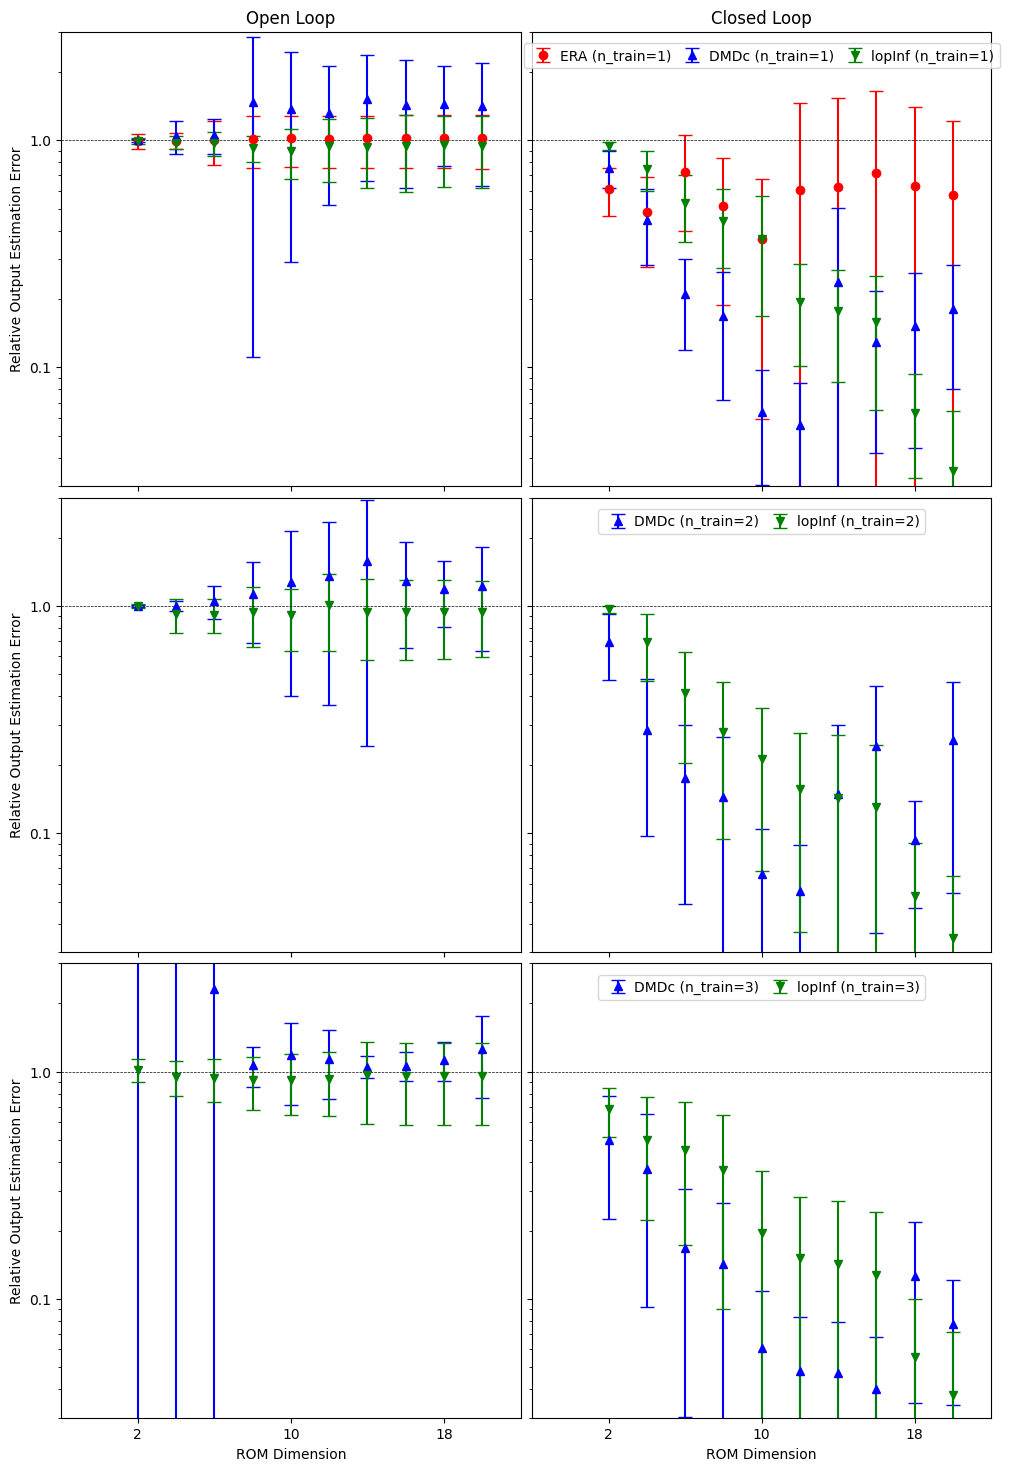

In [22]:
# Plot average prediction errors as a function of rom dimension with error bars
fig, ax = plt.subplots(3,2, figsize=(12, 18))
ax[0,0].errorbar(era_OL[era_OL["numTraining"] == 1]["romDim"], era_OL[era_OL["numTraining"] == 1]["outputError_mean"], yerr=era_OL[era_OL["numTraining"] == 1]["outputError_std"], label="ERA (n_train=1)", fmt='o', capsize=5, color='red')

ax[0,1].errorbar(era_CL[era_CL["numTraining"] == 1]["romDim"], era_CL[era_CL["numTraining"] == 1]["outputError_mean"], yerr=era_CL[era_CL["numTraining"] == 1]["outputError_std"], label="ERA (n_train=1)", fmt='o', capsize=5, color='red')

ax[0,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 1]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 1]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 1]["outputError_std"], label="DMDc (n_train=1)", fmt='^', capsize=5, color='blue')
ax[1,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 2]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 2]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 2]["outputError_std"], label="DMDc (n_train=2)", fmt='^', capsize=5, color='blue')
ax[2,0].errorbar(dmdc_OL[dmdc_OL["numTraining"] == 3]["romDim"], dmdc_OL[dmdc_OL["numTraining"] == 3]["outputError_mean"], yerr=dmdc_OL[dmdc_OL["numTraining"] == 3]["outputError_std"], label="DMDc (n_train=3)", fmt='^', capsize=5, color='blue')

ax[0,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 1]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 1]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 1]["outputError_std"], label="DMDc (n_train=1)", fmt='^', capsize=5, color='blue')
ax[1,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 2]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 2]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 2]["outputError_std"], label="DMDc (n_train=2)", fmt='^', capsize=5, color='blue')
ax[2,1].errorbar(dmdc_CL[dmdc_CL["numTraining"] == 3]["romDim"], dmdc_CL[dmdc_CL["numTraining"] == 3]["outputError_mean"], yerr=dmdc_CL[dmdc_CL["numTraining"] == 3]["outputError_std"], label="DMDc (n_train=3)", fmt='^', capsize=5, color='blue')

ax[0,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 1]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 1]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 1]["outputError_std"], label="lopInf (n_train=1)", fmt='v', capsize=5, color='green')
ax[1,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 2]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 2]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 2]["outputError_std"], label="lopInf (n_train=2)", fmt='v', capsize=5, color='green')
ax[2,0].errorbar(lopinf_OL[lopinf_OL["numTraining"] == 3]["romDim"], lopinf_OL[lopinf_OL["numTraining"] == 3]["outputError_mean"], yerr=lopinf_OL[lopinf_OL["numTraining"] == 3]["outputError_std"], label="lopInf (n_train=3)", fmt='v', capsize=5, color='green')

ax[0,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 1]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 1]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 1]["outputError_std"], label="lopInf (n_train=1)", fmt='v', capsize=5, color='green')
ax[1,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 2]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 2]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 2]["outputError_std"], label="lopInf (n_train=2)", fmt='v', capsize=5, color='green')
ax[2,1].errorbar(lopinf_CL[lopinf_CL["numTraining"] == 3]["romDim"], lopinf_CL[lopinf_CL["numTraining"] == 3]["outputError_mean"], yerr=lopinf_CL[lopinf_CL["numTraining"] == 3]["outputError_std"], label="lopInf (n_train=3)", fmt='v', capsize=5, color='green')

for i in range(3):
    for j in range(2):
        # Horizontal line at y=1
        ax[i, j].axhline(y=1, color='black', linestyle='--', linewidth=0.5)
        # Set logarithmic scale for y-axis
        ax[i, j].set_yscale('log')
        ax[i, j].set_ylim([3e-2, 3])
        ax[i, j].set_xlim([-2, 22])
        ax[i, j].set_xticks([2, 10, 18])
        ax[i, j].set_xticklabels([2, 10, 18] if i == 2 else [])
        ax[i, j].set_yticks([.1, 1.0])
        ax[i, j].set_yticklabels([0.1, 1.0] if j == 0 else [])
        # ax[i, j].set_yticklabels([1.0, 2.0] if j == 0 else [])

        if i == 2:
            ax[i, j].set_xlabel("ROM Dimension")
        if j == 0:
            ax[i, j].set_ylabel("Relative Output Estimation Error")
        if j == 1:
            ax[i, j].legend(loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, fontsize=10, frameon=True, handletextpad=0.2, columnspacing=0.5)
ax[0, 0].set_title("Open Loop")
ax[0, 1].set_title("Closed Loop")
fig.subplots_adjust(hspace=0.025, wspace=0.025)

# save as svg
plt.savefig(visualizationDir + "outputEstimationErrors_dim_logy.svg", format='svg', dpi=1200, transparent=True, bbox_inches='tight')


In [23]:
l=5
m=3
N=10
Em = np.concatenate([np.eye(l),np.zeros((l*(N-1),l))],axis=0)
Ep = np.concatenate([np.eye(m),np.zeros((m*(N-1),m))],axis=0)
print("Em shape:", Em.shape)
print("Ep shape:", Ep.shape)

Em shape: (50, 5)
Ep shape: (30, 3)


Plot errors as function of input frequency


In [24]:
# Pull errors for each model type

# ERA
era_freq_OL = errors[(errors["romType"] == "ERA") & (errors["OL"] == True) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
era_freq_CL = errors[(errors["romType"] == "ERA") & (errors["OL"] == False) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
# DMDc
dmdc_freq_OL = errors[(errors["romType"] == "DMDc") & (errors["OL"] == True) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
dmdc_freq_CL = errors[(errors["romType"] == "DMDc") & (errors["OL"] == False) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
# lopInf
lopinf_freq_OL = errors[(errors["romType"] == "lopInf") & (errors["OL"] == True) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]
lopinf_freq_CL = errors[(errors["romType"] == "lopInf") & (errors["OL"] == False) & (errors["trainingEp"] == False)] # & (errors["numTraining"]==1) & (errors["romDim"] == 10)]


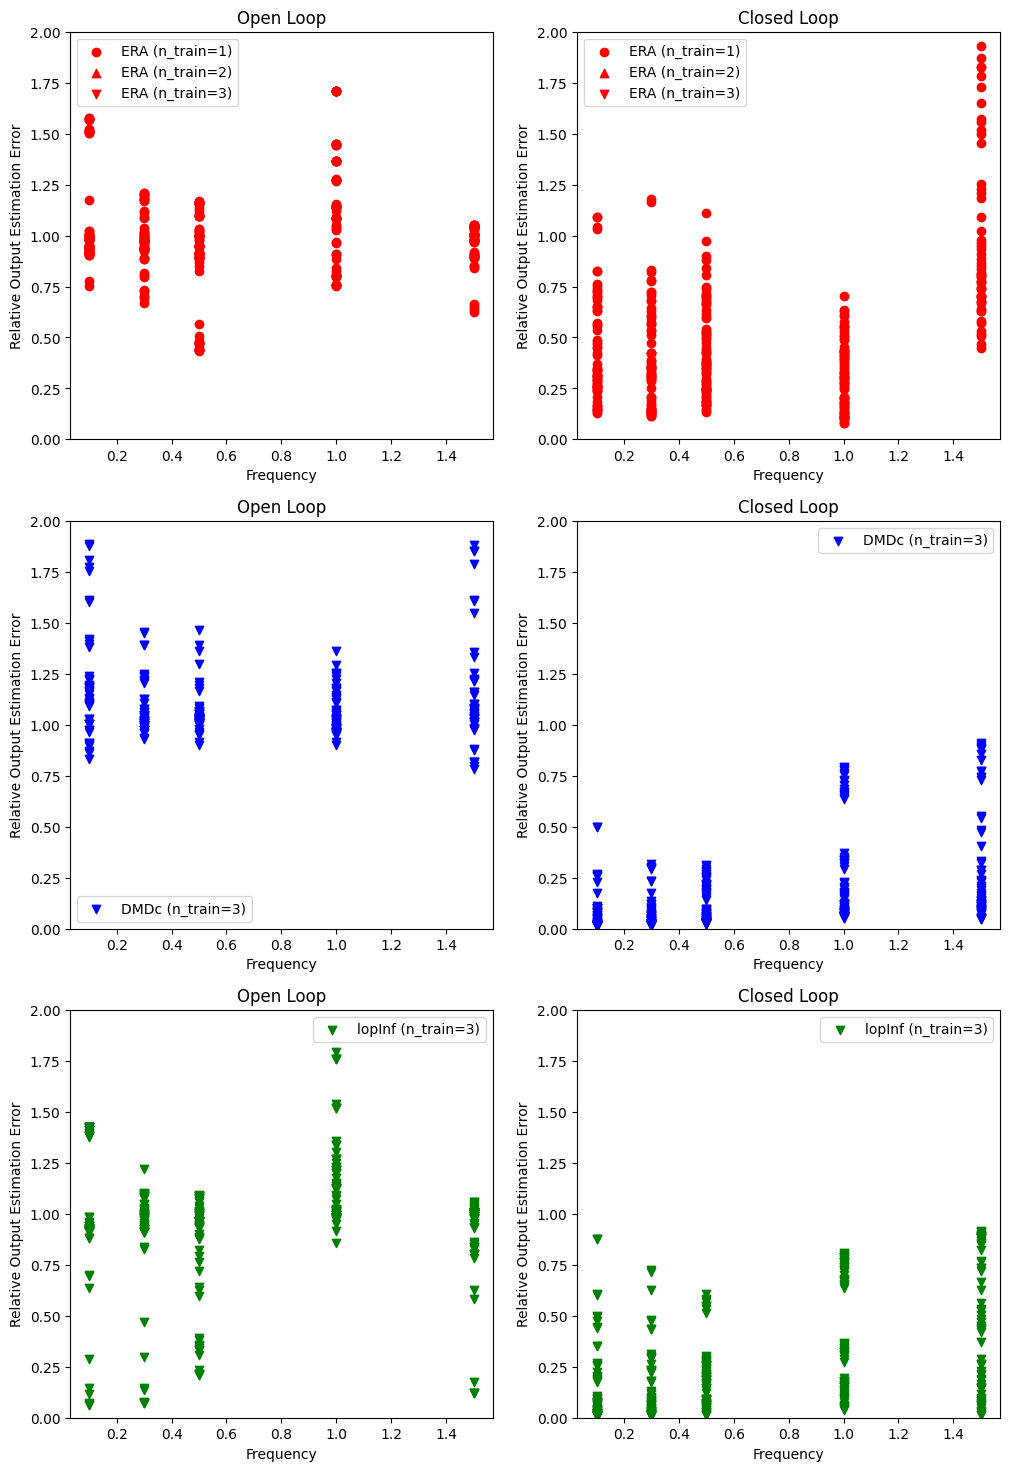

In [25]:
# Scatter plot of the errors for each model type and frequency - different markers for different number of training trials
fig, ax = plt.subplots(3,2, figsize=(12, 18))
ax[0,0].scatter(era_freq_OL[(era_freq_OL["numTraining"]==1) ]["frequency"], era_freq_OL[(era_freq_OL["numTraining"]==1)]["outputError"], label="ERA (n_train=1)", color='red', marker='o')
ax[0,0].scatter(era_freq_OL[(era_freq_OL["numTraining"]==2) ]["frequency"], era_freq_OL[(era_freq_OL["numTraining"]==2)]["outputError"], label="ERA (n_train=2)", color='red', marker='^')
ax[0,0].scatter(era_freq_OL[(era_freq_OL["numTraining"]==3) ]["frequency"], era_freq_OL[(era_freq_OL["numTraining"]==3)]["outputError"], label="ERA (n_train=3)", color='red', marker='v')

ax[0,1].scatter(era_freq_CL[(era_freq_CL["numTraining"]==1) ]["frequency"], era_freq_CL[(era_freq_CL["numTraining"]==1)]["outputError"], label="ERA (n_train=1)", color='red', marker='o')
ax[0,1].scatter(era_freq_CL[(era_freq_CL["numTraining"]==2) ]["frequency"], era_freq_CL[(era_freq_CL["numTraining"]==2)]["outputError"], label="ERA (n_train=2)", color='red', marker='^')
ax[0,1].scatter(era_freq_CL[(era_freq_CL["numTraining"]==3) ]["frequency"], era_freq_CL[(era_freq_CL["numTraining"]==3)]["outputError"], label="ERA (n_train=3)", color='red', marker='v')

# ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==1) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==1)]["outputError"], label="DMDc (n_train=1)", color='blue', marker='o')
# ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==2) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==2)]["outputError"], label="DMDc (n_train=2)", color='blue', marker='^')
ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==3) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["numTraining"]==3)]["outputError"], label="DMDc (n_train=3)", color='blue', marker='v')

# ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==1) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==1)]["outputError"], label="DMDc (n_train=1)", color='blue', marker='o')
# ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==2) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==2)]["outputError"], label="DMDc (n_train=2)", color='blue', marker='^')
ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==3) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["numTraining"]==3)]["outputError"], label="DMDc (n_train=3)", color='blue', marker='v')

# ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==1) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==1)]["outputError"], label="lopInf (n_train=1)", color='green', marker='o')
# ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==2) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==2)]["outputError"], label="lopInf (n_train=2)", color='green', marker='^')
ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==3) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["numTraining"]==3)]["outputError"], label="lopInf (n_train=3)", color='green', marker='v')

# ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==1) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==1)]["outputError"], label="lopInf (n_train=1)", color='green', marker='o')
# ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==2) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==2)]["outputError"], label="lopInf (n_train=2)", color='green', marker='^')
ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==3) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["numTraining"]==3)]["outputError"], label="lopInf (n_train=3)", color='green', marker='v')

for i in range(3):
    for j in range(2):
        ax[i,j].set_ylim([0, 2])
        ax[i,j].set_xlabel("Frequency")
        ax[i,j].set_ylabel("Relative Output Estimation Error")
        ax[i,j].legend()
        # ax[i,j].grid()
        ax[i,j].set_title("Open Loop" if j == 0 else "Closed Loop")

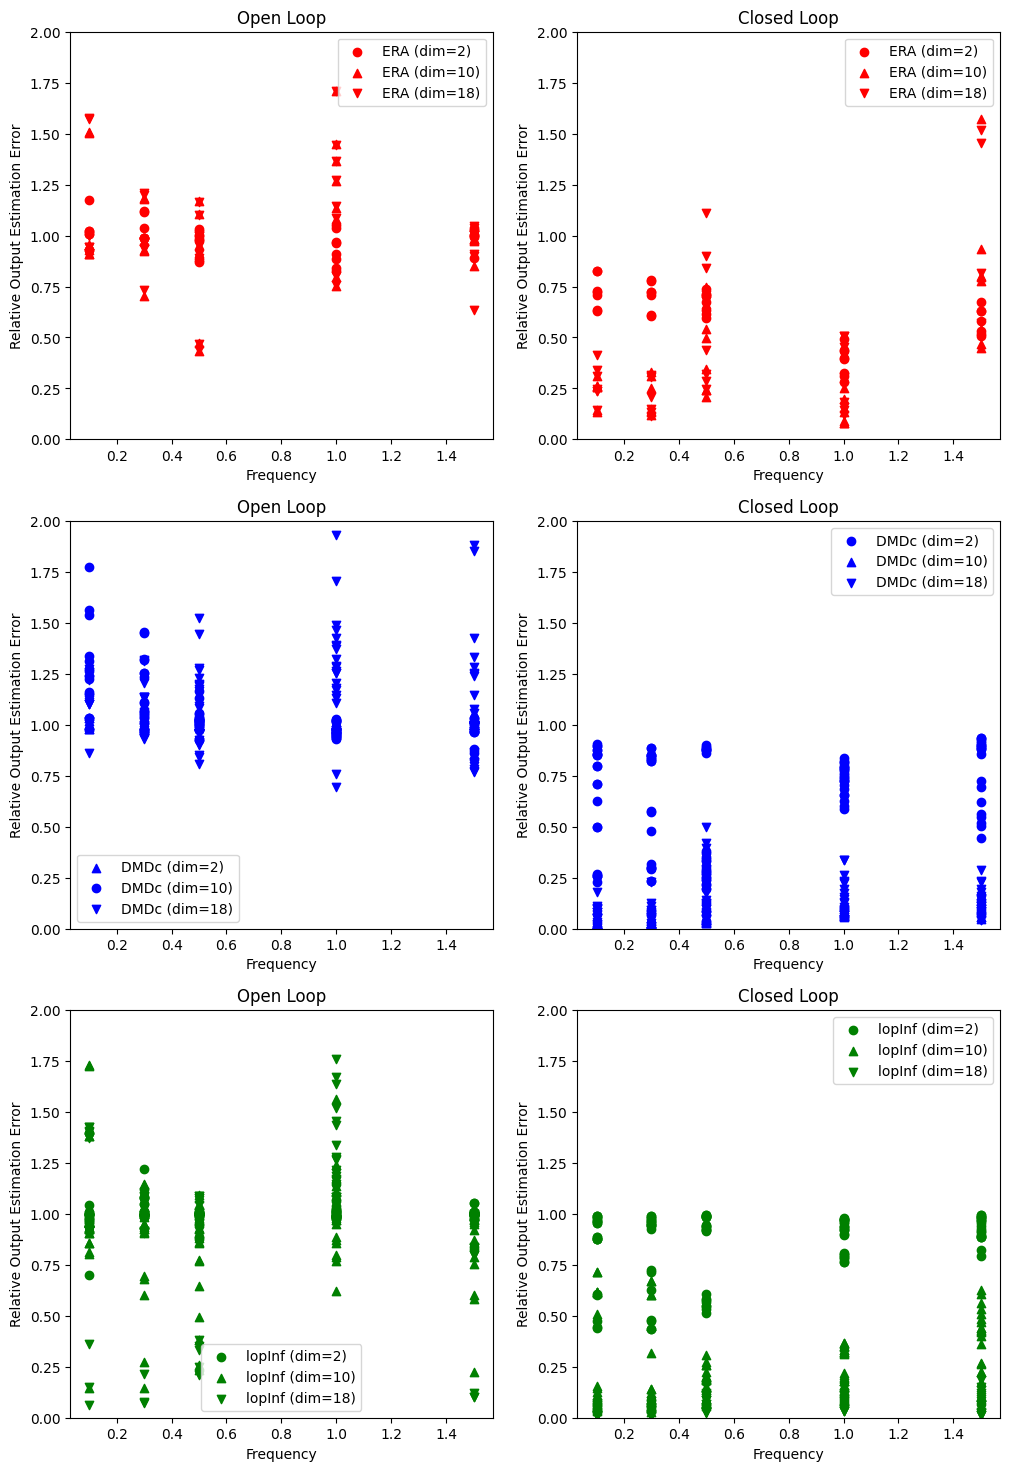

In [26]:
# Scatter plot of the errors for each model type and frequency - different markers for different rom dimensions
fig, ax = plt.subplots(3,2, figsize=(12, 18))
ax[0,0].scatter(era_freq_OL[(era_freq_OL["romDim"]==2) ]["frequency"], era_freq_OL[(era_freq_OL["romDim"]==2)]["outputError"], label="ERA (dim=2)", color='red', marker='o')
ax[0,0].scatter(era_freq_OL[(era_freq_OL["romDim"]==10) ]["frequency"], era_freq_OL[(era_freq_OL["romDim"]==10)]["outputError"], label="ERA (dim=10)", color='red', marker='^')
ax[0,0].scatter(era_freq_OL[(era_freq_OL["romDim"]==18) ]["frequency"], era_freq_OL[(era_freq_OL["romDim"]==18)]["outputError"], label="ERA (dim=18)", color='red', marker='v')

ax[0,1].scatter(era_freq_CL[(era_freq_CL["romDim"]==2) ]["frequency"], era_freq_CL[(era_freq_CL["romDim"]==2)]["outputError"], label="ERA (dim=2)", color='red', marker='o')
ax[0,1].scatter(era_freq_CL[(era_freq_CL["romDim"]==10) ]["frequency"], era_freq_CL[(era_freq_CL["romDim"]==10)]["outputError"], label="ERA (dim=10)", color='red', marker='^')
ax[0,1].scatter(era_freq_CL[(era_freq_CL["romDim"]==18) ]["frequency"], era_freq_CL[(era_freq_CL["romDim"]==18)]["outputError"], label="ERA (dim=18)", color='red', marker='v')

ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["romDim"]==2) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["romDim"]==2)]["outputError"], label="DMDc (dim=2)", color='blue', marker='^')
ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["romDim"]==10) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["romDim"]==10)]["outputError"], label="DMDc (dim=10)", color='blue', marker='o')
ax[1,0].scatter(dmdc_freq_OL[(dmdc_freq_OL["romDim"]==18) ]["frequency"], dmdc_freq_OL[(dmdc_freq_OL["romDim"]==18)]["outputError"], label="DMDc (dim=18)", color='blue', marker='v')

ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["romDim"]==2) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["romDim"]==2)]["outputError"], label="DMDc (dim=2)", color='blue', marker='o')
ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["romDim"]==10) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["romDim"]==10)]["outputError"], label="DMDc (dim=10)", color='blue', marker='^')
ax[1,1].scatter(dmdc_freq_CL[(dmdc_freq_CL["romDim"]==18) ]["frequency"], dmdc_freq_CL[(dmdc_freq_CL["romDim"]==18)]["outputError"], label="DMDc (dim=18)", color='blue', marker='v')

ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["romDim"]==2) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["romDim"]==2)]["outputError"], label="lopInf (dim=2)", color='green', marker='o')
ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["romDim"]==10) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["romDim"]==10)]["outputError"], label="lopInf (dim=10)", color='green', marker='^')
ax[2,0].scatter(lopinf_freq_OL[(lopinf_freq_OL["romDim"]==18) ]["frequency"], lopinf_freq_OL[(lopinf_freq_OL["romDim"]==18)]["outputError"], label="lopInf (dim=18)", color='green', marker='v')

ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["romDim"]==2) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["romDim"]==2)]["outputError"], label="lopInf (dim=2)", color='green', marker='o')
ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["romDim"]==10) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["romDim"]==10)]["outputError"], label="lopInf (dim=10)", color='green', marker='^')
ax[2,1].scatter(lopinf_freq_CL[(lopinf_freq_CL["romDim"]==18) ]["frequency"], lopinf_freq_CL[(lopinf_freq_CL["romDim"]==18)]["outputError"], label="lopInf (dim=18)", color='green', marker='v')

for i in range(3):
    for j in range(2):
        ax[i,j].set_ylim([0, 2])
        ax[i,j].set_xlabel("Frequency")
        ax[i,j].set_ylabel("Relative Output Estimation Error")
        ax[i,j].legend()
        # ax[i,j].grid()
        ax[i,j].set_title("Open Loop" if j == 0 else "Closed Loop")

# Control Experiments

## Helper function to read in data

In [27]:
# Helper functions for working with database
def get_db_connection():
    conn = psycopg2.connect(
        dbname='simDB',
        user='user',
        password='password',
        host='localhost',
        port='5432'
    )
    return conn

def fetch_trial_data(conn, trial_id,n=1,limit=500):
    try:
        cur = conn.cursor()
        
        # Fetch data for the given trial_id
        query = '''
        SELECT timestep, simulation_time, input_data, output_data, y_ref, x_hat
        FROM simulation_data
        WHERE trial_id = %s AND MOD(timestep, %s) = 0
        ORDER BY timestep ASC LIMIT %s;
        '''
        cur.execute(query, (trial_id, n, limit))
        rows = cur.fetchall()
        
        # Deserialize data
        data = []
        for row in rows:
            timestep, simulation_time, input_data_bin, output_data_bin, y_ref_bin, x_hat_bin = row
            input_data = np.array(pickle.loads(input_data_bin)).flatten()
            output_data = np.array(pickle.loads(output_data_bin)).flatten()
            y_ref = np.array(pickle.loads(y_ref_bin)).flatten()
            x_hat = np.array(pickle.loads(x_hat_bin)).flatten()
            data.append((timestep, simulation_time, input_data, output_data, y_ref, x_hat))
        
        cur.close()
        return data
    except Exception as e:
        print(f"Error fetching data for trial_id {trial_id}: {e}")
        return None

## Feasible Trajectory Tracking - Equal Tracking Weights Across Body

In [28]:
# Trial Parameters - old figure

lopinf_trial_ids_train = [214,233,237]
lopinf_trial_ids_test = [198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236]
dmdc_trial_ids_train = [291, 267] # 287]# 267]
dmdc_trial_ids_test = [337, 250, 251, 252, 253, 254, 255, 256, 257, 260, 261, 262, 263, 264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 286, 288, 289, 290]
era_trial_ids_train = [335]# 267]
era_trial_ids_test = [293, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 330, 331, 332, 333, 334, 335]

# Trial parameters - figure with best models
lopinf_trial_ids_train = [237,233,214]
lopinf_trial_ids_test = [201,203,209,216,219,223,230,236]
dmdc_trial_ids_train = [525]
dmdc_trial_ids_test = [513, 515, 516, 518, 519, 520, 521, 523]
era_trial_ids_train = [512]
era_trial_ids_test = [502, 503, 504, 506, 507, 508, 509, 511]

#  opinf_trial_ids_train_3trial = [237,233,214]#,428,423][]
# lopinf_trial_ids_test_3trial = [201,203,209,216,219,223,230,236]#,428,423][]
# era_trial_ids_train_10dim = [512]
# era_trial_ids_test_10dim =  [502, 503, 504, 506, 507, 508, 509, 511]
# dmdc_trial_ids_train_2dim =  [525]
# dmdc_trial_ids_test_2dim =   [513, 515, 516, 518, 519, 520, 521, 523]

trial_id = lopinf_trial_ids_train[0]
timesteps = 500
n = 1


In [29]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")


OutputDim: 40, InputDim: 6, x_hatDim: 18


In [30]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train = np.zeros((20, len(lopinf_trial_ids_train)))
lopinf_rel_errors_avg_test = np.zeros((20, len(lopinf_trial_ids_test)))
dmdc_rel_errors_avg_train = np.zeros((20, len(dmdc_trial_ids_train)))
dmdc_rel_errors_avg_test = np.zeros((20, len(dmdc_trial_ids_test)))
era_rel_errors_avg_train = np.zeros((20, len(era_trial_ids_train)))
era_rel_errors_avg_test = np.zeros((20, len(era_trial_ids_test)))

lopinf_avgFullBody_rel_errors_equal_train = np.zeros((1, len(lopinf_trial_ids_train)))
lopinf_avgFullBody_rel_errors_equal_test = np.zeros((1, len(lopinf_trial_ids_test)))
era_avgFullBody_rel_errors_equal_train = np.zeros((1, len(era_trial_ids_train)))
dmdc_avgFullBody_rel_errors_equal_test = np.zeros((1, len(dmdc_trial_ids_test)))
dmdc_avgFullBody_rel_errors_equal_train = np.zeros((1, len(dmdc_trial_ids_train)))
era_avgFullBody_rel_errors_equal_test = np.zeros((1, len(era_trial_ids_test)))

### Calculate statistics for LOpInf
# Compute relative errors for each training trial
for trialInd in range(len(lopinf_trial_ids_train)):
    trial_id = lopinf_trial_ids_train[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    lopinf_avgFullBody_rel_errors_equal_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')

# Compute relative errors for each test trial
for trialInd in range(len(lopinf_trial_ids_test)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    lopinf_avgFullBody_rel_errors_equal_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')

mean_errors_train_lopinf = np.mean(lopinf_rel_errors_avg_train, axis=1)
std_errors_train_lopinf = np.std(lopinf_rel_errors_avg_train, axis=1)
mean_errors_test_lopinf = np.mean(lopinf_rel_errors_avg_test, axis=1)
std_errors_test_lopinf = np.std(lopinf_rel_errors_avg_test, axis=1)

### Calculate statistics for DMDc
# Compute relative errors for each training trial
for trialInd in range(len(dmdc_trial_ids_train)):
    trial_id = dmdc_trial_ids_train[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    dmdc_avgFullBody_rel_errors_equal_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial
for trialInd in range(len(dmdc_trial_ids_test)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    dmdc_avgFullBody_rel_errors_equal_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_dmdc = np.mean(dmdc_rel_errors_avg_train, axis=1)
std_errors_train_dmdc = np.std(dmdc_rel_errors_avg_train, axis=1)
mean_errors_test_dmdc = np.mean(dmdc_rel_errors_avg_test, axis=1)
std_errors_test_dmdc = np.std(dmdc_rel_errors_avg_test, axis=1)

### Calculate statistics for ERA
# Compute relative errors for each training trial
for trialInd in range(len(era_trial_ids_train)):
    trial_id = era_trial_ids_train[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    era_avgFullBody_rel_errors_equal_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial
for trialInd in range(len(era_trial_ids_test)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    era_avgFullBody_rel_errors_equal_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_era = np.mean(era_rel_errors_avg_train, axis=1)
std_errors_train_era = np.std(era_rel_errors_avg_train, axis=1)
mean_errors_test_era = np.mean(era_rel_errors_avg_test, axis=1)
std_errors_test_era = np.std(era_rel_errors_avg_test, axis=1)


In [31]:
mean_errors_train_lopinf

array([0.60017451, 0.61351944, 0.59546868, 0.55337497, 0.49460682,
       0.47062154, 0.52457024, 0.53200906, 0.48025398, 0.51383504,
       0.41201966, 0.38715979, 0.31440332, 0.36544736, 0.36199081,
       0.33603158, 0.31662216, 0.32197871, 0.29192829, 0.27796237])

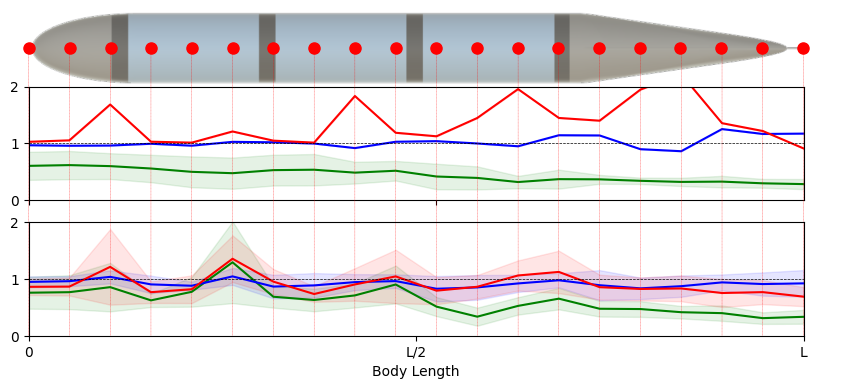

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation
ax[1].plot(mean_errors_train_lopinf, label="LOpInf", color='green')
ax[1].fill_between(range(len(mean_errors_train_lopinf)), mean_errors_train_lopinf - std_errors_train_lopinf, mean_errors_train_lopinf + std_errors_train_lopinf, color='green', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_dmdc, label="DMDc", color='blue')
ax[1].fill_between(range(len(mean_errors_train_dmdc)), mean_errors_train_dmdc - std_errors_train_dmdc, mean_errors_train_dmdc + std_errors_train_dmdc, color='blue', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_era, label="ERA", color='red')
ax[1].fill_between(range(len(mean_errors_train_era)), mean_errors_train_era - std_errors_train_era, mean_errors_train_era + std_errors_train_era, color='red', alpha=0.1, label="Standard Deviation")
ax[1].set_xticks([0, 10, 20])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 2])
ax[1].set_yticks([0, 1, 2])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all test trials with shaded region indicating standard deviation
ax[2].plot(mean_errors_test_lopinf, label="LOpInf", color='green')
ax[2].fill_between(range(len(mean_errors_test_lopinf)), mean_errors_test_lopinf - std_errors_test_lopinf, mean_errors_test_lopinf + std_errors_test_lopinf, color='green', alpha=0.1, label="Standard Deviation")
ax[2].plot(mean_errors_test_dmdc, label="DMDc", color='blue')
ax[2].fill_between(range(len(mean_errors_test_dmdc)), mean_errors_test_dmdc - std_errors_test_dmdc, mean_errors_test_dmdc + std_errors_test_dmdc, color='blue', alpha=0.1, label="Standard Deviation")
ax[2].plot(mean_errors_test_era, label="ERA", color='red')
ax[2].fill_between(range(len(mean_errors_test_era)), mean_errors_test_era - std_errors_test_era, mean_errors_test_era + std_errors_test_era, color='red', alpha=0.1, label="Standard Deviation")
ax[2].set_xlabel("Body Length")
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels(["0", "L/2", "L"])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 2])
ax[2].set_yticks([0, 1, 2])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# # Add a single y-axis label across the center of the bottom two subplots
# fig.text(0.04, 0.35, "Average Relative Error", va='center', rotation='vertical')

# Save svg
# plt.savefig(visualizationDir + "outputTrackingErrors_Spatial.svg", format='svg', dpi=1200)
ax[0].set_position([0.119, 0.555, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot to the halfway up the first subplot
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[2], color="red", linestyle='--', linewidth=0.2)
    ax[2].add_artist(con)


# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_feasibleEqual.svg", format='svg', dpi=1200)
# # Save as png
# plt.savefig(visualizationDir + "outputTrackingErrors_Spatial.png", format='png', dpi=1200)


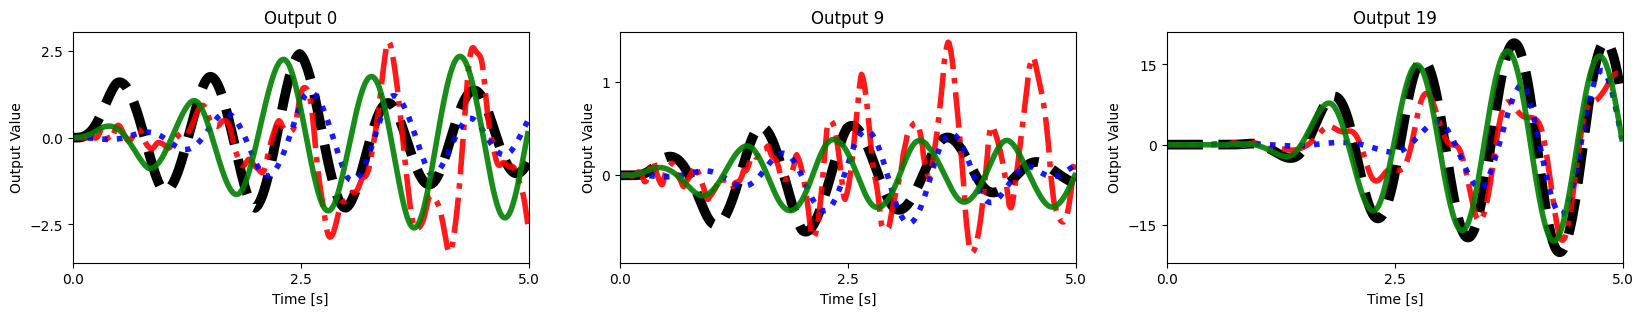

In [33]:
# Plot timeseries trajectories of references and outputs for a given trial with all three MPC models
test_trials_era = [502, 503, 504, 506, 507, 508, 509, 511]
test_trials_dmdc = [513, 515, 516, 518, 519, 520, 521, 523]
test_trials_lopinf = [201,203,209,216,219,223,230,236]
# Output indices to plot
output_indices = [39, 21, 1] # Descdending order of output indices so tail is on the right
# Define the trial to plot
trial_id = 0
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
# Read in ERA data
conn = get_db_connection()
data = fetch_trial_data(conn, test_trials_era[trial_id], n, 500)
conn.close()
simulation_timesteps_era = np.array([row[0] for row in data])
simulation_times_era = np.array([row[1] for row in data])
input_data_era = np.array([row[2] for row in data]).T
output_data_era = np.array([row[3] for row in data]).T
y_refs_era = np.array([row[4] for row in data]).T
x_hats_era = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_era = output_data_era
U_fom_era = input_data_era
Y0_fom_era = Y_fom_era[:,0]
# Center Y_fom about neutral position
Y_fom_era = Y_fom_era-Y0_fom_era[:,np.newaxis]
# Read in DMDc data
conn = get_db_connection()
data = fetch_trial_data(conn, test_trials_dmdc[trial_id], n, 500)
conn.close()
simulation_timesteps_dmdc = np.array([row[0] for row in data])
simulation_times_dmdc = np.array([row[1] for row in data])
input_data_dmdc = np.array([row[2] for row in data]).T
output_data_dmdc = np.array([row[3] for row in data]).T
y_refs_dmdc = np.array([row[4] for row in data]).T
x_hats_dmdc = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_dmdc = output_data_dmdc
U_fom_dmdc = input_data_dmdc
Y0_fom_dmdc = Y_fom_dmdc[:,0]
# Center Y_fom about neutral position
Y_fom_dmdc = Y_fom_dmdc-Y0_fom_dmdc[:,np.newaxis]
# Read in LOpInf data
conn = get_db_connection()
data = fetch_trial_data(conn, test_trials_lopinf[trial_id], n, 500)
conn.close()
simulation_timesteps_lopinf = np.array([row[0] for row in data])
simulation_times_lopinf = np.array([row[1] for row in data])
input_data_lopinf = np.array([row[2] for row in data]).T
output_data_lopinf = np.array([row[3] for row in data]).T
y_refs_lopinf = np.array([row[4] for row in data]).T
x_hats_lopinf = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_lopinf = output_data_lopinf
U_fom_lopinf = input_data_lopinf
Y0_fom_lopinf = Y_fom_lopinf[:,0]
# Center Y_fom about neutral position
Y_fom_lopinf = Y_fom_lopinf-Y0_fom_lopinf[:,np.newaxis]


# Plot the references and outputs for each model type at the specified output indices
simulation_times = simulation_times_era  # All models have the same time vector  
for i, output_index in enumerate(output_indices):
    # Plot ERA
    ax[i].plot(simulation_times, y_refs_era[output_index, :], label="Reference (ERA)", color='black', linestyle='--', linewidth=7)
    ax[i].plot(simulation_times, Y_fom_era[output_index, :], label="Output (ERA)", color='red', linewidth=4, linestyle='-.', alpha=0.9)
    # Plot DMDc
    ax[i].plot(simulation_times, Y_fom_dmdc[output_index, :], label="Output (DMDc)", color='blue', linewidth=4,linestyle=':' , alpha=0.9)
    # Plot LOpInf
    ax[i].plot(simulation_times, Y_fom_lopinf[output_index, :], label="Output (LOpInf)", color='green', linewidth=4,linestyle='-', alpha=0.9)
    

    # Set titles and labels
    ax[i].set_title(f"Output {19-(output_index-1)//2}")
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Output Value")
    ax[i].set_xlim([0, 5])
    ax[i].set_xticks([0, 2.5, 5])
    # Set only 3 y-ticks but make them adaptive to the plot range based on reference
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(3))
    
    

# Save as svg
plt.savefig(visualizationDir + "outputTrajectories_feasibleEqual_trial_" + str(trial_id) + ".svg", format='svg', dpi=1200)

(40, 500)


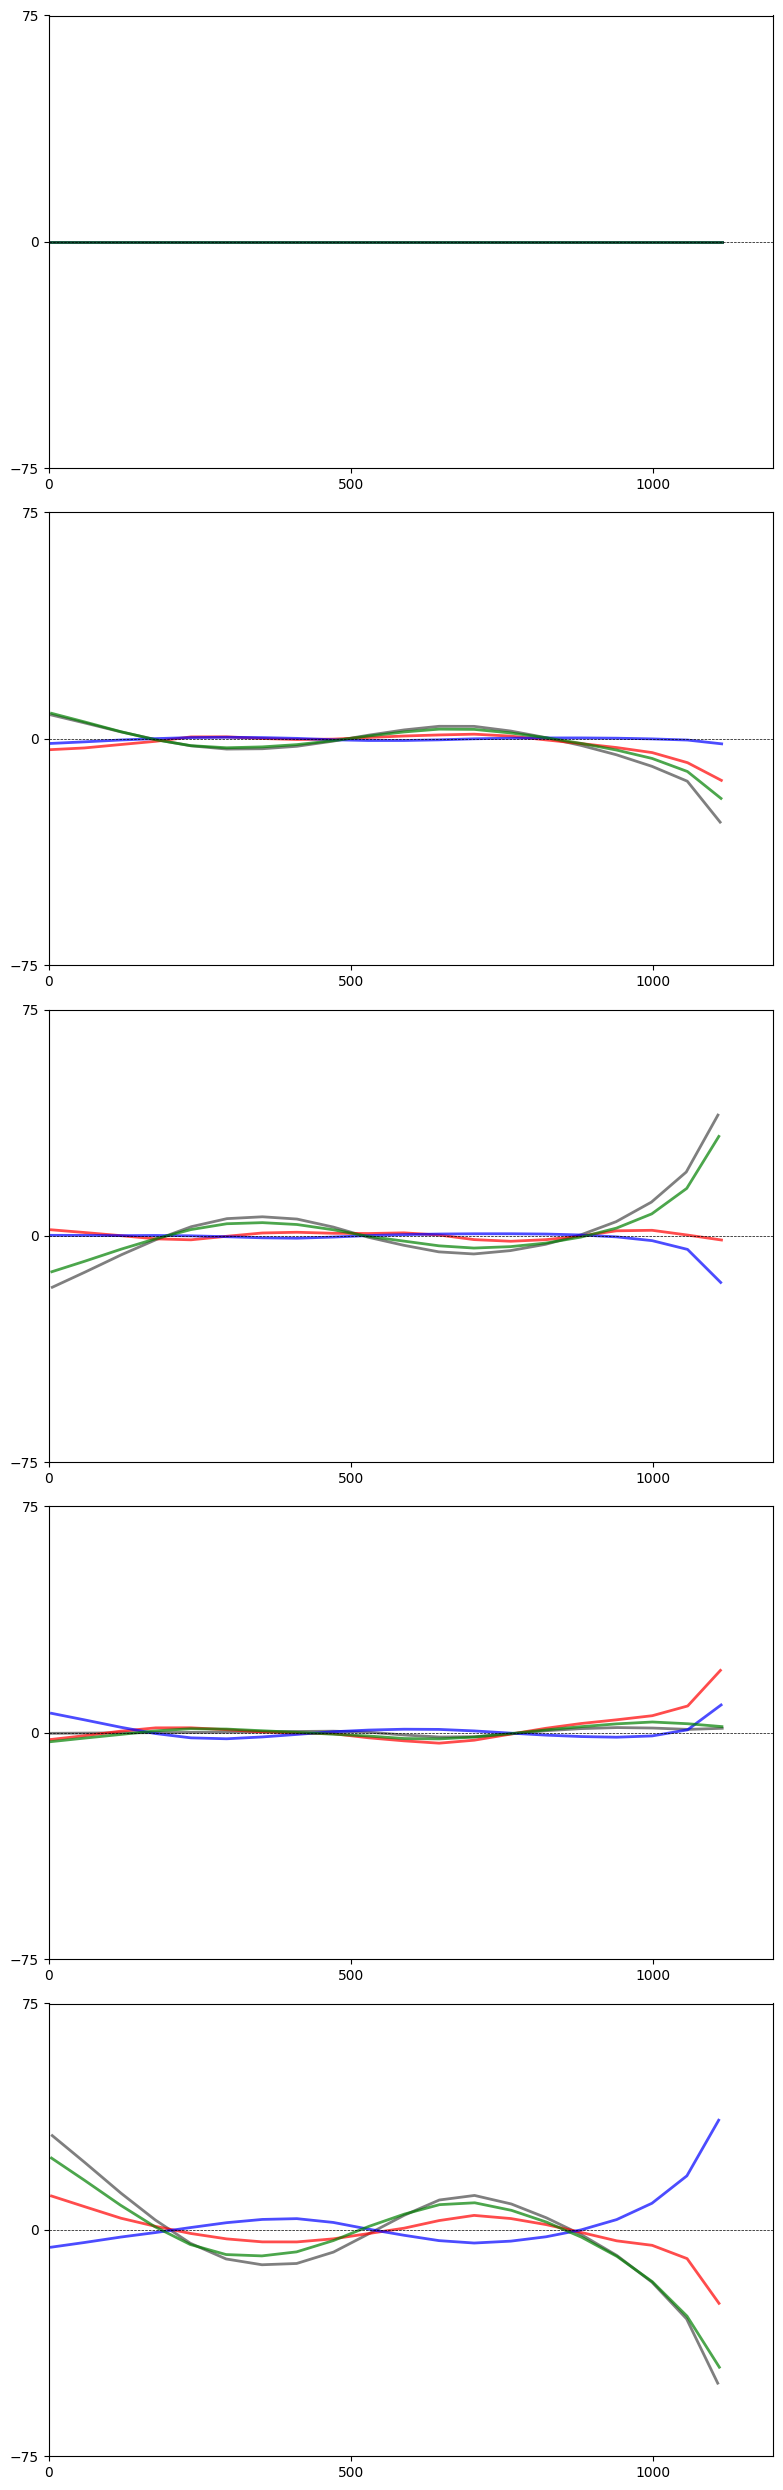

In [61]:
# Plot body shapes over time for the same trials above
test_trials_era = [502, 503, 504, 506, 507, 508, 509, 511]
test_trials_dmdc = [513, 515, 516, 518, 519, 520, 521, 523]
test_trials_lopinf = [201, 203, 209, 216, 219, 223, 230, 236]

trial_id = 6  # Choose which trial to plot

# setup parameters for snapshot plotting

numSnapshots = 5
startTimeStep = 0
lastTimestep = 499
snapshotTimesteps = np.linspace(startTimeStep, lastTimestep, numSnapshots, endpoint=True, dtype=int)
referenceSnapshots = np.zeros((40, numSnapshots))

lopinfSnapshots = np.zeros((40, numSnapshots))
dmdcSnapshots = np.zeros((40, numSnapshots))
eraSnapshots = np.zeros((40, numSnapshots))

# Grab trial indices from trials that match parameters
lopinfTrialInd = test_trials_lopinf[trial_id]
dmdcTrialInd = test_trials_dmdc[trial_id]
eraTrialInd = test_trials_era[trial_id]


# Read in snapshots from database for ERA
conn = get_db_connection()
data = fetch_trial_data(conn, eraTrialInd, 1, timesteps)
conn.close()
simulation_timesteps = np.array([row[0] for row in data])
simulation_times = np.array([row[1] for row in data])
output_data_era = np.array([row[3] for row in data]).T
y_refs_era = np.array([row[4] for row in data]).T
y0_era = output_data_era[:,0]
output_data_era[1:40:2] = output_data_era[1:40:2] - y0_era[1:40:2, np.newaxis]  # Uncenter output_data_era about neutral position
y_refs_era[0:40:2] = y_refs_era[0:40:2] + y0_era[0:40:2, np.newaxis]  # Uncenter y_refs_era about neutral position
# y_refs_era[1:40:2] = y_refs_era[1:40:2] + y0_era[1:40:2, np.newaxis]  # Uncenter y_refs_era about neutral position
print(np.shape(output_data_era))
# Read in snapshots from database for DMDc
conn = get_db_connection()
data = fetch_trial_data(conn, dmdcTrialInd, 1, timesteps)
conn.close()
simulation_timesteps = np.array([row[0] for row in data])
simulation_times = np.array([row[1] for row in data])
output_data_dmdc = np.array([row[3] for row in data]).T
y_refs_dmdc = np.array([row[4] for row in data]).T
y0_dmdc = output_data_dmdc[:,0]
output_data_dmdc[1:40:2] = output_data_dmdc[1:40:2] - y0_dmdc[1:40:2, np.newaxis]  # Uncenter output_data_dmdc about neutral position
y_refs_dmdc = y_refs_dmdc + y0_dmdc[:, np.newaxis]  # Uncenter y_refs_dmdc about neutral position
# Read in snapshots from database for LOpInf
conn = get_db_connection()
data = fetch_trial_data(conn, lopinfTrialInd, 1, timesteps)
conn.close()
simulation_timesteps = np.array([row[0] for row in data])
simulation_times = np.array([row[1] for row in data])
output_data_lopinf = np.array([row[3] for row in data]).T
y_refs_lopinf = np.array([row[4] for row in data]).T
y0_lopinf = output_data_lopinf[:,0]
output_data_lopinf[1:40:2] = output_data_lopinf[1:40:2] - y0_lopinf[1:40:2, np.newaxis]  # Uncenter output_data_lopinf about neutral position
y_refs_lopinf = y_refs_lopinf + y0_lopinf[:, np.newaxis]  # Uncenter y_refs_lopinf about neutral position

# Plot numSnapshots centerlines for each method
fig, ax = plt.subplots(numSnapshots,1, figsize=(12, 5*numSnapshots))
# Plot reference centerline
for i in range(numSnapshots):
    timestep = snapshotTimesteps[i]
    # Plot reference centerline
    refData_x = -np.flip(y_refs_era[0:40:2, timestep])
    refData_y = np.flip(y_refs_era[1:40:2, timestep])
    ax[i].plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=2)
    # Plot ERA centerline
    eraData_x = -np.flip(output_data_era[0:40:2, timestep])
    eraData_y = np.flip(output_data_era[1:40:2, timestep])
    # ax[1, i].plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax[i].plot(eraData_x, eraData_y, color='red', alpha=0.7, linewidth=2)
    # Plot DMDc centerline
    dmdcData_x = -np.flip(output_data_dmdc[0:40:2, timestep])
    dmdcData_y = np.flip(output_data_dmdc[1:40:2, timestep])
    # ax[2, i].plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax[i].plot(dmdcData_x, dmdcData_y, color='blue', alpha=0.7, linewidth=2)
    # Plot LOpInf centerline
    lopinfData_x = -np.flip(output_data_lopinf[0:40:2, timestep])
    lopinfData_y = np.flip(output_data_lopinf[1:40:2, timestep])
    # ax[3, i].plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax[i].plot(lopinfData_x, lopinfData_y, color='green', alpha=0.7, linewidth=2)

# Set axis limits and labels
aspect_ratio = 5.0 # vertical stretch
for j in range(numSnapshots):
    ax[j].set_xlim([0, 1200])
    ax[j].set_ylim([-75, 75])
    ax[j].set_aspect(aspect_ratio)
    ax[j].set_xticks([0, 500, 1000])
    ax[j].set_yticks([-75, 0, 75])
    ax[j].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax[j].axvline(x=0, color='black', linestyle='--', linewidth=0.5)

# Save the figure
plt.tight_layout()
plt.savefig(visualizationDir + f"feasibleTrajTracking_Snapshots_Trial{trial_id}.svg", format='svg', dpi=1200)

## Feasible Trajectory Tracking - Moderately Tail-focused Weights Across Body

In [140]:
# Trial Parameters

lopinf_trial_ids_train_equal = [214, 233, 237]
lopinf_trial_ids_train_tail = [360, 352, 358] 
lopinf_trial_ids_test_equal = [201, 203, 209, 216, 219, 223, 230, 236] 
lopinf_trial_ids_test_tail = [349, 350, 351, 353, 355, 356, 357, 359]
dmdc_trial_ids_train_equal = [291, 267] 
dmdc_trial_ids_train_tail = [348,341] 
dmdc_trial_ids_test_equal = [252, 254, 262, 269, 272, 276, 283, 290]
dmdc_trial_ids_test_tail = [338, 339, 340, 342, 343, 344, 345, 347]
era_trial_ids_train_equal = [335]
era_trial_ids_train_tail = [335]#[372]
era_trial_ids_test_equal = [297, 299, 305, 311, 313, 316, 320, 327, 331, 334]
era_trial_ids_test_tail = [362, 363, 364, 365, 366, 367, 368, 369, 370, 371]

trial_id = lopinf_trial_ids_train_equal[0]
timesteps = 500
n = 1

In [141]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 18


### Relative Error Over Body Length 

#### Training Data Trials

In [142]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_equal = np.zeros((20, len(lopinf_trial_ids_train_equal)))
lopinf_rel_errors_avg_train_tail = np.zeros((20, len(lopinf_trial_ids_train_tail)))
lopinf_rel_errors_avg_test_equal = np.zeros((20, len(lopinf_trial_ids_test_equal)))
lopinf_rel_errors_avg_test_tail = np.zeros((20, len(lopinf_trial_ids_test_tail)))
dmdc_rel_errors_avg_train_equal = np.zeros((20, len(dmdc_trial_ids_train_equal)))
dmdc_rel_errors_avg_train_tail = np.zeros((20, len(dmdc_trial_ids_train_tail)))
dmdc_rel_errors_avg_test_equal = np.zeros((20, len(dmdc_trial_ids_test_equal)))
dmdc_rel_errors_avg_test_tail = np.zeros((20, len(dmdc_trial_ids_test_tail)))
era_rel_errors_avg_train_equal = np.zeros((20, len(era_trial_ids_train_equal)))
era_rel_errors_avg_train_tail = np.zeros((20, len(era_trial_ids_train_tail)))
era_rel_errors_avg_test_equal = np.zeros((20, len(era_trial_ids_test_equal)))
era_rel_errors_avg_test_tail = np.zeros((20, len(era_trial_ids_test_tail)))

lopinf_avgFullBody_rel_errors_tailModerate_train = np.zeros((1, len(lopinf_trial_ids_train_tail)))
lopinf_avgFullBody_rel_errors_tailModerate_test = np.zeros((1, len(lopinf_trial_ids_test_tail)))
era_avgFullBody_rel_errors_tailModerate_train = np.zeros((1, len(era_trial_ids_train_tail)))
dmdc_avgFullBody_rel_errors_tailModerate_test = np.zeros((1, len(dmdc_trial_ids_test_tail)))
dmdc_avgFullBody_rel_errors_tailModerate_train = np.zeros((1, len(dmdc_trial_ids_train_tail)))
era_avgFullBody_rel_errors_tailModerate_test = np.zeros((1, len(era_trial_ids_test_tail)))

### Calculate statistics for LOpInf
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_equal)):
    trial_id = lopinf_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)

# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_tail)):
    trial_id = lopinf_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    lopinf_avgFullBody_rel_errors_tailModerate_train[0, trialInd] = np.linalg.norm(Y_fom-y_refs)/np.linalg.norm(y_refs)


# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)

# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    lopinf_avgFullBody_rel_errors_tailModerate_test[0, trialInd] = np.linalg.norm(Y_fom-y_refs)/np.linalg.norm(y_refs)

mean_errors_train_lopinf_equal = np.mean(lopinf_rel_errors_avg_train_equal, axis=1)
mean_errors_train_lopinf_tail = np.mean(lopinf_rel_errors_avg_train_tail, axis=1)
std_errors_train_lopinf_equal = np.std(lopinf_rel_errors_avg_train_equal, axis=1)
std_errors_train_lopinf_tail = np.std(lopinf_rel_errors_avg_train_tail, axis=1)
mean_errors_test_lopinf_equal = np.mean(lopinf_rel_errors_avg_test_equal, axis=1)
mean_errors_test_lopinf_tail = np.mean(lopinf_rel_errors_avg_test_tail, axis=1)
std_errors_test_lopinf_equal = np.std(lopinf_rel_errors_avg_test_equal, axis=1)
std_errors_test_lopinf_tail = np.std(lopinf_rel_errors_avg_test_tail, axis=1)

### Calculate statistics for DMDc
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_equal)):
    trial_id = dmdc_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_tail)):
    trial_id = dmdc_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    dmdc_avgFullBody_rel_errors_tailModerate_train[0, trialInd] = np.linalg.norm(Y_fom-y_refs)/np.linalg.norm(y_refs)
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    dmdc_avgFullBody_rel_errors_tailModerate_test[0, trialInd] = np.linalg.norm(Y_fom-y_refs)/np.linalg.norm(y_refs)
mean_errors_train_dmdc_equal = np.mean(dmdc_rel_errors_avg_train_equal, axis=1)
mean_errors_train_dmdc_tail = np.mean(dmdc_rel_errors_avg_train_tail, axis=1)
std_errors_train_dmdc_equal = np.std(dmdc_rel_errors_avg_train_equal, axis=1)
std_errors_train_dmdc_tail = np.std(dmdc_rel_errors_avg_train_tail, axis=1)
mean_errors_test_dmdc_equal = np.mean(dmdc_rel_errors_avg_test_equal, axis=1)
mean_errors_test_dmdc_tail = np.mean(dmdc_rel_errors_avg_test_tail, axis=1)
std_errors_test_dmdc_equal = np.std(dmdc_rel_errors_avg_test_equal, axis=1)
std_errors_test_dmdc_tail = np.std(dmdc_rel_errors_avg_test_tail, axis=1)
### Calculate statistics for ERA
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_train_equal)):
    trial_id = era_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_train_tail)):
    trial_id = era_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    era_avgFullBody_rel_errors_tailModerate_train[0, trialInd] = np.linalg.norm(Y_fom-y_refs)/np.linalg.norm(y_refs)
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    era_avgFullBody_rel_errors_tailModerate_test[0, trialInd] = np.linalg.norm(Y_fom-y_refs)/np.linalg.norm(y_refs)
mean_errors_train_era_equal = np.mean(era_rel_errors_avg_train_equal, axis=1)
mean_errors_train_era_tail = np.mean(era_rel_errors_avg_train_tail, axis=1)
std_errors_train_era_equal = np.std(era_rel_errors_avg_train_equal, axis=1)
std_errors_train_era_tail = np.std(era_rel_errors_avg_train_tail, axis=1)
mean_errors_test_era_equal = np.mean(era_rel_errors_avg_test_equal, axis=1)
mean_errors_test_era_tail = np.mean(era_rel_errors_avg_test_tail, axis=1)
std_errors_test_era_equal = np.std(era_rel_errors_avg_test_equal, axis=1)
std_errors_test_era_tail = np.std(era_rel_errors_avg_test_tail, axis=1)
#


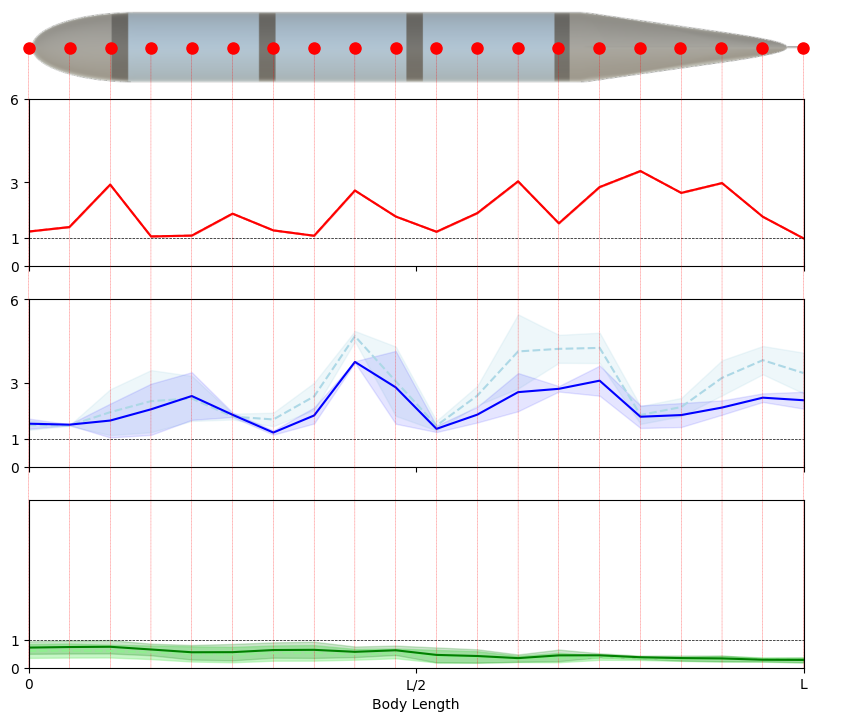

In [143]:
# Plot Training Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_equal)), mean_errors_train_era_equal - std_errors_train_era_equal, mean_errors_train_era_equal + std_errors_train_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_era_tail, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_train_era_tail)), mean_errors_train_era_tail - std_errors_train_era_tail, mean_errors_train_era_tail + std_errors_train_era_tail, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_equal)), mean_errors_train_dmdc_equal - std_errors_train_dmdc_equal, mean_errors_train_dmdc_equal + std_errors_train_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_train_dmdc_tail, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_train_dmdc_tail)), mean_errors_train_dmdc_tail - std_errors_train_dmdc_tail, mean_errors_train_dmdc_tail + std_errors_train_dmdc_tail, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_train_lopinf_equal)), mean_errors_train_lopinf_equal - std_errors_train_lopinf_equal, mean_errors_train_lopinf_equal + std_errors_train_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_train_lopinf_tail, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_train_lopinf_tail)), mean_errors_train_lopinf_tail - std_errors_train_lopinf_tail, mean_errors_train_lopinf_tail + std_errors_train_lopinf_tail, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 6])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Train.svg", format='svg', dpi=1200)



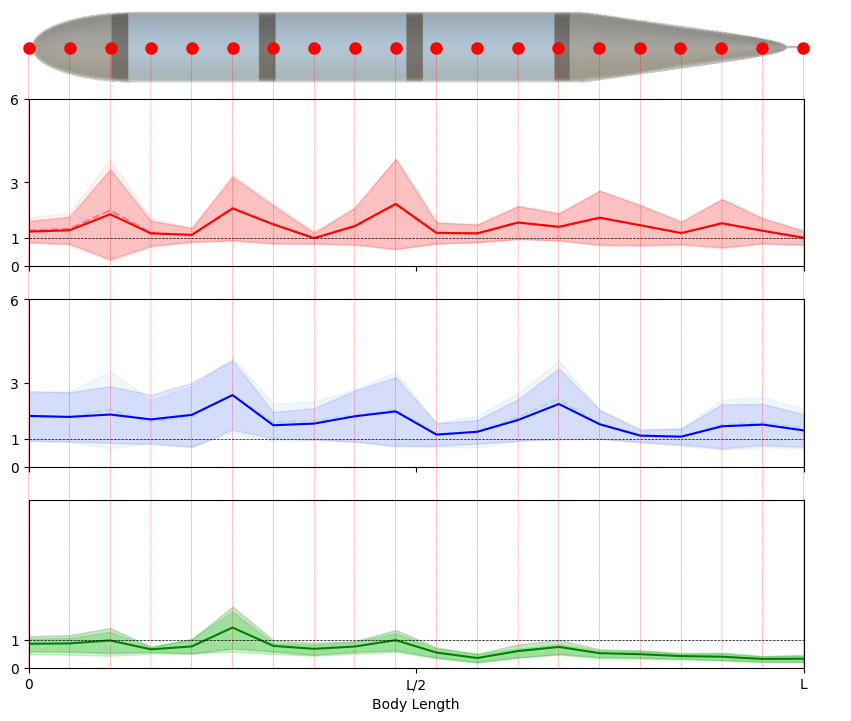

In [144]:
# Plot Test Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_equal)), mean_errors_test_era_equal - std_errors_test_era_equal, mean_errors_test_era_equal + std_errors_test_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_test_era_tail, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_test_era_tail)), mean_errors_test_era_tail - std_errors_test_era_tail, mean_errors_test_era_tail + std_errors_test_era_tail, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_equal)), mean_errors_test_dmdc_equal - std_errors_test_dmdc_equal, mean_errors_test_dmdc_equal + std_errors_test_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_test_dmdc_tail, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_test_dmdc_tail)), mean_errors_test_dmdc_tail - std_errors_test_dmdc_tail, mean_errors_test_dmdc_tail + std_errors_test_dmdc_tail, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_equal)), mean_errors_test_lopinf_equal - std_errors_test_lopinf_equal, mean_errors_test_lopinf_equal + std_errors_test_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_test_lopinf_tail, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_test_lopinf_tail)), mean_errors_test_lopinf_tail - std_errors_test_lopinf_tail, mean_errors_test_lopinf_tail + std_errors_test_lopinf_tail, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 6])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Test.svg", format='svg', dpi=1200)



## Feasible Trajectory Tracking - Heavily Tail-focused Weights Across Body

In [145]:
# Trial Parameters

lopinf_trial_ids_train_equal = [214, 233, 237]
lopinf_trial_ids_train_tail = [419,417,412] 
lopinf_trial_ids_test_equal = [201, 203, 209, 216, 219, 223, 230, 236] 
lopinf_trial_ids_test_tail = [409,410,411,413,414,415,416,418]
dmdc_trial_ids_train_equal = [291, 267] 
dmdc_trial_ids_train_tail = [388,395] 
dmdc_trial_ids_test_equal = [252, 254, 262, 269, 272, 276, 283, 290]
dmdc_trial_ids_test_tail = [385,386,387,389,390,391,392,393,394] 
era_trial_ids_train_equal = [335]
era_trial_ids_train_tail = [335]#[372]
era_trial_ids_test_equal = [297, 299, 305, 311, 313, 316, 320, 327, 331, 334]
era_trial_ids_test_tail = [362, 363, 364, 365, 366, 367, 368, 369, 370, 371]

trial_id = lopinf_trial_ids_train_equal[0]
timesteps = 500
n = 1

In [146]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 18


### Relative Error Over Body Length 

#### Training Data Trials

In [147]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_equal = np.zeros((20, len(lopinf_trial_ids_train_equal)))
lopinf_rel_errors_avg_train_tail = np.zeros((20, len(lopinf_trial_ids_train_tail)))
lopinf_rel_errors_avg_test_equal = np.zeros((20, len(lopinf_trial_ids_test_equal)))
lopinf_rel_errors_avg_test_tail = np.zeros((20, len(lopinf_trial_ids_test_tail)))
dmdc_rel_errors_avg_train_equal = np.zeros((20, len(dmdc_trial_ids_train_equal)))
dmdc_rel_errors_avg_train_tail = np.zeros((20, len(dmdc_trial_ids_train_tail)))
dmdc_rel_errors_avg_test_equal = np.zeros((20, len(dmdc_trial_ids_test_equal)))
dmdc_rel_errors_avg_test_tail = np.zeros((20, len(dmdc_trial_ids_test_tail)))
era_rel_errors_avg_train_equal = np.zeros((20, len(era_trial_ids_train_equal)))
era_rel_errors_avg_train_tail = np.zeros((20, len(era_trial_ids_train_tail)))
era_rel_errors_avg_test_equal = np.zeros((20, len(era_trial_ids_test_equal)))
era_rel_errors_avg_test_tail = np.zeros((20, len(era_trial_ids_test_tail)))

lopinf_avgFullBody_rel_errors_tailHeavy_train = np.zeros((1, len(lopinf_trial_ids_train_tail)))
lopinf_avgFullBody_rel_errors_tailHeavy_test = np.zeros((1, len(lopinf_trial_ids_test_tail)))
dmdc_avgFullBody_rel_errors_tailHeavy_train = np.zeros((1, len(dmdc_trial_ids_train_tail)))
dmdc_avgFullBody_rel_errors_tailHeavy_test = np.zeros((1, len(dmdc_trial_ids_test_tail)))
era_avgFullBody_rel_errors_tailHeavy_train = np.zeros((1, len(era_trial_ids_train_tail)))
era_avgFullBody_rel_errors_tailHeavy_test = np.zeros((1, len(era_trial_ids_test_tail)))

### Calculate statistics for LOpInf
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_equal)):
    trial_id = lopinf_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)

# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_tail)):
    trial_id = lopinf_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    lopinf_avgFullBody_rel_errors_tailHeavy_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')


# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)

# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    lopinf_avgFullBody_rel_errors_tailHeavy_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')

mean_errors_train_lopinf_equal = np.mean(lopinf_rel_errors_avg_train_equal, axis=1)
mean_errors_train_lopinf_tail = np.mean(lopinf_rel_errors_avg_train_tail, axis=1)
std_errors_train_lopinf_equal = np.std(lopinf_rel_errors_avg_train_equal, axis=1)
std_errors_train_lopinf_tail = np.std(lopinf_rel_errors_avg_train_tail, axis=1)
mean_errors_test_lopinf_equal = np.mean(lopinf_rel_errors_avg_test_equal, axis=1)
mean_errors_test_lopinf_tail = np.mean(lopinf_rel_errors_avg_test_tail, axis=1)
std_errors_test_lopinf_equal = np.std(lopinf_rel_errors_avg_test_equal, axis=1)
std_errors_test_lopinf_tail = np.std(lopinf_rel_errors_avg_test_tail, axis=1)

### Calculate statistics for DMDc
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_equal)):
    trial_id = dmdc_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_tail)):
    trial_id = dmdc_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    dmdc_avgFullBody_rel_errors_tailHeavy_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    dmdc_avgFullBody_rel_errors_tailHeavy_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_dmdc_equal = np.mean(dmdc_rel_errors_avg_train_equal, axis=1)
mean_errors_train_dmdc_tail = np.mean(dmdc_rel_errors_avg_train_tail, axis=1)
std_errors_train_dmdc_equal = np.std(dmdc_rel_errors_avg_train_equal, axis=1)
std_errors_train_dmdc_tail = np.std(dmdc_rel_errors_avg_train_tail, axis=1)
mean_errors_test_dmdc_equal = np.mean(dmdc_rel_errors_avg_test_equal, axis=1)
mean_errors_test_dmdc_tail = np.mean(dmdc_rel_errors_avg_test_tail, axis=1)
std_errors_test_dmdc_equal = np.std(dmdc_rel_errors_avg_test_equal, axis=1)
std_errors_test_dmdc_tail = np.std(dmdc_rel_errors_avg_test_tail, axis=1)
### Calculate statistics for ERA
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_train_equal)):
    trial_id = era_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_train_tail)):
    trial_id = era_trial_ids_train_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    era_avgFullBody_rel_errors_tailHeavy_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_test_tail)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_tail[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_tail[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    era_avgFullBody_rel_errors_tailHeavy_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_era_equal = np.mean(era_rel_errors_avg_train_equal, axis=1)
mean_errors_train_era_tail = np.mean(era_rel_errors_avg_train_tail, axis=1)
std_errors_train_era_equal = np.std(era_rel_errors_avg_train_equal, axis=1)
std_errors_train_era_tail = np.std(era_rel_errors_avg_train_tail, axis=1)
mean_errors_test_era_equal = np.mean(era_rel_errors_avg_test_equal, axis=1)
mean_errors_test_era_tail = np.mean(era_rel_errors_avg_test_tail, axis=1)
std_errors_test_era_equal = np.std(era_rel_errors_avg_test_equal, axis=1)
std_errors_test_era_tail = np.std(era_rel_errors_avg_test_tail, axis=1)
#


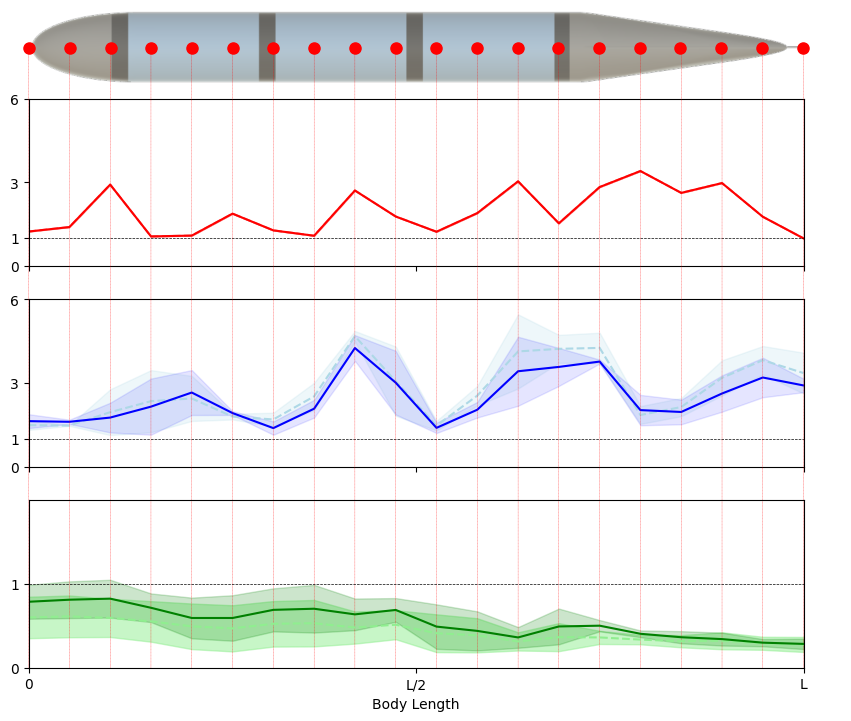

In [148]:
# Plot Training Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_equal)), mean_errors_train_era_equal - std_errors_train_era_equal, mean_errors_train_era_equal + std_errors_train_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_era_tail, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_train_era_tail)), mean_errors_train_era_tail - std_errors_train_era_tail, mean_errors_train_era_tail + std_errors_train_era_tail, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_equal)), mean_errors_train_dmdc_equal - std_errors_train_dmdc_equal, mean_errors_train_dmdc_equal + std_errors_train_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_train_dmdc_tail, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_train_dmdc_tail)), mean_errors_train_dmdc_tail - std_errors_train_dmdc_tail, mean_errors_train_dmdc_tail + std_errors_train_dmdc_tail, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_train_lopinf_equal)), mean_errors_train_lopinf_equal - std_errors_train_lopinf_equal, mean_errors_train_lopinf_equal + std_errors_train_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_train_lopinf_tail, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_train_lopinf_tail)), mean_errors_train_lopinf_tail - std_errors_train_lopinf_tail, mean_errors_train_lopinf_tail + std_errors_train_lopinf_tail, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Train.svg", format='svg', dpi=1200)



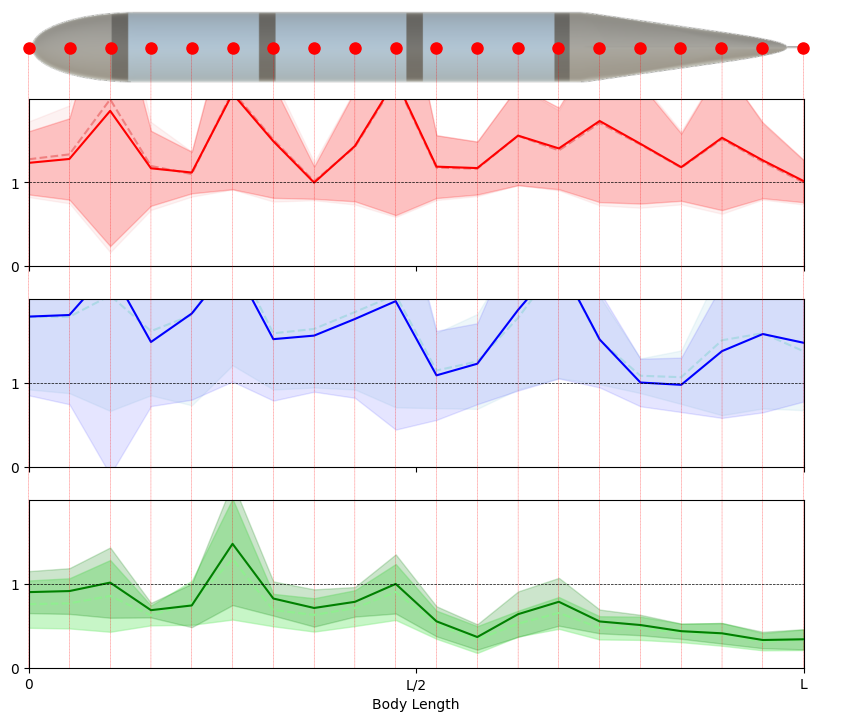

In [149]:
# Plot Test Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_equal)), mean_errors_test_era_equal - std_errors_test_era_equal, mean_errors_test_era_equal + std_errors_test_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_test_era_tail, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_test_era_tail)), mean_errors_test_era_tail - std_errors_test_era_tail, mean_errors_test_era_tail + std_errors_test_era_tail, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 2])
ax[1].set_yticks([0, 1])#, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_equal)), mean_errors_test_dmdc_equal - std_errors_test_dmdc_equal, mean_errors_test_dmdc_equal + std_errors_test_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_test_dmdc_tail, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_test_dmdc_tail)), mean_errors_test_dmdc_tail - std_errors_test_dmdc_tail, mean_errors_test_dmdc_tail + std_errors_test_dmdc_tail, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 2]) #6
ax[2].set_yticks([0, 1])#, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_equal)), mean_errors_test_lopinf_equal - std_errors_test_lopinf_equal, mean_errors_test_lopinf_equal + std_errors_test_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_test_lopinf_tail, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_test_lopinf_tail)), mean_errors_test_lopinf_tail - std_errors_test_lopinf_tail, mean_errors_test_lopinf_tail + std_errors_test_lopinf_tail, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Test.svg", format='svg', dpi=1200)



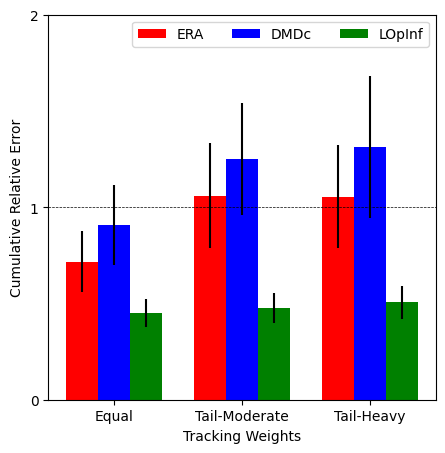

In [150]:
# Bar plot of average full-body relative errors (and stds as error bars) for each method on test data where bars are colored by method and grouped by tail-focused or equal weights
fig, ax = plt.subplots(figsize=(5, 5))
# Define the data for the bar plot
methods = ['LOpInf', 'DMDc', 'ERA']
groups = ['Equal', 'Tail-Moderate', 'Tail-Heavy']
equal_weights_errors_test_means = [era_avgFullBody_rel_errors_equal_test.mean(), dmdc_avgFullBody_rel_errors_equal_test.mean(), lopinf_avgFullBody_rel_errors_equal_test.mean()]
equal_weights_errors_test_stds = [era_avgFullBody_rel_errors_equal_test.std(), dmdc_avgFullBody_rel_errors_equal_test.std(), lopinf_avgFullBody_rel_errors_equal_test.std()]
tail_moderate_errors_test_means = [era_avgFullBody_rel_errors_tailModerate_test.mean(), dmdc_avgFullBody_rel_errors_tailModerate_test.mean(), lopinf_avgFullBody_rel_errors_tailModerate_test.mean()]
tail_moderate_errors_test_stds = [era_avgFullBody_rel_errors_tailModerate_test.std(), dmdc_avgFullBody_rel_errors_tailModerate_test.std(), lopinf_avgFullBody_rel_errors_tailModerate_test.std()]
tail_heavy_errors_test_means = [era_avgFullBody_rel_errors_tailHeavy_test.mean(), dmdc_avgFullBody_rel_errors_tailHeavy_test.mean(), lopinf_avgFullBody_rel_errors_tailHeavy_test.mean()]
tail_heavy_errors_test_stds = [era_avgFullBody_rel_errors_tailHeavy_test.std(), dmdc_avgFullBody_rel_errors_tailHeavy_test.std(), lopinf_avgFullBody_rel_errors_tailHeavy_test.std()]

# Define the x locations for the bars
x = np.arange(len(groups))  # the label locations
width = 0.25  # the width of the bars
# Create the bars for each method
bars1 = ax.bar(x - width, [equal_weights_errors_test_means[0],tail_moderate_errors_test_means[0], tail_heavy_errors_test_means[0]], width, yerr=[equal_weights_errors_test_stds[0],tail_moderate_errors_test_stds[0], tail_heavy_errors_test_stds[0]], label='ERA', color='red')
bars2 = ax.bar(x, [equal_weights_errors_test_means[1],tail_moderate_errors_test_means[1], tail_heavy_errors_test_means[1]], width, yerr=[equal_weights_errors_test_stds[1],tail_moderate_errors_test_stds[1], tail_heavy_errors_test_stds[1]], label='DMDc', color='blue')
bars3 = ax.bar(x + width, [equal_weights_errors_test_means[2],tail_moderate_errors_test_means[2], tail_heavy_errors_test_means[2]], width, yerr=[equal_weights_errors_test_stds[2],tail_moderate_errors_test_stds[2], tail_heavy_errors_test_stds[2]], label='LOpInf', color='green')

# Draw horizontal dotted line at y=1.0
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Tracking Weights')
ax.set_ylabel('Cumulative Relative Error')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_ylim([0, 2])
ax.set_yticks([0,1,2])
# Horizontal legend
ax.legend(loc='upper center', bbox_to_anchor=(0.6, 1), ncol=3)
# Save the figure
plt.savefig(visualizationDir + "outputTrackingErrors_FullBody_TailWeighting_Test.svg", format='svg', dpi=1200)

## Feasible Trajectory Tracking - Posterior-Focused Weights (Redo)


In [151]:
# Trial Parameters

lopinf_trial_ids_train_equal = [237, 233, 214]
lopinf_trial_ids_train_posterior = [728, 726, 719] #[714, 712, 707] 
lopinf_trial_ids_test_equal = [201, 203, 209, 216, 219, 223, 230, 236]
lopinf_trial_ids_test_posterior = [715, 716, 718, 721, 722, 723, 754, 727] #[704, 705, 706, 708, 709, 710, 711, 713]
dmdc_trial_ids_train_equal = [525] 
dmdc_trial_ids_train_posterior = [753] #[703] 
dmdc_trial_ids_test_equal = [513, 515, 516, 518, 519, 520, 521, 523]
dmdc_trial_ids_test_posterior = [743, 744, 745, 747, 748, 749, 750, 752] #[692, 693, 694, 696, 698, 699, 700, 702] 
era_trial_ids_train_equal = [512]
era_trial_ids_train_posterior = [741]#[691]
era_trial_ids_test_equal = [502, 503, 504, 506, 507, 508, 509, 511]
era_trial_ids_test_posterior = [730, 731, 732, 734, 735, 736, 738, 740]#[680, 682, 685, 686, 687, 688, 690]

trial_id = lopinf_trial_ids_train_equal[0]
timesteps = 500
n = 1

In [152]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 18


### Relative Error Over Body Length 

#### Training Data Trials

In [153]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_equal = np.zeros((20, len(lopinf_trial_ids_train_equal)))
lopinf_rel_errors_avg_train_posterior = np.zeros((20, len(lopinf_trial_ids_train_posterior)))
lopinf_rel_errors_avg_test_equal = np.zeros((20, len(lopinf_trial_ids_test_equal)))
lopinf_rel_errors_avg_test_posterior = np.zeros((20, len(lopinf_trial_ids_test_posterior)))
dmdc_rel_errors_avg_train_equal = np.zeros((20, len(dmdc_trial_ids_train_equal)))
dmdc_rel_errors_avg_train_posterior = np.zeros((20, len(dmdc_trial_ids_train_posterior)))
dmdc_rel_errors_avg_test_equal = np.zeros((20, len(dmdc_trial_ids_test_equal)))
dmdc_rel_errors_avg_test_posterior = np.zeros((20, len(dmdc_trial_ids_test_posterior)))
era_rel_errors_avg_train_equal = np.zeros((20, len(era_trial_ids_train_equal)))
era_rel_errors_avg_train_posterior = np.zeros((20, len(era_trial_ids_train_posterior)))
era_rel_errors_avg_test_equal = np.zeros((20, len(era_trial_ids_test_equal)))
era_rel_errors_avg_test_posterior = np.zeros((20, len(era_trial_ids_test_posterior)))

lopinf_avgFullBody_rel_errors_posterior_train = np.zeros((1, len(lopinf_trial_ids_train_posterior)))
lopinf_avgFullBody_rel_errors_posterior_test = np.zeros((1, len(lopinf_trial_ids_test_posterior)))
dmdc_avgFullBody_rel_errors_posterior_train = np.zeros((1, len(dmdc_trial_ids_train_posterior)))
dmdc_avgFullBody_rel_errors_posterior_test = np.zeros((1, len(dmdc_trial_ids_test_posterior)))
era_avgFullBody_rel_errors_posterior_train = np.zeros((1, len(era_trial_ids_train_posterior)))
era_avgFullBody_rel_errors_posterior_test = np.zeros((1, len(era_trial_ids_test_posterior)))

### Calculate statistics for LOpInf
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_equal)):
    trial_id = lopinf_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)

# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_train_posterior)):
    trial_id = lopinf_trial_ids_train_posterior[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_posterior[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    lopinf_avgFullBody_rel_errors_posterior_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:])


# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)

# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(lopinf_trial_ids_test_posterior)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_posterior[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_posterior[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    lopinf_avgFullBody_rel_errors_posterior_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:])

mean_errors_train_lopinf_equal = np.mean(lopinf_rel_errors_avg_train_equal, axis=1)
mean_errors_train_lopinf_posterior = np.mean(lopinf_rel_errors_avg_train_posterior, axis=1)
std_errors_train_lopinf_equal = np.std(lopinf_rel_errors_avg_train_equal, axis=1)
std_errors_train_lopinf_posterior = np.std(lopinf_rel_errors_avg_train_posterior, axis=1)
mean_errors_test_lopinf_equal = np.mean(lopinf_rel_errors_avg_test_equal, axis=1)
mean_errors_test_lopinf_posterior = np.mean(lopinf_rel_errors_avg_test_posterior, axis=1)
std_errors_test_lopinf_equal = np.std(lopinf_rel_errors_avg_test_equal, axis=1)
std_errors_test_lopinf_posterior = np.std(lopinf_rel_errors_avg_test_posterior, axis=1)

### Calculate statistics for DMDc
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_equal)):
    trial_id = dmdc_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_train_posterior)):
    trial_id = dmdc_trial_ids_train_posterior[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_posterior[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    dmdc_avgFullBody_rel_errors_posterior_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:])
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(dmdc_trial_ids_test_posterior)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_posterior[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_posterior[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    dmdc_avgFullBody_rel_errors_posterior_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_dmdc_equal = np.mean(dmdc_rel_errors_avg_train_equal, axis=1)
mean_errors_train_dmdc_posterior = np.mean(dmdc_rel_errors_avg_train_posterior, axis=1)
std_errors_train_dmdc_equal = np.std(dmdc_rel_errors_avg_train_equal, axis=1)
std_errors_train_dmdc_posterior = np.std(dmdc_rel_errors_avg_train_posterior, axis=1)
mean_errors_test_dmdc_equal = np.mean(dmdc_rel_errors_avg_test_equal, axis=1)
mean_errors_test_dmdc_posterior = np.mean(dmdc_rel_errors_avg_test_posterior, axis=1)
std_errors_test_dmdc_equal = np.std(dmdc_rel_errors_avg_test_equal, axis=1)
std_errors_test_dmdc_posterior = np.std(dmdc_rel_errors_avg_test_posterior, axis=1)
### Calculate statistics for ERA
# Compute relative errors for each training trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_train_equal)):
    trial_id = era_trial_ids_train_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute relative errors for each training trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_train_posterior)):
    trial_id = era_trial_ids_train_posterior[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_posterior[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    era_avgFullBody_rel_errors_posterior_train[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:])
# Compute relative errors for each test trial with equal weights across fish body
for trialInd in range(len(era_trial_ids_test_equal)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_equal[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_equal[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute relative errors for each test trial with tail-focused weights across fish body
for trialInd in range(len(era_trial_ids_test_posterior)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_posterior[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_posterior[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    era_avgFullBody_rel_errors_posterior_test[0, trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:])
mean_errors_train_era_equal = np.mean(era_rel_errors_avg_train_equal, axis=1)
mean_errors_train_era_posterior = np.mean(era_rel_errors_avg_train_posterior, axis=1)
std_errors_train_era_equal = np.std(era_rel_errors_avg_train_equal, axis=1)
std_errors_train_era_posterior = np.std(era_rel_errors_avg_train_posterior, axis=1)
mean_errors_test_era_equal = np.mean(era_rel_errors_avg_test_equal, axis=1)
mean_errors_test_era_posterior = np.mean(era_rel_errors_avg_test_posterior, axis=1)
std_errors_test_era_equal = np.std(era_rel_errors_avg_test_equal, axis=1)
std_errors_test_era_posterior = np.std(era_rel_errors_avg_test_posterior, axis=1)
#


In [154]:
mean_errors_train_era_equal

array([1.02499893, 1.05078711, 1.68342695, 1.02690639, 1.01046842,
       1.20759574, 1.04553648, 1.01063516, 1.83373587, 1.18476889,
       1.12247673, 1.44599449, 1.9558767 , 1.44631272, 1.39805394,
       1.94712377, 2.2186497 , 1.35423669, 1.21553737, 0.90782824])

In [155]:
# lopinf_rel_errors_avg_train_equal 
# lopinf_rel_errors_avg_train_posterior
# lopinf_rel_errors_avg_test_equal
lopinf_rel_errors_avg_test_posterior
# dmdc_rel_errors_avg_train_equal
# dmdc_rel_errors_avg_train_posterior
# dmdc_rel_errors_avg_test_equal
# dmdc_rel_errors_avg_test_posterior
# era_rel_errors_avg_train_equal
# era_rel_errors_avg_train_posterior
# era_rel_errors_avg_test_equal
# era_rel_errors_avg_test_posterior
# lopinf_avgFullBody_rel_errors_posterior_train
# lopinf_avgFullBody_rel_errors_posterior_test
# dmdc_avgFullBody_rel_errors_posterior_train
# dmdc_avgFullBody_rel_errors_posterior_test
# era_avgFullBody_rel_errors_posterior_train
# era_avgFullBody_rel_errors_posterior_test

array([[1.37202713, 0.9473249 , 0.55245463, 1.00623132, 0.95110528,
        0.90457253, 0.338329  , 1.04935267],
       [1.444642  , 0.87694315, 0.57282634, 1.10246812, 0.91439776,
        0.86377538, 0.33666306, 1.13097637],
       [1.60993505, 0.74229383, 0.61996292, 1.77412614, 0.78256685,
        0.78639945, 0.3542631 , 1.49158511],
       [0.62751076, 0.48913768, 0.73790212, 0.53970307, 0.77127458,
        0.64111733, 0.69915252, 0.69249747],
       [1.18962666, 0.47389624, 0.90006453, 0.85735932, 0.95289812,
        0.4016647 , 0.51050551, 0.92768958],
       [1.72102008, 2.85943936, 0.47843502, 2.04032709, 0.8555461 ,
        2.03968082, 0.32731555, 1.89363531],
       [0.93487006, 1.03381415, 0.73353252, 0.88518705, 0.65793002,
        0.98617731, 0.31137975, 0.89225383],
       [0.43761834, 0.74688688, 0.85796484, 0.45778696, 1.05116912,
        0.82038445, 0.36360825, 0.64576707],
       [0.88814037, 0.5932245 , 0.87384386, 0.63117073, 1.13531305,
        0.72285104, 0.534804

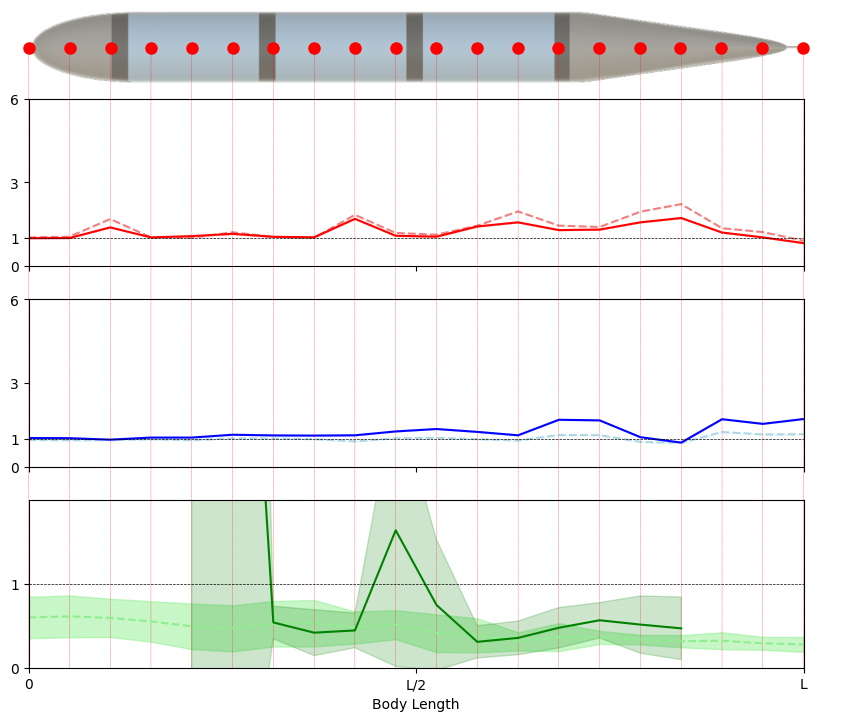

In [156]:
# Plot Training Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_equal)), mean_errors_train_era_equal - std_errors_train_era_equal, mean_errors_train_era_equal + std_errors_train_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_train_era_posterior, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_train_era_posterior)), mean_errors_train_era_posterior - std_errors_train_era_posterior, mean_errors_train_era_posterior + std_errors_train_era_posterior, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_equal)), mean_errors_train_dmdc_equal - std_errors_train_dmdc_equal, mean_errors_train_dmdc_equal + std_errors_train_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_train_dmdc_posterior, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_train_dmdc_posterior)), mean_errors_train_dmdc_posterior - std_errors_train_dmdc_posterior, mean_errors_train_dmdc_posterior + std_errors_train_dmdc_posterior, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_train_lopinf_equal)), mean_errors_train_lopinf_equal - std_errors_train_lopinf_equal, mean_errors_train_lopinf_equal + std_errors_train_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_train_lopinf_posterior, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_train_lopinf_posterior)), mean_errors_train_lopinf_posterior - std_errors_train_lopinf_posterior, mean_errors_train_lopinf_posterior + std_errors_train_lopinf_posterior, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Train.svg", format='svg', dpi=1200)



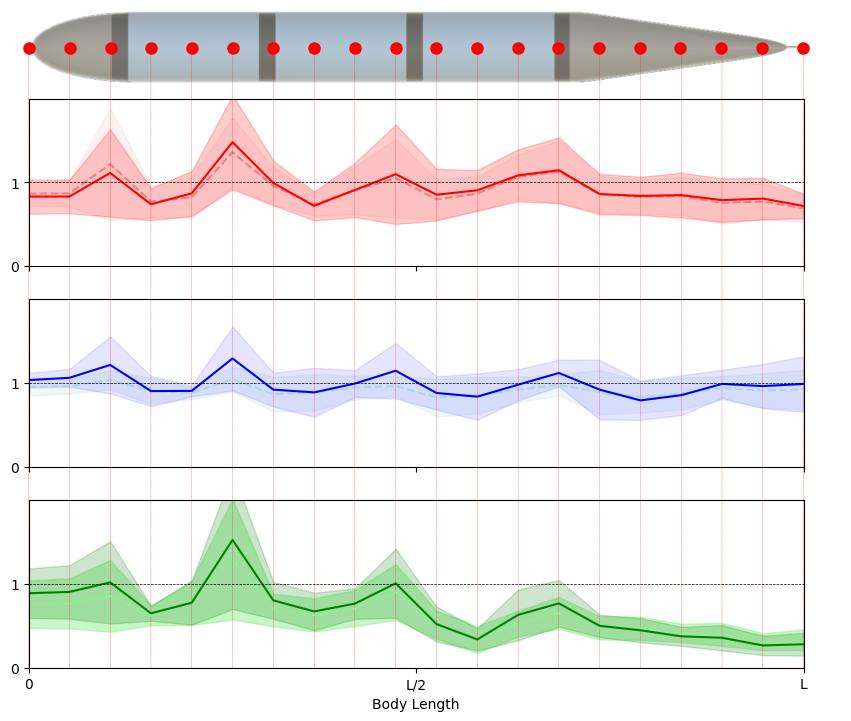

In [157]:
# Plot Test Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_equal, label="ERA (Equal Weights)", color='lightcoral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_equal)), mean_errors_test_era_equal - std_errors_test_era_equal, mean_errors_test_era_equal + std_errors_test_era_equal, color='lightcoral', alpha=0.1, label="Standard Deviation")
ax[1].plot(mean_errors_test_era_posterior, label="ERA (Tail-Focused Weights)", color='red', linestyle='-')
ax[1].fill_between(range(len(mean_errors_test_era_posterior)), mean_errors_test_era_posterior - std_errors_test_era_posterior, mean_errors_test_era_posterior + std_errors_test_era_posterior, color='red', alpha=0.2)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 2])
ax[1].set_yticks([0, 1])#, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_equal, label="DMDc (Equal Weights)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_equal)), mean_errors_test_dmdc_equal - std_errors_test_dmdc_equal, mean_errors_test_dmdc_equal + std_errors_test_dmdc_equal, color='lightblue', alpha=0.2, label="Standard Deviation")
ax[2].plot(mean_errors_test_dmdc_posterior, label="DMDc (Tail-Focused Weights)", color='blue', linestyle='-')
ax[2].fill_between(range(len(mean_errors_test_dmdc_posterior)), mean_errors_test_dmdc_posterior - std_errors_test_dmdc_posterior, mean_errors_test_dmdc_posterior + std_errors_test_dmdc_posterior, color='blue', alpha=0.1)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 2]) #6
ax[2].set_yticks([0, 1])#, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_equal, label="LOpInf (Equal Weights)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_equal)), mean_errors_test_lopinf_equal - std_errors_test_lopinf_equal, mean_errors_test_lopinf_equal + std_errors_test_lopinf_equal, color='lightgreen', alpha=0.5, label="Standard Deviation")
ax[3].plot(mean_errors_test_lopinf_posterior, label="LOpInf (Tail-Focused Weights)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_test_lopinf_posterior)), mean_errors_test_lopinf_posterior - std_errors_test_lopinf_posterior, mean_errors_test_lopinf_posterior + std_errors_test_lopinf_posterior, color='green', alpha=0.2)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_TailFocused_Test.svg", format='svg', dpi=1200)



In [158]:
# lopinf_avgFullBody_rel_errors_posterior_test
# # Remove 2nd element from lopinf_avgFullBody_rel_errors_posterior_test
# lopinf_avgFullBody_rel_errors_posterior_test = np.delete(lopinf_avgFullBody_rel_errors_posterior_test, 6)
# print("LOpInf Avg Full Body Relative Errors (Tail-Focused Weights) - Test Trials: ", lopinf_avgFullBody_rel_errors_posterior_test)

In [159]:
dmdc_avgFullBody_rel_errors_posterior_test

array([[0.59456227, 1.01236024, 1.12007671, 0.6383998 , 0.9822625 ,
        1.00693751, 1.45102826, 0.69878622]])

In [160]:
era_avgFullBody_rel_errors_posterior_test

array([[0.75322205, 0.47599696, 0.81799371, 0.68755026, 1.02618312,
        0.73897554, 0.8058807 , 0.57750571]])

In [161]:
print(era_avgFullBody_rel_errors_posterior_test/era_avgFullBody_rel_errors_equal_test)
print(dmdc_avgFullBody_rel_errors_posterior_test/dmdc_avgFullBody_rel_errors_equal_test)
print(lopinf_avgFullBody_rel_errors_posterior_test/lopinf_avgFullBody_rel_errors_equal_test)

[[1.23928458 1.00626454 1.09142461 1.04728267 0.98144918 0.98763446
  0.99648367 0.8845834 ]]
[[0.91252624 1.01091788 1.09012261 0.97274908 1.02164676 1.00628625
  1.14539772 1.03120025]]
[[0.90448295 1.17423705 1.204524   0.88071563 1.06917785 1.10782235
  0.85125061 0.94549314]]


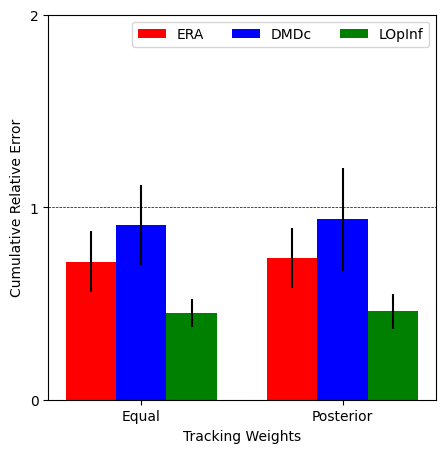

In [162]:
# Bar plot of average full-body relative errors (and stds as error bars) for each method on test data where bars are colored by method and grouped by tail-focused or equal weights
fig, ax = plt.subplots(figsize=(5, 5))
# Define the data for the bar plot
methods = ['LOpInf', 'DMDc', 'ERA']
groups = ['Equal', 'Posterior']
equal_weights_errors_test_means = [era_avgFullBody_rel_errors_equal_test.mean(), dmdc_avgFullBody_rel_errors_equal_test.mean(), lopinf_avgFullBody_rel_errors_equal_test.mean()]
equal_weights_errors_test_stds = [era_avgFullBody_rel_errors_equal_test.std(), dmdc_avgFullBody_rel_errors_equal_test.std(), lopinf_avgFullBody_rel_errors_equal_test.std()]
posterior_errors_test_means = [era_avgFullBody_rel_errors_posterior_test.mean(), dmdc_avgFullBody_rel_errors_posterior_test.mean(), lopinf_avgFullBody_rel_errors_posterior_test.mean()]
posterior_errors_test_stds = [era_avgFullBody_rel_errors_posterior_test.std(), dmdc_avgFullBody_rel_errors_posterior_test.std(), lopinf_avgFullBody_rel_errors_posterior_test.std()]

# Define the x locations for the bars
x = np.arange(len(groups))  # the label locations
width = 0.25  # the width of the bars
# Create the bars for each method
bars1 = ax.bar(x - width, [equal_weights_errors_test_means[0],posterior_errors_test_means[0]], width, yerr=[equal_weights_errors_test_stds[0],posterior_errors_test_stds[0]], label='ERA', color='red')
bars2 = ax.bar(x, [equal_weights_errors_test_means[1],posterior_errors_test_means[1]], width, yerr=[equal_weights_errors_test_stds[1],posterior_errors_test_stds[1]], label='DMDc', color='blue')
bars3 = ax.bar(x + width, [equal_weights_errors_test_means[2],posterior_errors_test_means[2]], width, yerr=[equal_weights_errors_test_stds[2],posterior_errors_test_stds[2]], label='LOpInf', color='green')

# Draw horizontal dotted line at y=1.0
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Tracking Weights')
ax.set_ylabel('Cumulative Relative Error')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_ylim([0, 2])
ax.set_yticks([0,1,2])
# Horizontal legend
ax.legend(loc='upper center', bbox_to_anchor=(0.6, 1), ncol=3)
# Save the figure
plt.savefig(visualizationDir + "outputTrackingErrors_FullBody_PosteriorWeights_Test.svg", format='svg', dpi=1200)

In [163]:
print(equal_weights_errors_test_means)
print(posterior_errors_test_means)
print(equal_weights_errors_test_stds)
print(posterior_errors_test_stds)
elementwise_ratio_means = np.array(posterior_errors_test_means) / np.array(equal_weights_errors_test_means)
print(elementwise_ratio_means)
elementwise_ratio_stds = np.array(posterior_errors_test_stds) / np.array(equal_weights_errors_test_stds)
print(elementwise_ratio_stds)


[0.7177739319915759, 0.9054149423216142, 0.45049956472090324]
[0.7354135074568617, 0.9380516869665504, 0.45897865264742754]
[0.15717159083177573, 0.20776798276935798, 0.07112516032245765]
[0.15459003124853887, 0.26775079036673977, 0.09219971234312012]
[1.02457539 1.03604617 1.01882152]
[0.9835749  1.28870092 1.29630235]


## Feasible Trajectory Tracking - Tracking Accuracy vs Amount of Training Data for DMDc and LOpInf

In [164]:
# Trial Parameters

lopinf_trial_ids_train_1trial = [467]
lopinf_trial_ids_train_2trial = [454,452]#,428,423] [] 
lopinf_trial_ids_train_3trial = [237,233,214]#,428,423][]
lopinf_trial_ids_test_1trial = [455,456,457,459,461,462,464,466]#,428,423][]
lopinf_trial_ids_test_2trial = [443,444,445,447,449,450,451,453]#,428,423][]
lopinf_trial_ids_test_3trial = [201,203,209,216,219,223,230,236]#,428,423][]
dmdc_trial_ids_train_1trial = [430]#,428,423]
dmdc_trial_ids_train_2trial = [291, 287]#, 267]
dmdc_trial_ids_train_3trial = [442,440,435]#[442, 440, 435]
dmdc_trial_ids_test_1trial = [420, 421, 422, 424, 425, 426, 427, 429]
dmdc_trial_ids_test_2trial = [252, 254, 262, 269, 272, 276, 283, 290]
dmdc_trial_ids_test_3trial = [431,433,434,436,437,438,439,441]#[431, 433, 434, 436, 437, 438, 439, 441]

era_trial_ids_train_1trial = [335]#, 331, 311]
era_trial_ids_test_1trial = [297, 299, 305, 313, 316, 320 ,327, 334]


trial_id = lopinf_trial_ids_train_1trial[0]
timesteps = 500
n = 1

In [165]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 18


### Relative Error Over Body Length 

#### Training Data Trials

In [166]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_1trial = np.zeros((20, len(lopinf_trial_ids_train_1trial)))
lopinf_rel_errors_avg_train_2trial = np.zeros((20, len(lopinf_trial_ids_train_2trial)))
lopinf_rel_errors_avg_train_3trial = np.zeros((20, len(lopinf_trial_ids_train_3trial)))
lopinf_rel_errors_avg_test_1trial = np.zeros((20, len(lopinf_trial_ids_test_1trial)))
lopinf_rel_errors_avg_test_2trial = np.zeros((20, len(lopinf_trial_ids_test_2trial)))
lopinf_rel_errors_avg_test_3trial = np.zeros((20, len(lopinf_trial_ids_test_3trial)))
dmdc_rel_errors_avg_train_1trial = np.zeros((20, len(dmdc_trial_ids_train_1trial)))
dmdc_rel_errors_avg_train_2trial = np.zeros((20, len(dmdc_trial_ids_train_2trial)))
dmdc_rel_errors_avg_train_3trial = np.zeros((20, len(dmdc_trial_ids_train_3trial)))
dmdc_rel_errors_avg_test_1trial = np.zeros((20, len(dmdc_trial_ids_test_1trial)))
dmdc_rel_errors_avg_test_2trial = np.zeros((20, len(dmdc_trial_ids_test_2trial)))
dmdc_rel_errors_avg_test_3trial = np.zeros((20, len(dmdc_trial_ids_test_3trial)))
era_rel_errors_avg_train_1trial = np.zeros((20, len(era_trial_ids_train_1trial)))
era_rel_errors_avg_test_1trial = np.zeros((20, len(era_trial_ids_test_1trial)))
# Init variables to hold average fullbody relative errors for each method
lopinf_avgFullBody_rel_errors_train_1trial = np.zeros((1, len(lopinf_trial_ids_train_1trial)))
lopinf_avgFullBody_rel_errors_train_2trial = np.zeros((1, len(lopinf_trial_ids_train_2trial)))
lopinf_avgFullBody_rel_errors_train_3trial = np.zeros((1, len(lopinf_trial_ids_train_3trial)))
lopinf_avgFullBody_rel_errors_test_1trial = np.zeros((1, len(lopinf_trial_ids_test_1trial)))
lopinf_avgFullBody_rel_errors_test_2trial = np.zeros((1, len(lopinf_trial_ids_test_2trial)))
lopinf_avgFullBody_rel_errors_test_3trial = np.zeros((1, len(lopinf_trial_ids_test_3trial)))
dmdc_avgFullBody_rel_errors_train_1trial = np.zeros((1, len(dmdc_trial_ids_train_1trial)))
dmdc_avgFullBody_rel_errors_train_2trial = np.zeros((1, len(dmdc_trial_ids_train_2trial)))
dmdc_avgFullBody_rel_errors_train_3trial = np.zeros((1, len(dmdc_trial_ids_train_3trial)))
dmdc_avgFullBody_rel_errors_test_1trial = np.zeros((1, len(dmdc_trial_ids_test_1trial)))
dmdc_avgFullBody_rel_errors_test_2trial = np.zeros((1, len(dmdc_trial_ids_test_2trial)))
dmdc_avgFullBody_rel_errors_test_3trial = np.zeros((1, len(dmdc_trial_ids_test_3trial)))
era_avgFullBody_rel_errors_train_1trial = np.zeros((1, len(era_trial_ids_train_1trial)))
era_avgFullBody_rel_errors_test_1trial = np.zeros((1, len(era_trial_ids_test_1trial)))

### Calculate statistics for LOpInf trials
# Compute relative errors for each training trial with LOpInf trained on 1 trial 
for trialInd in range(len(lopinf_trial_ids_train_1trial)):
    trial_id = lopinf_trial_ids_train_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute average full body relative errors for LOpInf trained on 1 trial
    lopinf_avgFullBody_rel_errors_train_1trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with LOpInf trained on 2 trials
for trialInd in range(len(lopinf_trial_ids_train_2trial)):
    trial_id = lopinf_trial_ids_train_2trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_2trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for LOpInf trained on 2 trials
    lopinf_avgFullBody_rel_errors_train_2trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')

# Compute relative errors for each training trial with LOpInf trained on 3 trials
for trialInd in range(len(lopinf_trial_ids_train_3trial)):
    trial_id = lopinf_trial_ids_train_3trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_3trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for LOpInf trained on 3 trials
    lopinf_avgFullBody_rel_errors_train_3trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with LOpInf trained on 1 trial
for trialInd in range(len(lopinf_trial_ids_test_1trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for LOpInf trained on 1 trial
    lopinf_avgFullBody_rel_errors_test_1trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with LOpInf trained on 2 trials
for trialInd in range(len(lopinf_trial_ids_test_2trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_2trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_2trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for LOpInf trained on 2 trials
    lopinf_avgFullBody_rel_errors_test_2trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with LOpInf trained on 3 trials
for trialInd in range(len(lopinf_trial_ids_test_3trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_3trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_3trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for LOpInf trained on 3 trials
    lopinf_avgFullBody_rel_errors_test_3trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_lopinf_1trial = np.mean(lopinf_rel_errors_avg_train_1trial, axis=1)
mean_errors_train_lopinf_2trial = np.mean(lopinf_rel_errors_avg_train_2trial, axis=1)
mean_errors_train_lopinf_3trial = np.mean(lopinf_rel_errors_avg_train_3trial, axis=1)
std_errors_train_lopinf_1trial = np.std(lopinf_rel_errors_avg_train_1trial, axis=1)
std_errors_train_lopinf_2trial = np.std(lopinf_rel_errors_avg_train_2trial, axis=1)
std_errors_train_lopinf_3trial = np.std(lopinf_rel_errors_avg_train_3trial, axis=1)
mean_errors_test_lopinf_1trial = np.mean(lopinf_rel_errors_avg_test_1trial, axis=1)
mean_errors_test_lopinf_2trial = np.mean(lopinf_rel_errors_avg_test_2trial, axis=1)
mean_errors_test_lopinf_3trial = np.mean(lopinf_rel_errors_avg_test_3trial, axis=1)
std_errors_test_lopinf_1trial = np.std(lopinf_rel_errors_avg_test_1trial, axis=1)
std_errors_test_lopinf_2trial = np.std(lopinf_rel_errors_avg_test_2trial, axis=1)
std_errors_test_lopinf_3trial = np.std(lopinf_rel_errors_avg_test_3trial, axis=1)


### Calculate statistics for DMDc trials
# Compute relative errors for each training trial with DMDc trained on 1 trial
for trialInd in range(len(dmdc_trial_ids_train_1trial)):
    trial_id = dmdc_trial_ids_train_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute average full body relative errors for DMDc trained on 1 trial
    dmdc_avgFullBody_rel_errors_train_1trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with DMDc trained on 2 trials
for trialInd in range(len(dmdc_trial_ids_train_2trial)):
    trial_id = dmdc_trial_ids_train_2trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_2trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for DMDc trained on 2 trials
    dmdc_avgFullBody_rel_errors_train_2trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with DMDc trained on 3 trials
for trialInd in range(len(dmdc_trial_ids_train_3trial)):
    trial_id = dmdc_trial_ids_train_3trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_3trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for DMDc trained on 3 trials
    dmdc_avgFullBody_rel_errors_train_3trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with DMDc trained on 1 trial
for trialInd in range(len(dmdc_trial_ids_test_1trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute average full body relative errors for DMDc trained on 1 trial
    dmdc_avgFullBody_rel_errors_test_1trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with DMDc trained on 2 trials
for trialInd in range(len(dmdc_trial_ids_test_2trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_2trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_2trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for DMDc trained on 2 trials
    dmdc_avgFullBody_rel_errors_test_2trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with DMDc trained on 3 trials
for trialInd in range(len(dmdc_trial_ids_test_3trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_3trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_3trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for DMDc trained on 3 trials
    dmdc_avgFullBody_rel_errors_test_3trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_dmdc_1trial = np.mean(dmdc_rel_errors_avg_train_1trial, axis=1)
mean_errors_train_dmdc_2trial = np.mean(dmdc_rel_errors_avg_train_2trial, axis=1)
mean_errors_train_dmdc_3trial = np.mean(dmdc_rel_errors_avg_train_3trial, axis=1)
std_errors_train_dmdc_1trial = np.std(dmdc_rel_errors_avg_train_1trial, axis=1)
std_errors_train_dmdc_2trial = np.std(dmdc_rel_errors_avg_train_2trial, axis=1)
std_errors_train_dmdc_3trial = np.std(dmdc_rel_errors_avg_train_3trial, axis=1)
mean_errors_test_dmdc_1trial = np.mean(dmdc_rel_errors_avg_test_1trial, axis=1)
mean_errors_test_dmdc_2trial = np.mean(dmdc_rel_errors_avg_test_2trial, axis=1)
mean_errors_test_dmdc_3trial = np.mean(dmdc_rel_errors_avg_test_3trial, axis=1)
std_errors_test_dmdc_1trial = np.std(dmdc_rel_errors_avg_test_1trial, axis=1)
std_errors_test_dmdc_2trial = np.std(dmdc_rel_errors_avg_test_2trial, axis=1)
std_errors_test_dmdc_3trial = np.std(dmdc_rel_errors_avg_test_3trial, axis=1)
### Calculate statistics for ERA trials
# Compute relative errors for each training trial with ERA trained on 1 trial
for trialInd in range(len(era_trial_ids_train_1trial)):
    trial_id = era_trial_ids_train_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
# Compute average full body relative errors for ERA trained on 1 trial
    era_avgFullBody_rel_errors_train_1trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with ERA trained on 1 trial
for trialInd in range(len(era_trial_ids_test_1trial)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_1trial[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
# Compute average full body relative errors for ERA trained on 1 trial
    era_avgFullBody_rel_errors_test_1trial[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_era_1trial = np.mean(era_rel_errors_avg_train_1trial, axis=1)
mean_errors_test_era_1trial = np.mean(era_rel_errors_avg_test_1trial, axis=1)
std_errors_train_era_1trial = np.std(era_rel_errors_avg_train_1trial, axis=1)
std_errors_test_era_1trial = np.std(era_rel_errors_avg_test_1trial, axis=1)

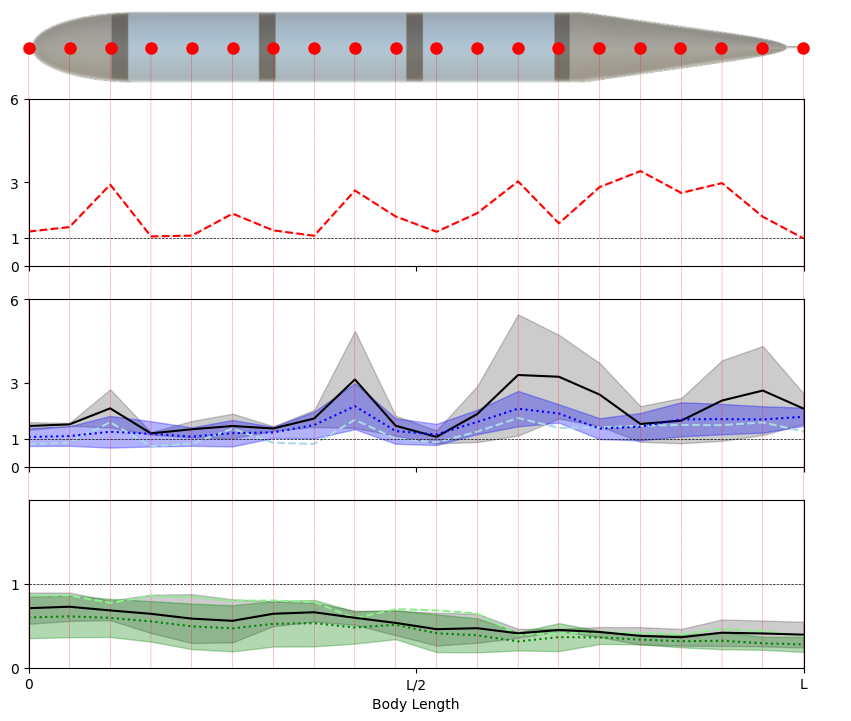

In [167]:
# Plot Training Errors for LOpInf, DMDc, and ERA with different amounts of training trials
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_1trial, label="ERA (1 Trial)", color='red', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_1trial)), mean_errors_train_era_1trial - std_errors_train_era_1trial, mean_errors_train_era_1trial + std_errors_train_era_1trial, color='red', alpha=0.1)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_1trial, label="DMDc (1 Trial)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_1trial)), mean_errors_train_dmdc_1trial - std_errors_train_dmdc_1trial, mean_errors_train_dmdc_1trial + std_errors_train_dmdc_1trial, color='lightblue', alpha=0.1)
ax[2].plot(mean_errors_train_dmdc_2trial, label="DMDc (2 Trials)", color='black', linestyle='-')
ax[2].fill_between(range(len(mean_errors_train_dmdc_2trial)), mean_errors_train_dmdc_2trial - std_errors_train_dmdc_2trial, mean_errors_train_dmdc_2trial + std_errors_train_dmdc_2trial, color='black', alpha=0.2)
ax[2].plot(mean_errors_train_dmdc_3trial, label="DMDc (3 Trials)", color='blue', linestyle=':')
ax[2].fill_between(range(len(mean_errors_train_dmdc_3trial)), mean_errors_train_dmdc_3trial - std_errors_train_dmdc_3trial, mean_errors_train_dmdc_3trial + std_errors_train_dmdc_3trial, color='blue', alpha=0.3)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_1trial, label="LOpInf (1 Trial)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_train_lopinf_1trial)), mean_errors_train_lopinf_1trial - std_errors_train_lopinf_1trial, mean_errors_train_lopinf_1trial + std_errors_train_lopinf_1trial, color='lightgreen', alpha=0.1, label="Standard Deviation")
ax[3].plot(mean_errors_train_lopinf_2trial, label="LOpInf (2 Trials)", color='black', linestyle='-')
ax[3].fill_between(range(len(mean_errors_train_lopinf_2trial)), mean_errors_train_lopinf_2trial - std_errors_train_lopinf_2trial, mean_errors_train_lopinf_2trial + std_errors_train_lopinf_2trial, color='black', alpha=0.2)
ax[3].plot(mean_errors_train_lopinf_3trial, label="LOpInf (3 Trials)", color='green', linestyle=':')
ax[3].fill_between(range(len(mean_errors_train_lopinf_3trial)), mean_errors_train_lopinf_3trial - std_errors_train_lopinf_3trial, mean_errors_train_lopinf_3trial + std_errors_train_lopinf_3trial, color='green', alpha=0.3)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_Train_NumTrainingTrials.svg", format='svg', dpi=1200)



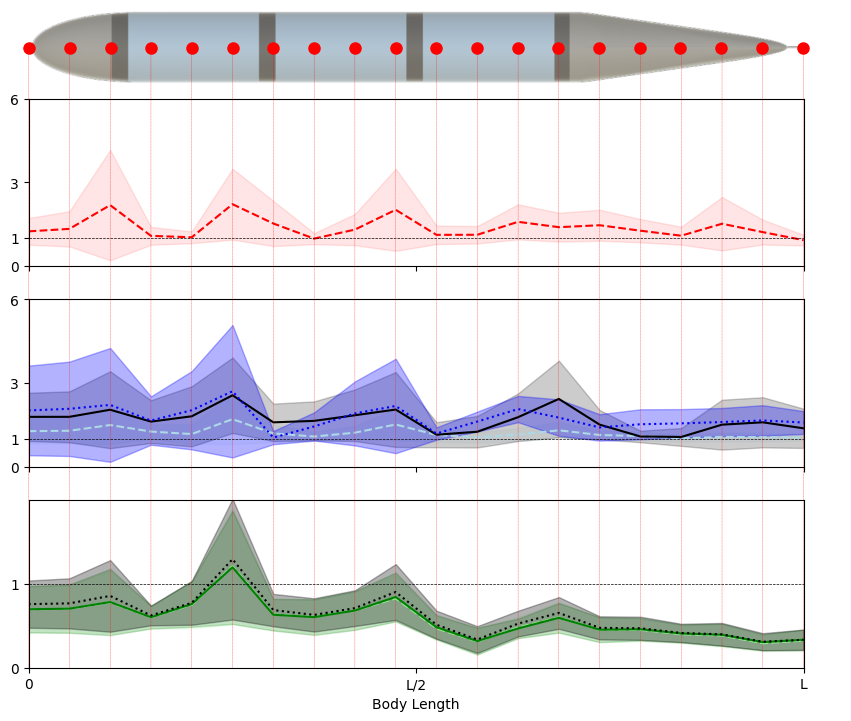

In [168]:
# Plot Test Errors for Equal and Tail-Focused Weights
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_1trial, label="ERA (1 Trial)", color='red', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_1trial)), mean_errors_test_era_1trial - std_errors_test_era_1trial, mean_errors_test_era_1trial + std_errors_test_era_1trial, color='red', alpha=0.1)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_1trial, label="DMDc (1 Trial)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_1trial)), mean_errors_test_dmdc_1trial - std_errors_test_dmdc_1trial, mean_errors_test_dmdc_1trial + std_errors_test_dmdc_1trial, color='lightblue', alpha=0.1)
ax[2].plot(mean_errors_test_dmdc_2trial, label="DMDc (2 Trials)", color='black', linestyle='-')
ax[2].fill_between(range(len(mean_errors_test_dmdc_2trial)), mean_errors_test_dmdc_2trial - std_errors_test_dmdc_2trial, mean_errors_test_dmdc_2trial + std_errors_test_dmdc_2trial, color='black', alpha=0.2)
ax[2].plot(mean_errors_test_dmdc_3trial, label="DMDc (3 Trials)", color='blue', linestyle=':')
ax[2].fill_between(range(len(mean_errors_test_dmdc_3trial)), mean_errors_test_dmdc_3trial - std_errors_test_dmdc_3trial, mean_errors_test_dmdc_3trial + std_errors_test_dmdc_3trial, color='blue', alpha=0.3)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all test trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_1trial, label="LOpInf (1 Trial)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_1trial)), mean_errors_test_lopinf_1trial - std_errors_test_lopinf_1trial, mean_errors_test_lopinf_1trial + std_errors_test_lopinf_1trial, color='lightgreen', alpha=0.1, label="Standard Deviation")
ax[3].plot(mean_errors_test_lopinf_2trial, label="LOpInf (2 Trials)", color='green', linestyle='-')
ax[3].fill_between(range(len(mean_errors_test_lopinf_2trial)), mean_errors_test_lopinf_2trial - std_errors_test_lopinf_2trial, mean_errors_test_lopinf_2trial + std_errors_test_lopinf_2trial, color='green', alpha=0.2)
ax[3].plot(mean_errors_test_lopinf_3trial, label="LOpInf (3 Trials)", color='black', linestyle=':')
ax[3].fill_between(range(len(mean_errors_test_lopinf_3trial)), mean_errors_test_lopinf_3trial - std_errors_test_lopinf_3trial, mean_errors_test_lopinf_3trial + std_errors_test_lopinf_3trial, color='black', alpha=0.3)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)

# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_Test_NumTrainingTrials.svg", format='svg', dpi=1200)

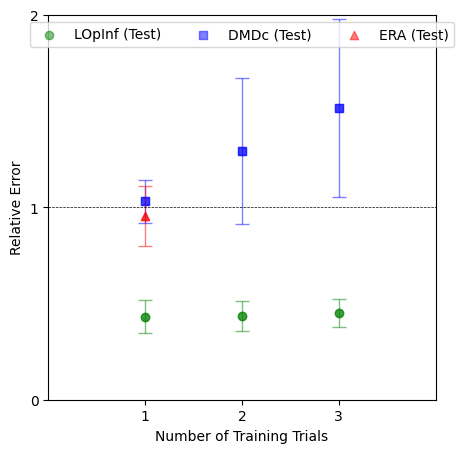

In [169]:
# Scatter plot of full body relative errors (average with std error bars) for each method
fig, ax = plt.subplots(figsize=(5, 5))
numTrainingTrials = np.array([1, 2, 3])

errors_lopinf_means_test = np.array([np.mean(lopinf_avgFullBody_rel_errors_test_1trial), np.mean(lopinf_avgFullBody_rel_errors_test_2trial), np.mean(lopinf_avgFullBody_rel_errors_test_3trial)])
errors_lopinf_stds_test = np.array([np.std(lopinf_avgFullBody_rel_errors_test_1trial), np.std(lopinf_avgFullBody_rel_errors_test_2trial), np.std(lopinf_avgFullBody_rel_errors_test_3trial)])
errors_dmdc_means_test = np.array([np.mean(dmdc_avgFullBody_rel_errors_test_1trial), np.mean(dmdc_avgFullBody_rel_errors_test_2trial), np.mean(dmdc_avgFullBody_rel_errors_test_3trial)])
errors_dmdc_stds_test = np.array([np.std(dmdc_avgFullBody_rel_errors_test_1trial), np.std(dmdc_avgFullBody_rel_errors_test_2trial), np.std(dmdc_avgFullBody_rel_errors_test_3trial)])
errors_era_means_test = np.array([np.mean(era_avgFullBody_rel_errors_test_1trial)])
errors_era_stds_test = np.array([np.std(era_avgFullBody_rel_errors_test_1trial)])

# Plot scatter plot of test errors with error bars
ax.scatter(numTrainingTrials, errors_lopinf_means_test, label="LOpInf (Test)", color='green', marker='o', alpha=0.5)
ax.errorbar(numTrainingTrials, errors_lopinf_means_test, yerr=errors_lopinf_stds_test, fmt='o', color='green', capsize=5, elinewidth=1, alpha=0.5)
ax.scatter(numTrainingTrials, errors_dmdc_means_test, label="DMDc (Test)", color='blue', marker='s', alpha=0.5)
ax.errorbar(numTrainingTrials, errors_dmdc_means_test, yerr=errors_dmdc_stds_test, fmt='s', color='blue', capsize=5, elinewidth=1, alpha=0.5)
ax.scatter(numTrainingTrials[0], errors_era_means_test, label="ERA (Test)", color='red', marker='^', alpha=0.5)
ax.errorbar(numTrainingTrials[0], errors_era_means_test, yerr=errors_era_stds_test, fmt='^', color='red', capsize=5, elinewidth=1, alpha=0.5)
ax.set_xlim([0, 4])
ax.set_ylim([0, 2])
ax.set_xlabel("Number of Training Trials")
ax.set_ylabel("Relative Error")
ax.set_xticks([1, 2, 3])
ax.set_yticks([0, 1, 2])
# Horizontal dotted line at y=1.0
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Horizontal legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3)
# Save as svg
plt.savefig(visualizationDir + "outputFullBodyRelativeErrors_Spatial_Test_NumTrainingTrials.svg", format='svg', dpi=1200)


In [170]:
errors_lopinf_means_test

array([0.43093419, 0.43434216, 0.45049956])

In [171]:
errors_lopinf_stds_test

array([0.08598489, 0.07885292, 0.07112516])

## Feasible Trajectory Tracking - Tracking Accuracy vs Dimension of ROM

In [ ]:
# Trial Parameters

lopinf_trial_ids_train_2dim =  [479]
lopinf_trial_ids_train_10dim = [490]
lopinf_trial_ids_train_18dim = [467]
lopinf_trial_ids_test_2dim =   [468,469,470,472,473,474,476,478]
lopinf_trial_ids_test_10dim =  [480,481,482,484,485,486,487,489]
lopinf_trial_ids_test_18dim =  [455,456,457,459,461,462,464,466]

dmdc_trial_ids_train_2dim =  [525]
dmdc_trial_ids_train_10dim = [538]
dmdc_trial_ids_train_18dim = [430]
dmdc_trial_ids_test_2dim =   [513, 515, 516, 518, 519, 520, 521, 523]
dmdc_trial_ids_test_10dim =  [526, 528, 529, 531, 533, 534, 535, 537] 
dmdc_trial_ids_test_18dim =  [420, 421, 422, 424, 425, 426, 427, 429]

era_trial_ids_train_2dim =  [501]
era_trial_ids_train_10dim = [512]
era_trial_ids_train_18dim = [335]
era_trial_ids_test_2dim =   [491, 492, 493, 495, 496, 497, 498, 500]
era_trial_ids_test_10dim =  [502, 503, 504, 506, 507, 508, 509, 511]
era_trial_ids_test_18dim =  [297, 299, 305, 313, 316, 320, 327, 334]


trial_id = lopinf_trial_ids_train_2dim[0]
timesteps = 500
n = 1

In [64]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, trial_id, n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 2


### Relative Error Over Body Length 

#### Training Data Trials

In [65]:
# Initialize array to hold relative errors over all trials 
lopinf_rel_errors_avg_train_2dim  = np.zeros((20, len(lopinf_trial_ids_train_2dim )))
lopinf_rel_errors_avg_train_10dim = np.zeros((20, len(lopinf_trial_ids_train_10dim)))
lopinf_rel_errors_avg_train_18dim = np.zeros((20, len(lopinf_trial_ids_train_18dim)))
lopinf_rel_errors_avg_test_2dim  = np.zeros((20, len(lopinf_trial_ids_test_2dim )))
lopinf_rel_errors_avg_test_10dim = np.zeros((20, len(lopinf_trial_ids_test_10dim)))
lopinf_rel_errors_avg_test_18dim = np.zeros((20, len(lopinf_trial_ids_test_18dim)))
dmdc_rel_errors_avg_train_2dim  = np.zeros((20, len(dmdc_trial_ids_train_2dim )))
dmdc_rel_errors_avg_train_10dim = np.zeros((20, len(dmdc_trial_ids_train_10dim)))
dmdc_rel_errors_avg_train_18dim = np.zeros((20, len(dmdc_trial_ids_train_18dim)))
dmdc_rel_errors_avg_test_2dim  = np.zeros((20, len(dmdc_trial_ids_test_2dim )))
dmdc_rel_errors_avg_test_10dim = np.zeros((20, len(dmdc_trial_ids_test_10dim)))
dmdc_rel_errors_avg_test_18dim = np.zeros((20, len(dmdc_trial_ids_test_18dim)))
era_rel_errors_avg_train_2dim  = np.zeros((20, len(era_trial_ids_train_2dim )))
era_rel_errors_avg_train_10dim = np.zeros((20, len(era_trial_ids_train_10dim)))
era_rel_errors_avg_train_18dim = np.zeros((20, len(era_trial_ids_train_18dim)))
era_rel_errors_avg_test_2dim  = np.zeros((20, len(era_trial_ids_test_2dim )))
era_rel_errors_avg_test_10dim = np.zeros((20, len(era_trial_ids_test_10dim)))
era_rel_errors_avg_test_18dim = np.zeros((20, len(era_trial_ids_test_18dim)))

lopinf_avgFullBody_rel_errors_train_2dim  = np.zeros((1, len(lopinf_trial_ids_train_2dim )))
lopinf_avgFullBody_rel_errors_train_10dim = np.zeros((1, len(lopinf_trial_ids_train_10dim)))
lopinf_avgFullBody_rel_errors_train_18dim = np.zeros((1, len(lopinf_trial_ids_train_18dim)))
lopinf_avgFullBody_rel_errors_test_2dim  = np.zeros((1, len(lopinf_trial_ids_test_2dim )))
lopinf_avgFullBody_rel_errors_test_10dim = np.zeros((1, len(lopinf_trial_ids_test_10dim)))
lopinf_avgFullBody_rel_errors_test_18dim = np.zeros((1, len(lopinf_trial_ids_test_18dim)))
dmdc_avgFullBody_rel_errors_train_2dim  = np.zeros((1, len(dmdc_trial_ids_train_2dim )))
dmdc_avgFullBody_rel_errors_train_10dim = np.zeros((1, len(dmdc_trial_ids_train_10dim)))
dmdc_avgFullBody_rel_errors_train_18dim = np.zeros((1, len(dmdc_trial_ids_train_18dim)))
dmdc_avgFullBody_rel_errors_test_2dim  = np.zeros((1, len(dmdc_trial_ids_test_2dim )))
dmdc_avgFullBody_rel_errors_test_10dim = np.zeros((1, len(dmdc_trial_ids_test_10dim)))
dmdc_avgFullBody_rel_errors_test_18dim = np.zeros((1, len(dmdc_trial_ids_test_18dim)))
era_avgFullBody_rel_errors_train_2dim  = np.zeros((1, len(era_trial_ids_train_2dim )))
era_avgFullBody_rel_errors_train_10dim = np.zeros((1, len(era_trial_ids_train_10dim)))
era_avgFullBody_rel_errors_train_18dim = np.zeros((1, len(era_trial_ids_train_18dim)))
era_avgFullBody_rel_errors_test_2dim  = np.zeros((1, len(era_trial_ids_test_2dim )))
era_avgFullBody_rel_errors_test_10dim = np.zeros((1, len(era_trial_ids_test_10dim)))
era_avgFullBody_rel_errors_test_18dim = np.zeros((1, len(era_trial_ids_test_18dim)))
### Calculate statistics for LOpInf trials
# Compute relative errors for each training trial with LOpInf with state dimension 2 
for trialInd in range(len(lopinf_trial_ids_train_2dim)):
    trial_id = lopinf_trial_ids_train_1trial[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for LOpInf trained on 2 trials
    lopinf_avgFullBody_rel_errors_train_2dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with LOpInf with state dimension 10
for trialInd in range(len(lopinf_trial_ids_train_10dim)):
    trial_id = lopinf_trial_ids_train_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for LOpInf trained on 10 trials
    lopinf_avgFullBody_rel_errors_train_10dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with LOpInf with state dimension 18
for trialInd in range(len(lopinf_trial_ids_train_18dim)):
    trial_id = lopinf_trial_ids_train_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_train_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for LOpInf trained on 18 trials
    lopinf_avgFullBody_rel_errors_train_18dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with LOpInf with state dimension 2
for trialInd in range(len(lopinf_trial_ids_test_2dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for LOpInf trained on 2 trials
    lopinf_avgFullBody_rel_errors_test_2dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with LOpInf with state dimension 10
for trialInd in range(len(lopinf_trial_ids_test_10dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for LOpInf trained on 10 trials
    lopinf_avgFullBody_rel_errors_test_10dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with LOpInf with state dimension 18
for trialInd in range(len(lopinf_trial_ids_test_18dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = lopinf_trial_ids_test_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        lopinf_rel_errors_avg_test_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for LOpInf trained on 18 trials
    lopinf_avgFullBody_rel_errors_test_18dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_lopinf_2dim = np.mean(lopinf_rel_errors_avg_train_2dim, axis=1)
mean_errors_train_lopinf_10dim = np.mean(lopinf_rel_errors_avg_train_10dim, axis=1)
mean_errors_train_lopinf_18dim = np.mean(lopinf_rel_errors_avg_train_18dim, axis=1)
std_errors_train_lopinf_2dim = np.std(lopinf_rel_errors_avg_train_2dim, axis=1)
std_errors_train_lopinf_10dim = np.std(lopinf_rel_errors_avg_train_10dim, axis=1)
std_errors_train_lopinf_18dim = np.std(lopinf_rel_errors_avg_train_18dim, axis=1)
mean_errors_test_lopinf_2dim = np.mean(lopinf_rel_errors_avg_test_2dim, axis=1)
mean_errors_test_lopinf_10dim = np.mean(lopinf_rel_errors_avg_test_10dim, axis=1)
mean_errors_test_lopinf_18dim = np.mean(lopinf_rel_errors_avg_test_18dim, axis=1)
std_errors_test_lopinf_2dim = np.std(lopinf_rel_errors_avg_test_2dim, axis=1)
std_errors_test_lopinf_10dim = np.std(lopinf_rel_errors_avg_test_10dim, axis=1)
std_errors_test_lopinf_18dim = np.std(lopinf_rel_errors_avg_test_18dim, axis=1)
### Calculate statistics for DMDc trials
# Compute relative errors for each training trial with DMDc trained on 2 trials
for trialInd in range(len(dmdc_trial_ids_train_2dim)):
    trial_id = dmdc_trial_ids_train_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for DMDc trained on 2 trials
    dmdc_avgFullBody_rel_errors_train_2dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with DMDc trained on 10 trials
for trialInd in range(len(dmdc_trial_ids_train_10dim)):
    trial_id = dmdc_trial_ids_train_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for DMDc trained on 10 trials
    dmdc_avgFullBody_rel_errors_train_10dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with DMDc trained on 18 trials
for trialInd in range(len(dmdc_trial_ids_train_18dim)):
    trial_id = dmdc_trial_ids_train_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_train_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for DMDc trained on 18 trials
    dmdc_avgFullBody_rel_errors_train_18dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with DMDc trained on 2 trials
for trialInd in range(len(dmdc_trial_ids_test_2dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for DMDc trained on 2 trials
    dmdc_avgFullBody_rel_errors_test_2dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with DMDc trained on 10 trials
for trialInd in range(len(dmdc_trial_ids_test_10dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for DMDc trained on 10 trials
    dmdc_avgFullBody_rel_errors_test_10dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with DMDc trained on 18 trials
for trialInd in range(len(dmdc_trial_ids_test_18dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = dmdc_trial_ids_test_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        dmdc_rel_errors_avg_test_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for DMDc trained on 18 trials
    dmdc_avgFullBody_rel_errors_test_18dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_dmdc_2dim = np.mean(dmdc_rel_errors_avg_train_2dim, axis=1)
mean_errors_train_dmdc_10dim = np.mean(dmdc_rel_errors_avg_train_10dim, axis=1)
mean_errors_train_dmdc_18dim = np.mean(dmdc_rel_errors_avg_train_18dim, axis=1)
std_errors_train_dmdc_2dim = np.std(dmdc_rel_errors_avg_train_2dim, axis=1)
std_errors_train_dmdc_10dim = np.std(dmdc_rel_errors_avg_train_10dim, axis=1)
std_errors_train_dmdc_18dim = np.std(dmdc_rel_errors_avg_train_18dim, axis=1)
mean_errors_test_dmdc_2dim = np.mean(dmdc_rel_errors_avg_test_2dim, axis=1)
mean_errors_test_dmdc_10dim = np.mean(dmdc_rel_errors_avg_test_10dim, axis=1)
mean_errors_test_dmdc_18dim = np.mean(dmdc_rel_errors_avg_test_18dim, axis=1)
std_errors_test_dmdc_2dim = np.std(dmdc_rel_errors_avg_test_2dim, axis=1)
std_errors_test_dmdc_10dim = np.std(dmdc_rel_errors_avg_test_10dim, axis=1)
std_errors_test_dmdc_18dim = np.std(dmdc_rel_errors_avg_test_18dim, axis=1)
### Calculate statistics for ERA trials
# Compute relative errors for each training trial with ERA trained on 2 trials
for trialInd in range(len(era_trial_ids_train_2dim)):
    trial_id = era_trial_ids_train_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for ERA trained on 2 trials
    era_avgFullBody_rel_errors_train_2dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with ERA trained on 10 trials
for trialInd in range(len(era_trial_ids_train_10dim)):
    trial_id = era_trial_ids_train_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for ERA trained on 10 trials
    era_avgFullBody_rel_errors_train_10dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each training trial with ERA trained on 18 trials
for trialInd in range(len(era_trial_ids_train_18dim)):
    trial_id = era_trial_ids_train_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]
    
    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_train_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_train)
    # Compute average full body relative errors for ERA trained on 18 trials
    era_avgFullBody_rel_errors_train_18dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with ERA trained on 2 trials
for trialInd in range(len(era_trial_ids_test_2dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_2dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_2dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for ERA trained on 2 trials
    era_avgFullBody_rel_errors_test_2dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with ERA trained on 10 trials
for trialInd in range(len(era_trial_ids_test_10dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_10dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_10dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for ERA trained on 10 trials
    era_avgFullBody_rel_errors_test_10dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
# Compute relative errors for each test trial with ERA trained on 18 trials
for trialInd in range(len(era_trial_ids_test_18dim)):
    # print(f"TrialInd: {trialInd}")
    trial_id = era_trial_ids_test_18dim[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, trial_id, n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # Populate the rel_errors_avg array with the relative errors
    for i in range(20):
        era_rel_errors_avg_test_18dim[19-i,trialInd] = np.linalg.norm(Y_fom[2*i+1,:]-y_refs[2*i+1,:])/np.linalg.norm(y_refs[2*i+1,:])
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body relative errors for ERA trained on 18 trials
    era_avgFullBody_rel_errors_test_18dim[0,trialInd] = np.linalg.norm(Y_fom[1:41:2,:]-y_refs[1:41:2,:], ord='fro')/np.linalg.norm(y_refs[1:41:2,:], ord='fro')
mean_errors_train_era_2dim = np.mean(era_rel_errors_avg_train_2dim, axis=1)
mean_errors_train_era_10dim = np.mean(era_rel_errors_avg_train_10dim, axis=1)
mean_errors_train_era_18dim = np.mean(era_rel_errors_avg_train_18dim, axis=1)
std_errors_train_era_2dim = np.std(era_rel_errors_avg_train_2dim, axis=1)
std_errors_train_era_10dim = np.std(era_rel_errors_avg_train_10dim, axis=1)
std_errors_train_era_18dim = np.std(era_rel_errors_avg_train_18dim, axis=1)
mean_errors_test_era_2dim = np.mean(era_rel_errors_avg_test_2dim, axis=1)
mean_errors_test_era_10dim = np.mean(era_rel_errors_avg_test_10dim, axis=1)
mean_errors_test_era_18dim = np.mean(era_rel_errors_avg_test_18dim, axis=1)
std_errors_test_era_2dim = np.std(era_rel_errors_avg_test_2dim, axis=1)
std_errors_test_era_10dim = np.std(era_rel_errors_avg_test_10dim, axis=1)
std_errors_test_era_18dim = np.std(era_rel_errors_avg_test_18dim, axis=1)



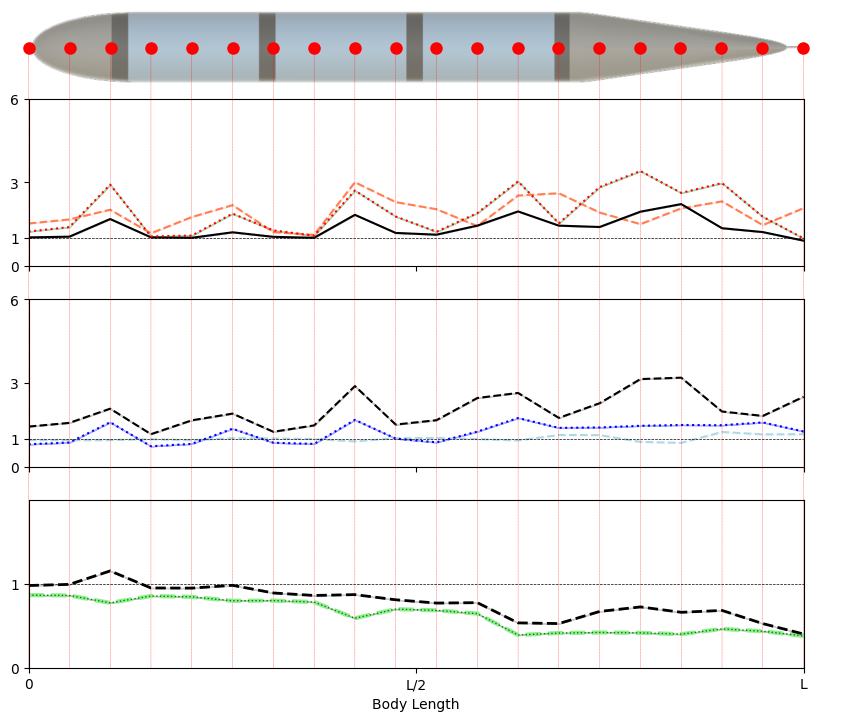

In [66]:
# Plot Training Errors for LOpInf, DMDc, and ERA with different amounts of training trials
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all training trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_train_era_2dim, label="ERA (2 Dim)", color='coral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_train_era_2dim)), mean_errors_train_era_2dim - std_errors_train_era_2dim, mean_errors_train_era_2dim + std_errors_train_era_2dim, color='red', alpha=0.1)
ax[1].plot(mean_errors_train_era_10dim, label="ERA (10 Dim)", color='black', linestyle='-')
ax[1].fill_between(range(len(mean_errors_train_era_10dim)), mean_errors_train_era_10dim - std_errors_train_era_10dim, mean_errors_train_era_10dim + std_errors_train_era_10dim, color='black', alpha=0.2)
ax[1].plot(mean_errors_train_era_18dim, label="ERA (18 Dim)", color='red', linestyle=':')
ax[1].fill_between(range(len(mean_errors_train_era_18dim)), mean_errors_train_era_18dim - std_errors_train_era_18dim, mean_errors_train_era_18dim + std_errors_train_era_18dim, color='green', alpha=0.3)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all training trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_train_dmdc_2dim, label="DMDc (2 Dim)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_2dim)), mean_errors_train_dmdc_2dim - std_errors_train_dmdc_2dim, mean_errors_train_dmdc_2dim + std_errors_train_dmdc_2dim, color='lightblue', alpha=0.1)
ax[2].plot(mean_errors_train_dmdc_10dim, label="DMDc (10 Dim)", color='black', linestyle='--')
ax[2].fill_between(range(len(mean_errors_train_dmdc_10dim)), mean_errors_train_dmdc_10dim - std_errors_train_dmdc_10dim, mean_errors_train_dmdc_10dim + std_errors_train_dmdc_10dim, color='black', alpha=0.2)
ax[2].plot(mean_errors_train_dmdc_18dim, label="DMDc (18 Dim)", color='blue', linestyle=':')
ax[2].fill_between(range(len(mean_errors_train_dmdc_18dim)), mean_errors_train_dmdc_18dim - std_errors_train_dmdc_18dim, mean_errors_train_dmdc_18dim + std_errors_train_dmdc_18dim, color='blue', alpha=0.3)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_train_lopinf_2dim, label="LOpInf (2 Dim)", color='lightgreen', linestyle='--',linewidth=3)
ax[3].fill_between(range(len(mean_errors_train_lopinf_2dim)), mean_errors_train_lopinf_2dim - std_errors_train_lopinf_2dim, mean_errors_train_lopinf_2dim + std_errors_train_lopinf_2dim, color='lightgreen', alpha=0.1)
ax[3].plot(mean_errors_train_lopinf_10dim, label="LOpInf (10 Dim)", color='black', linestyle='--', linewidth=2)
ax[3].fill_between(range(len(mean_errors_train_lopinf_10dim)), mean_errors_train_lopinf_10dim - std_errors_train_lopinf_10dim, mean_errors_train_lopinf_10dim + std_errors_train_lopinf_10dim, color='black', alpha=0.2)
ax[3].plot(mean_errors_train_lopinf_18dim, label="LOpInf (18 Dim)", color='green', linestyle=':', linewidth=1)
ax[3].fill_between(range(len(mean_errors_train_lopinf_18dim)), mean_errors_train_lopinf_18dim - std_errors_train_lopinf_18dim, mean_errors_train_lopinf_18dim + std_errors_train_lopinf_18dim, color='green', alpha=0.3)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)





# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_Train_NumTrainingTrials.svg", format='svg', dpi=1200)



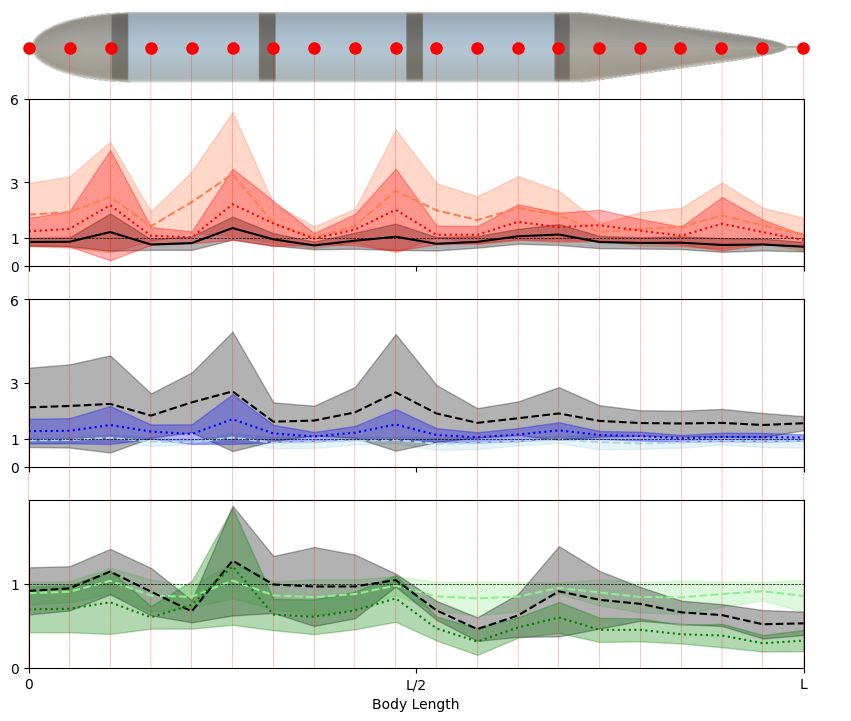

In [67]:
# Plot Training Errors for LOpInf, DMDc, and ERA with different amounts of training trials
fig, ax = plt.subplots(4, 1, figsize=(10, 10))

# Import svg of fish with dots into top subplot
# Load the image
img = Image.open(visualizationDir + "ShadedFish_Top.png")
# Adjust the aspect ratio of the top subplot to make it wider and reduce vertical spacing
ax[0].axis('off')  # Remove any boundaries or lines around the image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width , height))

# Convert to numpy array and plot
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x axis of image including the left and right edges
num_dots = 20
x_positions = np.linspace(10, width+10, num_dots)
y_position = height // 2  # Center y position
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)  # Red dot with size 2
# Plot tracking errors over all test trials with shaded region indicating standard deviation for ERA trials
ax[1].plot(mean_errors_test_era_2dim, label="ERA (2 Dim)", color='coral', linestyle='--')
ax[1].fill_between(range(len(mean_errors_test_era_2dim)), mean_errors_test_era_2dim - std_errors_test_era_2dim, mean_errors_test_era_2dim + std_errors_test_era_2dim, color='coral', alpha=0.3)
ax[1].plot(mean_errors_test_era_10dim, label="ERA (10 Dim)", color='black', linestyle='-')
ax[1].fill_between(range(len(mean_errors_test_era_10dim)), mean_errors_test_era_10dim - std_errors_test_era_10dim, mean_errors_test_era_10dim + std_errors_test_era_10dim, color='black', alpha=0.3)
ax[1].plot(mean_errors_test_era_18dim, label="ERA (18 Dim)", color='red', linestyle=':')
ax[1].fill_between(range(len(mean_errors_test_era_18dim)), mean_errors_test_era_18dim - std_errors_test_era_18dim, mean_errors_test_era_18dim + std_errors_test_era_18dim, color='red', alpha=0.3)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
ax[1].set_ylim([0, 6])
ax[1].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)

# Plot tracking errors over all test trials with shaded region indicating standard deviation for DMDc trials
ax[2].plot(mean_errors_test_dmdc_2dim, label="DMDc (2 Dim)", color='lightblue', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_2dim)), mean_errors_test_dmdc_2dim - std_errors_test_dmdc_2dim, mean_errors_test_dmdc_2dim + std_errors_test_dmdc_2dim, color='lightblue', alpha=0.3)
ax[2].plot(mean_errors_test_dmdc_10dim, label="DMDc (10 Dim)", color='black', linestyle='--')
ax[2].fill_between(range(len(mean_errors_test_dmdc_10dim)), mean_errors_test_dmdc_10dim - std_errors_test_dmdc_10dim, mean_errors_test_dmdc_10dim + std_errors_test_dmdc_10dim, color='black', alpha=0.3)
ax[2].plot(mean_errors_test_dmdc_18dim, label="DMDc (18 Dim)", color='blue', linestyle=':')
ax[2].fill_between(range(len(mean_errors_test_dmdc_18dim)), mean_errors_test_dmdc_18dim - std_errors_test_dmdc_18dim, mean_errors_test_dmdc_18dim + std_errors_test_dmdc_18dim, color='blue', alpha=0.3)
ax[2].set_xticks([0, 9.5, 19])
ax[2].set_xticklabels([])
ax[2].set_xlim([0, 19])
ax[2].set_ylim([0, 6])
ax[2].set_yticks([0, 1, 3, 6])
# Draw horizontal dotted line at y=1.0
ax[2].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Plot tracking errors over all training trials with shaded region indicating standard deviation for LOpInf trials
ax[3].plot(mean_errors_test_lopinf_2dim, label="LOpInf (2 Dim)", color='lightgreen', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_2dim)), mean_errors_test_lopinf_2dim - std_errors_test_lopinf_2dim, mean_errors_test_lopinf_2dim + std_errors_test_lopinf_2dim, color='lightgreen', alpha=0.3)
ax[3].plot(mean_errors_test_lopinf_10dim, label="LOpInf (10 Dim)", color='black', linestyle='--')
ax[3].fill_between(range(len(mean_errors_test_lopinf_10dim)), mean_errors_test_lopinf_10dim - std_errors_test_lopinf_10dim, mean_errors_test_lopinf_10dim + std_errors_test_lopinf_10dim, color='black', alpha=0.3)
ax[3].plot(mean_errors_test_lopinf_18dim, label="LOpInf (18 Dim)", color='green', linestyle=':')
ax[3].fill_between(range(len(mean_errors_test_lopinf_18dim)), mean_errors_test_lopinf_18dim - std_errors_test_lopinf_18dim, mean_errors_test_lopinf_18dim + std_errors_test_lopinf_18dim, color='green', alpha=0.3)
ax[3].set_xlabel("Body Length")
ax[3].set_xticks([0, 9.5, 19])
ax[3].set_xticklabels(["0", "L/2", "L"])
ax[3].set_xlim([0, 19])
ax[3].set_ylim([0, 2])
ax[3].set_yticks([0,1])
# Draw horizontal dotted line at y=1.0
ax[3].axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)



ax[0].set_position([0.119, 0.6, 0.819, 0.26])  # [left, bottom, width, height]
# User connection patches to draw red vertical lines over the entire figure from the bottom of the last subplot 
# to the halfway up the first subplot, drawing a red dot at the start of each line
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[3], color="red", linestyle='--', linewidth=0.2)
    ax[3].add_artist(con)

# Save as svg
plt.savefig(visualizationDir + "outputTrackingErrors_Spatial_Test_NumTrainingTrials.svg", format='svg', dpi=1200)


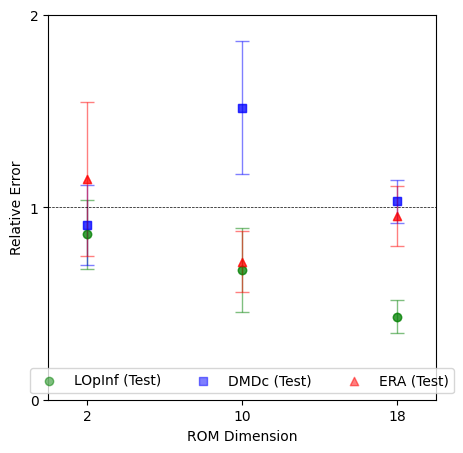

In [68]:
# Scatter plot of full body relative errors (average with std error bars) for each method
fig, ax = plt.subplots(figsize=(5, 5))
romDims = [2, 10, 18]
errors_lopinf_means_test = np.array([np.mean(lopinf_avgFullBody_rel_errors_test_2dim), np.mean(lopinf_avgFullBody_rel_errors_test_10dim), np.mean(lopinf_avgFullBody_rel_errors_test_18dim)])
errors_lopinf_stds_test = np.array([np.std(lopinf_avgFullBody_rel_errors_test_2dim), np.std(lopinf_avgFullBody_rel_errors_test_10dim), np.std(lopinf_avgFullBody_rel_errors_test_18dim)])
errors_dmdc_means_test = np.array([np.mean(dmdc_avgFullBody_rel_errors_test_2dim), np.mean(dmdc_avgFullBody_rel_errors_test_10dim), np.mean(dmdc_avgFullBody_rel_errors_test_18dim)])
errors_dmdc_stds_test = np.array([np.std(dmdc_avgFullBody_rel_errors_test_2dim), np.std(dmdc_avgFullBody_rel_errors_test_10dim), np.std(dmdc_avgFullBody_rel_errors_test_18dim)])
errors_era_means_test = np.array([np.mean(era_avgFullBody_rel_errors_test_2dim), np.mean(era_avgFullBody_rel_errors_test_10dim), np.mean(era_avgFullBody_rel_errors_test_18dim)])
errors_era_stds_test = np.array([np.std(era_avgFullBody_rel_errors_test_2dim), np.std(era_avgFullBody_rel_errors_test_10dim), np.std(era_avgFullBody_rel_errors_test_18dim)])

# Plot scatter plot of test errors with error bars
ax.scatter(romDims, errors_lopinf_means_test, label="LOpInf (Test)", color='green', marker='o', alpha=0.5)
ax.errorbar(romDims, errors_lopinf_means_test, yerr=errors_lopinf_stds_test, fmt='o', color='green', capsize=5, elinewidth=1, alpha=0.5)
ax.scatter(romDims, errors_dmdc_means_test, label="DMDc (Test)", color='blue', marker='s', alpha=0.5)
ax.errorbar(romDims, errors_dmdc_means_test, yerr=errors_dmdc_stds_test, fmt='s', color='blue', capsize=5, elinewidth=1, alpha=0.5)
ax.scatter(romDims, errors_era_means_test, label="ERA (Test)", color='red', marker='^', alpha=0.5)
ax.errorbar(romDims, errors_era_means_test, yerr=errors_era_stds_test, fmt='^', color='red', capsize=5, elinewidth=1, alpha=0.5)
ax.set_xlim([0, 20])
ax.set_ylim([0, 2])
ax.set_xlabel("ROM Dimension")
ax.set_ylabel("Relative Error")
ax.set_xticks(romDims)
ax.set_yticks([0, 1, 2])
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=0.5)
# Horizontal legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5,0.1), ncol=3, fontsize=10)
# Save as svg
plt.savefig(visualizationDir + "outputFullBodyRelativeErrors_RomDim_Test.svg", format='svg', dpi=1200)


## Bioinspired Trajectory Tracking

In [ ]:
# Trial Parameters
bioinspiredParamsDict = {"model":['dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','dmdc','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','lopinf','era','era','era','era','era','era','era','era','era','era','era','era', 'lopinf', 'lopinf', 'lopinf', 'lopinf', 'lopinf', 'lopinf', 'era', 'era', 'era', 'era', 'era', 'era', 'dmdc', 'dmdc', 'dmdc', 'dmdc', 'dmdc', 'dmdc'],
                         "amplitude":  [10,  10,  10,  10,  10,  10,  30,  30,  30,  30,  30,  30,  10,  10,  10,  10,  10,  10,  30,  30,  30,  30,  30,  30,  10,  10,  10,  10,  10,  10,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  30],
                         "freq":       [0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0],
                         "wavenumber": [0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5],
                         "alpha":      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5],
                         "trial_id":   [539, 540, 541, 542, 543, 544, 545, 546, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 653, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671],
                         }
# Form dataframe
bioinspiredParams = pd.DataFrame(bioinspiredParamsDict)
# add columns of zeros for absolute errors
bioinspiredParams['fullBody_abs_error_avg'] = 0.0
bioinspiredParams['fullBody_abs_error_std'] = 0.0
bioinspiredParams['fullBody_rel_error'] = 0.0
# add column for spatial errors that has type objected to allow for different length arrays
bioinspiredParams['spatial_abs_errors_avg'] = pd.Series(dtype='object')
bioinspiredParams['spatial_rel_errors'] = pd.Series(dtype='object')

trial_ids = bioinspiredParams['trial_id'].values[0]
timesteps = 1000
n = 1

In [70]:
trial_ids = bioinspiredParams['trial_id'].values
trial_ids[10]

551

In [71]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, int(trial_ids[10]), n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 2


### Compute Errors and Store

In [72]:
for trialInd in range(len(trial_ids)):
    # print(f"TrialInd: {trialInd}")
    trial_id = trial_ids[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, int(trial_id), n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # # Populate the spatial_abs_errors_avg array with the relative errors
    spatial_abs_errors_avg = np.zeros((20,1))
    for i in range(20):
        spatial_abs_errors_avg[19-i,0] = np.average(np.absolute(Y_fom[2*i+1,:]-y_refs[2*i+1,:]))
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body absolute errors 
    fullBody_abs_error_avg= np.average(np.absolute(Y_fom[1:41:2,:]-y_refs[1:41:2,:]))
    fullBody_abs_error_std= np.std(np.absolute(Y_fom[1:41:2,:]-y_refs[1:41:2,:]))
    fullBody_rel_error = np.linalg.norm(Y_fom[1:41:2,500:]-y_refs[1:41:2,500:], ord='fro')/np.linalg.norm(y_refs[1:41:2,500:], ord='fro')
    # insert into dataframe
    bioinspiredParams.at[trialInd, 'fullBody_abs_error_avg'] = fullBody_abs_error_avg
    bioinspiredParams.at[trialInd, 'fullBody_abs_error_std'] = fullBody_abs_error_std
    bioinspiredParams.at[trialInd, 'spatial_abs_errors_avg'] = spatial_abs_errors_avg
    bioinspiredParams.at[trialInd, 'fullBody_rel_error'] = fullBody_rel_error


In [73]:
# Compute do-nothing errors for each set of parameters and add to dataframe
wavenumbers = np.sort(bioinspiredParams['wavenumber'].unique())
amplitude=30
freqs = [0.5, 1.0]
alphas = [1.0, 3.5]
for freq in freqs:
    for alpha in alphas:
        for wavenumber in wavenumbers:
            # Grab a trial id with these parameters
            trial_id = bioinspiredParams[(bioinspiredParams['wavenumber']==wavenumber) & (bioinspiredParams['amplitude']==amplitude) & (bioinspiredParams['freq']==freq) & (bioinspiredParams['alpha']==alpha)]['trial_id'].values[0]
            # Read all timesteps of data from data
            conn = get_db_connection()
            data = fetch_trial_data(conn, int(trial_id), n, timesteps)
            conn.close()
            simulation_timesteps = np.array([row[0] for row in data])
            simulation_times = np.array([row[1] for row in data])
            input_data = np.array([row[2] for row in data]).T
            output_data = np.array([row[3] for row in data]).T
            y_refs = np.array([row[4] for row in data]).T
            x_hats = np.array([row[5] for row in data]).T
            # Read data to numpy arrays
            Y_fom = output_data
            U_fom = input_data
            Y0_fom = Y_fom[:,0]
            # Center Y_fom about neutral position
            Y_fom = Y_fom-Y0_fom[:,np.newaxis]
            # Compute average full body absolute errors 
            fullBody_abs_error_avg= np.average(np.absolute(y_refs[1:41:2,:]))
            fullBody_abs_error_std= np.std(np.absolute(y_refs[1:41:2,:]))
            # add to dataframe
            tempDict = {'model': 'do-nothing', 'amplitude': amplitude, 'freq': freq, 'wavenumber': wavenumber, 'alpha': alpha, 'trial_id': trial_id,
                        'fullBody_abs_error_avg': fullBody_abs_error_avg, 'fullBody_abs_error_std': fullBody_abs_error_std,
                        'spatial_abs_errors_avg': np.zeros((20,1))}
            bioinspiredParams = pd.concat([bioinspiredParams, pd.DataFrame([tempDict])], ignore_index=True)


In [74]:
bioinspiredParams

model  amplitude  freq  wavenumber  alpha  trial_id  \
0         dmdc         10   0.5         0.5    1.0       539   
1         dmdc         10   0.5         1.0    1.0       540   
2         dmdc         10   0.5         1.5    1.0       541   
3         dmdc         10   1.0         0.5    1.0       542   
4         dmdc         10   1.0         1.0    1.0       543   
..         ...        ...   ...         ...    ...       ...   
61  do-nothing         30   1.0         1.0    1.0       551   
62  do-nothing         30   1.0         1.5    1.0       552   
63  do-nothing         30   1.0         0.5    3.5       657   
64  do-nothing         30   1.0         1.0    3.5       658   
65  do-nothing         30   1.0         1.5    3.5       659   

    fullBody_abs_error_avg  fullBody_abs_error_std  fullBody_rel_error  \
0                 4.032811                2.558468            0.981152   
1                 4.049155                2.358274            0.975708   
2                 4.401628                2.820719            1.134735   
3                 3.932890                2.291500            0.970547   
4                 3.977243                2.289222            0.978568   
..                     ...                     ...                 ...   
61               12.106403                7.105586                 NaN   
62               12.085660                7.083912                 NaN   
63                5.530639                6.502163                 NaN   
64                5.523494                6.489664                 NaN   
65                5.511449                6.464921                 NaN   

                               spatial_abs_errors_avg spatial_rel_errors  
0   [[1.7896454753288806], [1.7220941929618567], [...                NaN  
1   [[3.0751252148356967], [3.041253681816874], [2...                NaN  
2   [[2.888084453516688], [2.425309252517709], [2....                NaN  
3   [[2.2545951713747634], [2.4129567626746575], [...                NaN  
4   [[2.420220742710276], [2.5205310089634247], [2...                NaN  
..                                                ...                ...  
61  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....                NaN  
62  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....                NaN  
63  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....                NaN  
64  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....                NaN  
65  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....                NaN  

[66 rows x 11 columns]

In [75]:
# Grab parameters for the trial from each method with the lowest fullBody_abs_error_avg
bioinspiredParams['fullBody_abs_error_avg'] = bioinspiredParams['fullBody_abs_error_avg'].astype(float)
lopinf_best_trial = bioinspiredParams[bioinspiredParams['model'] == 'lopinf'].nsmallest(1, 'fullBody_abs_error_avg')
dmdc_best_trial = bioinspiredParams[bioinspiredParams['model'] == 'dmdc'].nsmallest(1, 'fullBody_abs_error_avg')
era_best_trial = bioinspiredParams[bioinspiredParams['model'] == 'era'].nsmallest(1, 'fullBody_abs_error_avg')
print("LOpInf Best Trial Parameters:")
print(lopinf_best_trial)
print("DMDc Best Trial Parameters:")
print(dmdc_best_trial)
print("ERA Best Trial Parameters:")
print(era_best_trial)

# 562-Lopinf 549-DMDc 574-ERA

LOpInf Best Trial Parameters:
     model  amplitude  freq  wavenumber  alpha  trial_id  \
14  lopinf         10   0.5         1.5    1.0       555   

    fullBody_abs_error_avg  fullBody_abs_error_std  fullBody_rel_error  \
14                3.271464                 1.94357            0.794657   

                               spatial_abs_errors_avg spatial_rel_errors  
14  [[2.0421724831015955], [2.539662059914958], [2...                NaN  
DMDc Best Trial Parameters:
  model  amplitude  freq  wavenumber  alpha  trial_id  fullBody_abs_error_avg  \
3  dmdc         10   1.0         0.5    1.0       542                 3.93289   

   fullBody_abs_error_std  fullBody_rel_error  \
3                  2.2915            0.970547   

                              spatial_abs_errors_avg spatial_rel_errors  
3  [[2.2545951713747634], [2.4129567626746575], [...                NaN  
ERA Best Trial Parameters:
   model  amplitude  freq  wavenumber  alpha  trial_id  \
26   era         10   0.5  

(40, 1000)


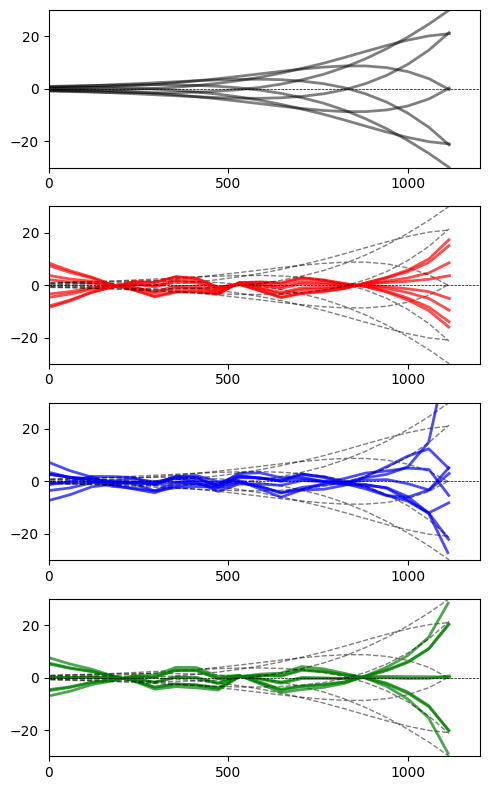

In [76]:
# Draw body shapes at n times over period of oscillation
amp = 30
freq = 0.5
wavenumber = 0.5
alpha = 3.5

numSnapshots = 8
startTimeStep = 700
timestepsBetweenSnapshots = int(1/freq*100/numSnapshots)

lopinfSnapshots = np.zeros((40, numSnapshots))
dmdcSnapshots = np.zeros((40, numSnapshots))
eraSnapshots = np.zeros((40, numSnapshots))

# Grab trial indices from trials that match parameters
lopinfTrialInd = int(bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amp) & (bioinspiredParams['freq'] == freq) & (bioinspiredParams['wavenumber'] == wavenumber) & (bioinspiredParams['alpha'] == alpha)]['trial_id'])
dmdcTrialInd = int(bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amp) & (bioinspiredParams['freq'] == freq) & (bioinspiredParams['wavenumber'] == wavenumber) & (bioinspiredParams['alpha'] == alpha)]['trial_id'])
eraTrialInd = int(bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amp) & (bioinspiredParams['freq'] == freq) & (bioinspiredParams['wavenumber'] == wavenumber) & (bioinspiredParams['alpha'] == alpha)]['trial_id'])


# Read in snapshots from database for ERA
conn = get_db_connection()
data = fetch_trial_data(conn, eraTrialInd, 1, timesteps)
conn.close()
simulation_timesteps = np.array([row[0] for row in data])
simulation_times = np.array([row[1] for row in data])
output_data_era = np.array([row[3] for row in data]).T
y_refs_era = np.array([row[4] for row in data]).T
y0_era = output_data_era[:,0]
y_refs_era[0:40:2] = y_refs_era[0:40:2] + y0_era[0:40:2, np.newaxis]  # Uncenter y_refs_era about neutral position
print(np.shape(output_data_era))
# Read in snapshots from database for DMDc
conn = get_db_connection()
data = fetch_trial_data(conn, dmdcTrialInd, 1, timesteps)
conn.close()
simulation_timesteps = np.array([row[0] for row in data])
simulation_times = np.array([row[1] for row in data])
output_data_dmdc = np.array([row[3] for row in data]).T
y_refs_dmdc = np.array([row[4] for row in data]).T
y0_dmdc = output_data_dmdc[:,0]
y_refs_dmdc = y_refs_dmdc + y0_dmdc[:, np.newaxis]  # Uncenter y_refs_dmdc about neutral position
# Read in snapshots from database for LOpInf
conn = get_db_connection()
data = fetch_trial_data(conn, lopinfTrialInd, 1, timesteps)
conn.close()
simulation_timesteps = np.array([row[0] for row in data])
simulation_times = np.array([row[1] for row in data])
output_data_lopinf = np.array([row[3] for row in data]).T
y_refs_lopinf = np.array([row[4] for row in data]).T
y0_lopinf = output_data_lopinf[:,0]
y_refs_lopinf = y_refs_lopinf + y0_lopinf[:, np.newaxis]  # Uncenter y_refs_lopinf about neutral position

# Plot numSnapshots centerlines for each method
fig, ax = plt.subplots(4, 1, figsize=(5, 8))
# Plot reference centerline
for i in range(numSnapshots):
    # Plot reference centerline
    refData_x = -np.flip(y_refs_era[0:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    refData_y = np.flip(y_refs_era[1:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    ax[0].plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=2)
    # Plot ERA centerline
    eraData_x = -np.flip(output_data_era[0:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    eraData_y = np.flip(output_data_era[1:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    ax[1].plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax[1].plot(eraData_x, eraData_y, color='red', alpha=0.7, linewidth=2)
    # Plot DMDc centerline
    dmdcData_x = -np.flip(output_data_dmdc[0:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    dmdcData_y = np.flip(output_data_dmdc[1:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    ax[2].plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax[2].plot(dmdcData_x, dmdcData_y, color='blue', alpha=0.7, linewidth=2)
    # Plot LOpInf centerline
    lopinfData_x = -np.flip(output_data_lopinf[0:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    lopinfData_y = np.flip(output_data_lopinf[1:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    ax[3].plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax[3].plot(lopinfData_x, lopinfData_y, color='green', alpha=0.7, linewidth=2)

# Set axis limits and labels
for i in range(4):
    ax[i].set_xlim([0, 1200])
    ax[i].set_ylim([-30, 30])
    # ax[i].set_aspect('equal', adjustable='box')
    ax[i].set_xticks([0, 500, 1000])
    ax[i].set_yticks([-20, 0, 20])
    ax[i].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax[i].axvline(x=0, color='black', linestyle='--', linewidth=0.5)

# Save the figure
plt.tight_layout()
plt.savefig(visualizationDir + "bioinspiredTrajTracking_Snapshots.svg", format='svg', dpi=1200)

In [77]:
# Set up arrays for plotting
wavenumbers = np.sort(bioinspiredParams['wavenumber'].unique())
amplitude=30
freqs = [0.5, 1.0]
alphas = [1.0, 3.5]
##### Do-Nothing #####
# Low Frequency, Low Alpha
fullBody_abs_error_avg_lowFreq_lowAlpha_doNothing = bioinspiredParams[(bioinspiredParams['model'] == 'do-nothing') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_lowFreq_lowAlpha_doNothing = bioinspiredParams[(bioinspiredParams['model'] == 'do-nothing') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values 
# Low Frequency, High Alpha
fullBody_abs_error_avg_lowFreq_highAlpha_doNothing = bioinspiredParams[(bioinspiredParams['model'] == 'do-nothing') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_lowFreq_highAlpha_doNothing = bioinspiredParams[(bioinspiredParams['model'] == 'do-nothing') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# High Frequency, Low Alpha
fullBody_abs_error_avg_highFreq_lowAlpha_doNothing = bioinspiredParams[(bioinspiredParams['model'] == 'do-nothing') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_highFreq_lowAlpha_doNothing = bioinspiredParams[(bioinspiredParams['model'] == 'do-nothing') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# High Frequency, High Alpha
fullBody_abs_error_avg_highFreq_highAlpha_doNothing = bioinspiredParams[(bioinspiredParams['model'] == 'do-nothing') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_highFreq_highAlpha_doNothing = bioinspiredParams[(bioinspiredParams['model'] == 'do-nothing') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
##### LOpInf #####
# Low Frequency, Low Alpha
fullBody_abs_error_avg_lowFreq_lowAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_lowFreq_lowAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# Low Frequency, High Alpha
fullBody_abs_error_avg_lowFreq_highAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_lowFreq_highAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# High Frequency, Low Alpha
fullBody_abs_error_avg_highFreq_lowAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_highFreq_lowAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# High Frequency, High Alpha
fullBody_abs_error_avg_highFreq_highAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_highFreq_highAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
##### DMDc #####
# Low Frequency, Low Alpha
fullBody_abs_error_avg_lowFreq_lowAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_lowFreq_lowAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# Low Frequency, High Alpha
fullBody_abs_error_avg_lowFreq_highAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_lowFreq_highAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# High Frequency, Low Alpha
fullBody_abs_error_avg_highFreq_lowAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_highFreq_lowAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# High Frequency, High Alpha
fullBody_abs_error_avg_highFreq_highAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_highFreq_highAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
##### ERA #####
# Low Frequency, Low Alpha
fullBody_abs_error_avg_lowFreq_lowAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_lowFreq_lowAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# Low Frequency, High Alpha
fullBody_abs_error_avg_lowFreq_highAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_lowFreq_highAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# High Frequency, Low Alpha
fullBody_abs_error_avg_highFreq_lowAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_highFreq_lowAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values
# High Frequency, High Alpha
fullBody_abs_error_avg_highFreq_highAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_avg'].values
fullBody_abs_error_std_highFreq_highAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_abs_error_std'].values


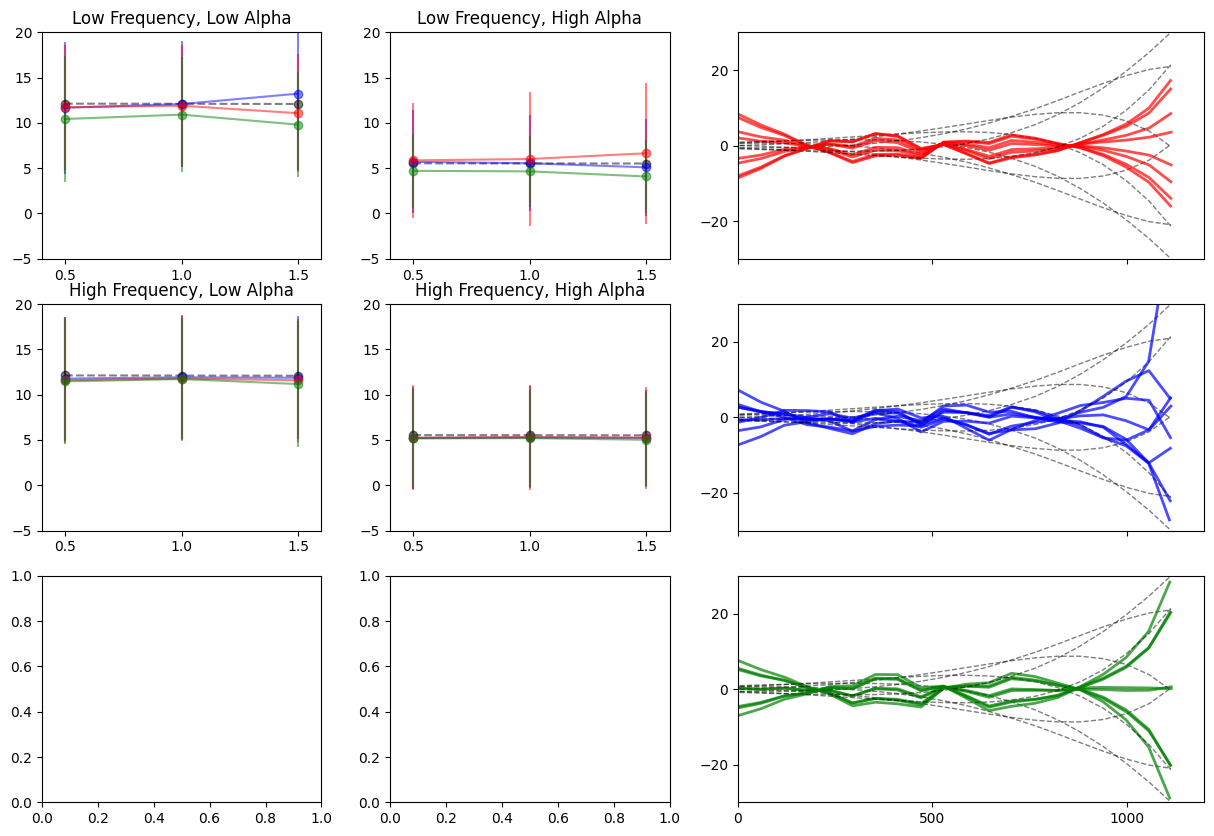

In [78]:
# Make combined figure for biosinspired trajectory tracking performance with average errors and shape snapshots
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(3, 3, width_ratios=[0.6,0.6, 1], height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0])  # Scatter plot of tracking errors for low frequency, low alpha
ax2 = fig.add_subplot(gs[1, 0])  # Scatter plot of tracking errors for high frequency, low alpha 
ax3 = fig.add_subplot(gs[2, 0])  # Nothing

ax4 = fig.add_subplot(gs[0, 1])  # Scatter plot of tracking errors for low frequency, high alpha
ax5 = fig.add_subplot(gs[1, 1])  # Scatter plot of tracking errors for high frequency, high alpha
ax6 = fig.add_subplot(gs[2, 1])  # Nothing

ax7 = fig.add_subplot(gs[0, 2])  # Shape snapshots ERA
ax8 = fig.add_subplot(gs[1, 2])  # Shape snapshots DMDc
ax9 = fig.add_subplot(gs[2, 2])  # Shape snapshots LOpInf

opacity = 0.5

# Plot low frequency, low alpha
ax1.errorbar(wavenumbers, fullBody_abs_error_avg_lowFreq_lowAlpha_doNothing, color='black', linestyle='--', marker='o', label='DMDc (Low Amp)', alpha=opacity)
ax1.errorbar(wavenumbers, fullBody_abs_error_avg_lowFreq_lowAlpha_dmdc, yerr=fullBody_abs_error_std_lowFreq_lowAlpha_dmdc, color='blue', linestyle='-', marker='o', label='DMDc (Low Amp)', alpha=opacity)
ax1.errorbar(wavenumbers, fullBody_abs_error_avg_lowFreq_lowAlpha_era, yerr=fullBody_abs_error_std_lowFreq_lowAlpha_era, color='red', linestyle='-', marker='o', label='ERA (Low Amp)', alpha=opacity)
ax1.errorbar(wavenumbers, fullBody_abs_error_avg_lowFreq_lowAlpha_lopinf, yerr=fullBody_abs_error_std_lowFreq_lowAlpha_lopinf, color='green', linestyle='-', marker='o', label='LOpInf (Low Amp)', alpha=opacity)
ax1.set_title("Low Frequency, Low Alpha")
# ax1.set_xlabel("Wavenumber")
# ax1.set_ylabel("Tracking Error")
# ax1.legend()
ax1.set_xticks([0.5, 1.0, 1.5])
ax1.set_xticklabels([0.5, 1.0, 1.5])
ax1.set_xlim([0.4, 1.6])
ax1.set_ylim([-5, 20])

# Plot high frequency, low alpha
ax2.errorbar(wavenumbers, fullBody_abs_error_avg_highFreq_lowAlpha_doNothing, color='black', linestyle='--', marker='o', label='DMDc (Low Amp)', alpha=opacity)
ax2.errorbar(wavenumbers, fullBody_abs_error_avg_highFreq_lowAlpha_dmdc, yerr=fullBody_abs_error_std_highFreq_lowAlpha_dmdc, color='blue', linestyle='-', marker='o', label='DMDc (High Amp)', alpha=opacity)
ax2.errorbar(wavenumbers, fullBody_abs_error_avg_highFreq_lowAlpha_era, yerr=fullBody_abs_error_std_highFreq_lowAlpha_era, color='red', linestyle='-', marker='o', label='ERA (High Amp)', alpha=opacity)
ax2.errorbar(wavenumbers, fullBody_abs_error_avg_highFreq_lowAlpha_lopinf, yerr=fullBody_abs_error_std_highFreq_lowAlpha_lopinf, color='green', linestyle='-', marker='o', label='LOpInf (High Amp)', alpha=opacity)
ax2.set_title("High Frequency, Low Alpha")
# ax2.set_xlabel("Wavenumber")
# ax2.set_ylabel("Tracking Error")
# ax2.legend()
ax2.set_xticks([0.5, 1.0, 1.5])
ax2.set_xticklabels([0.5, 1.0, 1.5])
ax2.set_xlim([0.4, 1.6])
ax2.set_ylim([-5, 20])
# Plot low frequency, high alpha
ax4.errorbar(wavenumbers, fullBody_abs_error_avg_lowFreq_highAlpha_doNothing, color='black', linestyle='--', marker='o', label='DMDc (Low Amp)', alpha=opacity)
ax4.errorbar(wavenumbers, fullBody_abs_error_avg_lowFreq_highAlpha_dmdc, yerr=fullBody_abs_error_std_lowFreq_highAlpha_dmdc, color='blue', linestyle='-', marker='o', label='DMDc (Low Amp)', alpha=opacity)
ax4.errorbar(wavenumbers, fullBody_abs_error_avg_lowFreq_highAlpha_era, yerr=fullBody_abs_error_std_lowFreq_highAlpha_era, color='red', linestyle='-', marker='o', label='ERA (Low Amp)', alpha=opacity)
ax4.errorbar(wavenumbers, fullBody_abs_error_avg_lowFreq_highAlpha_lopinf, yerr=fullBody_abs_error_std_lowFreq_highAlpha_lopinf, color='green', linestyle='-', marker='o', label='LOpInf (Low Amp)', alpha=opacity)
ax4.set_title("Low Frequency, High Alpha")
# ax4.set_xlabel("Wavenumber")
# ax4.set_ylabel("Tracking Error")
# ax4.legend()
ax4.set_xticks([0.5, 1.0, 1.5])
ax4.set_xticklabels([0.5, 1.0, 1.5])
ax4.set_xlim([0.4, 1.6])
ax4.set_ylim([-5, 20])
# Plot high frequency, high alpha
ax5.errorbar(wavenumbers, fullBody_abs_error_avg_highFreq_highAlpha_doNothing, color='black', linestyle='--', marker='o', label='DMDc (Low Amp)', alpha=opacity)
ax5.errorbar(wavenumbers, fullBody_abs_error_avg_highFreq_highAlpha_dmdc, yerr=fullBody_abs_error_std_highFreq_highAlpha_dmdc, color='blue', linestyle='-', marker='o', label='DMDc (High Amp)', alpha=opacity)
ax5.errorbar(wavenumbers, fullBody_abs_error_avg_highFreq_highAlpha_era, yerr=fullBody_abs_error_std_highFreq_highAlpha_era, color='red', linestyle='-', marker='o', label='ERA (High Amp)', alpha=opacity)
ax5.errorbar(wavenumbers, fullBody_abs_error_avg_highFreq_highAlpha_lopinf, yerr=fullBody_abs_error_std_highFreq_highAlpha_lopinf, color='green', linestyle='-', marker='o', label='LOpInf (High Amp)', alpha=opacity)
ax5.set_title("High Frequency, High Alpha")
# ax5.set_xlabel("Wavenumber")
# ax5.set_ylabel("Tracking Error")
# ax5.legend()
ax5.set_xticks([0.5, 1.0, 1.5])
ax5.set_xticklabels([0.5, 1.0, 1.5])
ax5.set_xlim([0.4, 1.6])
ax5.set_ylim([-5, 20])
# Plot snapshots for ERA, DMDc and LOpInf in right column
for i in range(numSnapshots):
    refData_x = -np.flip(y_refs_era[0:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    refData_y = np.flip(y_refs_era[1:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    # Plot ERA centerline
    eraData_x = -np.flip(output_data_era[0:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    eraData_y = np.flip(output_data_era[1:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    ax7.plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax7.plot(eraData_x, eraData_y, color='red', alpha=0.7, linewidth=2)
    # Plot DMDc centerline
    dmdcData_x = -np.flip(output_data_dmdc[0:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    dmdcData_y = np.flip(output_data_dmdc[1:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    ax8.plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax8.plot(dmdcData_x, dmdcData_y, color='blue', alpha=0.7, linewidth=2)
    # Plot LOpInf centerline
    lopinfData_x = -np.flip(output_data_lopinf[0:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    lopinfData_y = np.flip(output_data_lopinf[1:40:2, startTimeStep + i * timestepsBetweenSnapshots])
    ax9.plot(refData_x, refData_y, color='black', alpha=0.5, linewidth=1, linestyle='--')
    ax9.plot(lopinfData_x, lopinfData_y, color='green', alpha=0.7, linewidth=2)
# Set axis limits and labels
ax7.set_xlim([0, 1200])
ax7.set_ylim([-30, 30])
# ax7.set_aspect('equal', adjustable='box')
ax7.set_xticks([0, 500, 1000])
ax7.set_xticklabels([])
ax7.set_yticks([-20, 0, 20])
ax8.set_xlim([0, 1200])
ax8.set_ylim([-30, 30])
# ax8.set_aspect('equal', adjustable='box')
ax8.set_xticks([0, 500, 1000])
ax8.set_xticklabels([])
ax8.set_yticks([-20, 0, 20])
ax9.set_xlim([0, 1200])
ax9.set_ylim([-30, 30])
# ax9.set_aspect('equal', adjustable='box')
ax9.set_xticks([0, 500, 1000])
ax9.set_yticks([-20, 0, 20])


# Save the combined figure
# plt.tight_layout()
plt.savefig(visualizationDir + "bioinspiredTrajTracking_CombinedResults.svg", format='svg', dpi=1200)


In [79]:
# # Set up arrays for plotting with full body relative errors
wavenumbers = np.sort(bioinspiredParams['wavenumber'].unique())
amplitude=30
freqs = [0.5, 1.0]
alphas = [1.0, 3.5]
##### LOpInf #####
# Low Frequency, Low Alpha
fullBody_rel_error_lowFreq_lowAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# Low Frequency, High Alpha
fullBody_rel_error_lowFreq_highAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# High Frequency, Low Alpha
fullBody_rel_error_highFreq_lowAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# High Frequency, High Alpha
fullBody_rel_error_highFreq_highAlpha_lopinf = bioinspiredParams[(bioinspiredParams['model'] == 'lopinf') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_rel_error'].values
##### DMDc #####
# Low Frequency, Low Alpha
fullBody_rel_error_lowFreq_lowAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# Low Frequency, High Alpha
fullBody_rel_error_lowFreq_highAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# High Frequency, Low Alpha
fullBody_rel_error_highFreq_lowAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# High Frequency, High Alpha
fullBody_rel_error_highFreq_highAlpha_dmdc = bioinspiredParams[(bioinspiredParams['model'] == 'dmdc') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_rel_error'].values
##### ERA #####
# Low Frequency, Low Alpha
fullBody_rel_error_lowFreq_lowAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# Low Frequency, High Alpha
fullBody_rel_error_lowFreq_highAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 0.5) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# High Frequency, Low Alpha
fullBody_rel_error_highFreq_lowAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 1.0)].sort_values(by='wavenumber')['fullBody_rel_error'].values
# High Frequency, High Alpha
fullBody_rel_error_highFreq_highAlpha_era = bioinspiredParams[(bioinspiredParams['model'] == 'era') & (bioinspiredParams['amplitude'] == amplitude) & (bioinspiredParams['freq'] == 1.0) & (bioinspiredParams['alpha'] == 3.5)].sort_values(by='wavenumber')['fullBody_rel_error'].values


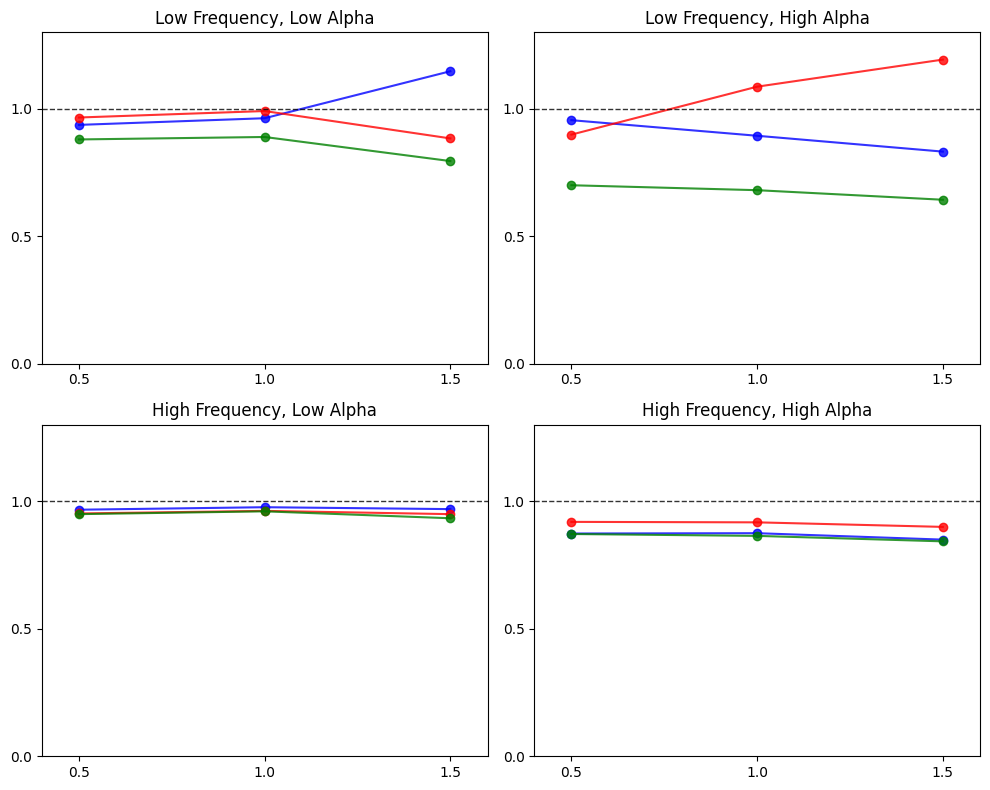

In [80]:
# Make combined figure for biosinspired trajectory tracking performance with relative errors 
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])  # Scatter plot of tracking errors for low frequency, low alpha
ax2 = fig.add_subplot(gs[1, 0])  # Scatter plot of tracking errors for high frequency, low alpha
ax3 = fig.add_subplot(gs[0, 1])  # Scatter plot of tracking errors for low frequency, high alpha
ax4 = fig.add_subplot(gs[1, 1])  # Scatter plot of tracking errors for high frequency, high alpha

opacity = 0.8
ylim_max= 1.3

# Plot low frequency, low alpha
ax1.plot(wavenumbers, fullBody_rel_error_lowFreq_lowAlpha_dmdc, color='blue', linestyle='-', marker='o', label='DMDc (Low Amp)', alpha=opacity)
ax1.plot(wavenumbers, fullBody_rel_error_lowFreq_lowAlpha_era, color='red', linestyle='-', marker='o', label='ERA (Low Amp)', alpha=opacity)
ax1.plot(wavenumbers, fullBody_rel_error_lowFreq_lowAlpha_lopinf, color='green', linestyle='-', marker='o', label='LOpInf (Low Amp)', alpha=opacity)
ax1.set_title("Low Frequency, Low Alpha")
# ax1.set_xlabel("Wavenumber")
# ax1.set_ylabel("Tracking Error")
# ax1.legend()
ax1.set_xticks([0.5, 1.0, 1.5])
ax1.set_xticklabels([0.5, 1.0, 1.5])
ax1.set_xlim([0.4, 1.6])
ax1.set_ylim([0, ylim_max])
ax1.set_yticks([0, 0.5, 1.0])
# horizontal line at y=1 for reference
ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=opacity)

# Plot high frequency, low alpha
ax2.plot(wavenumbers, fullBody_rel_error_highFreq_lowAlpha_dmdc, color='blue', linestyle='-', marker='o', label='DMDc (High Amp)', alpha=opacity)
ax2.plot(wavenumbers, fullBody_rel_error_highFreq_lowAlpha_era, color='red', linestyle='-', marker='o', label='ERA (High Amp)', alpha=opacity)
ax2.plot(wavenumbers, fullBody_rel_error_highFreq_lowAlpha_lopinf, color='green', linestyle='-', marker='o', label='LOpInf (High Amp)', alpha=opacity)
ax2.set_title("High Frequency, Low Alpha")
# ax2.set_xlabel("Wavenumber")
# ax2.set_ylabel("Tracking Error")
# ax2.legend()
ax2.set_xticks([0.5, 1.0, 1.5])
ax2.set_xticklabels([0.5, 1.0, 1.5])
ax2.set_xlim([0.4, 1.6])
ax2.set_ylim([0, ylim_max])
ax2.set_yticks([0, 0.5, 1.0])
# horizontal line at y=1 for reference
ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=opacity)
# Plot low frequency, high alpha
ax3.plot(wavenumbers, fullBody_rel_error_lowFreq_highAlpha_dmdc, color='blue', linestyle='-', marker='o', label='DMDc (Low Amp)', alpha=opacity)
ax3.plot(wavenumbers, fullBody_rel_error_lowFreq_highAlpha_era, color='red', linestyle='-', marker='o', label='ERA (Low Amp)', alpha=opacity)
ax3.plot(wavenumbers, fullBody_rel_error_lowFreq_highAlpha_lopinf, color='green', linestyle='-', marker='o', label='LOpInf (Low Amp)', alpha=opacity)
ax3.set_title("Low Frequency, High Alpha")
# ax3.set_xlabel("Wavenumber")
# ax3.set_ylabel("Tracking Error")
# ax4.legend()
ax3.set_xticks([0.5, 1.0, 1.5])
ax3.set_xticklabels([0.5, 1.0, 1.5])
ax3.set_xlim([0.4, 1.6])
ax3.set_ylim([0, ylim_max])
ax3.set_yticks([0, 0.5, 1.0])
# horizontal line at y=1 for reference
ax3.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=opacity)
# Plot high frequency, high alpha
ax4.plot(wavenumbers, fullBody_rel_error_highFreq_highAlpha_dmdc, color='blue', linestyle='-', marker='o', label='DMDc (High Amp)', alpha=opacity)
ax4.plot(wavenumbers, fullBody_rel_error_highFreq_highAlpha_era, color='red', linestyle='-', marker='o', label='ERA (High Amp)', alpha=opacity)
ax4.plot(wavenumbers, fullBody_rel_error_highFreq_highAlpha_lopinf, color='green', linestyle='-', marker='o', label='LOpInf (High Amp)', alpha=opacity)
ax4.set_title("High Frequency, High Alpha")
# ax4.set_xlabel("Wavenumber")
# ax4.set_ylabel("Tracking Error")
# ax5.legend()
ax4.set_xticks([0.5, 1.0, 1.5])
ax4.set_xticklabels([0.5, 1.0, 1.5])
ax4.set_xlim([0.4, 1.6])
ax4.set_ylim([0, ylim_max])
ax4.set_yticks([0, 0.5, 1.0])
# horizontal line at y=1 for reference
ax4.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=opacity)

# Save the combined figure
plt.tight_layout()
plt.savefig(visualizationDir + "bioinspiredTrajTracking_RelativeErrors_2x2.svg", format='svg', dpi=1200)


# Tracking Trajectories from Physical Experiments

In [90]:
physicalExpParams = {"model":     ["lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "lopinf", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "dmdc", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era", "era" ],
                    "trial_id":   [586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 597, 598, 599, 600, 601, 602, 603, 604, 605, 607, 608, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 627, 628, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 646, 647, 648, 649, 650, 651],
                    "amplitudes": ["30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10", "30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10", "30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10","30_30_30", "10_30_50", "20_50_20","50_30_10"],
                    "wavenumber": [1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5]
                    }


# Form dataframe 
physicalExpParams = pd.DataFrame(physicalExpParams)
# add columns of zeros for absolute errors
physicalExpParams['fullBody_abs_error_avg'] = 0.0
physicalExpParams['fullBody_abs_error_std'] = 0.0
# add column for spatial errors that has type objected to allow for different length arrays
physicalExpParams['spatial_abs_errors_avg'] = pd.Series(dtype='object')
# physicalExpParams['spatial_rel_errors'] = 0

trial_ids = physicalExpParams['trial_id'].values[0]
timesteps = 1000
n = 1
trial_ids = physicalExpParams['trial_id'].values
trial_ids[10]

597

In [91]:
# Read a single timestep of data from the database to get dimensions of stuff correct
conn = get_db_connection()
data = fetch_trial_data(conn, int(trial_ids[10]), n, 1)
conn.close()
timestep, simulation_time, input_data, output_data, y_ref, x_hat = data[0]
outputDim = np.size(output_data)
inputDim = np.size(input_data)
x_hatDim = np.size(x_hat)
print(f"OutputDim: {outputDim}, InputDim: {inputDim}, x_hatDim: {x_hatDim}")

OutputDim: 40, InputDim: 6, x_hatDim: 18


## Compute errors and store

In [92]:
for trialInd in range(len(trial_ids)):
    # print(f"TrialInd: {trialInd}")
    trial_id = trial_ids[trialInd]
    # Read all timesteps of data from data
    conn = get_db_connection()
    data = fetch_trial_data(conn, int(trial_id), n, timesteps)
    conn.close()
    simulation_timesteps = np.array([row[0] for row in data])
    simulation_times = np.array([row[1] for row in data])
    input_data = np.array([row[2] for row in data]).T
    output_data = np.array([row[3] for row in data]).T
    y_refs = np.array([row[4] for row in data]).T
    x_hats = np.array([row[5] for row in data]).T
    # Read data to numpy arrays
    Y_fom = output_data
    U_fom = input_data
    Y0_fom = Y_fom[:,0]
    # Center Y_fom about neutral position
    Y_fom = Y_fom-Y0_fom[:,np.newaxis]

    # # Populate the spatial_abs_errors_avg array with the relative errors
    spatial_abs_errors_avg = np.zeros((20,1))
    spatial_rms_error_doNothing = np.zeros((20,1))
    for i in range(20):
        spatial_abs_errors_avg[19-i,0] = np.sqrt(np.mean((Y_fom[2*i+1,500:]-y_refs[2*i+1,500:])**2)) #np.linalg.norm(Y_fom[2*i+1,500:]-y_refs[2*i+1,500:])/np.linalg.norm(y_refs[2*i+1,500:]) #
        spatial_rms_error_doNothing[19-i,0] = np.sqrt(np.mean((y_refs[2*i+1,500:])**2))
    # print("Relative Errors: ", rel_errors_avg_test)
    # Compute average full body absolute errors 
    fullBody_abs_error_avg= np.linalg.norm(Y_fom[1:37:2,500:]-y_refs[1:37:2,500:], ord='fro')/np.linalg.norm(y_refs[1:37:2,500:], ord='fro')
    # insert into dataframe
    physicalExpParams.at[trialInd, 'fullBody_abs_error_avg'] = fullBody_abs_error_avg
    physicalExpParams.at[trialInd, 'fullBody_abs_error_std'] = 0
    physicalExpParams.at[trialInd, 'spatial_abs_errors_avg'] = spatial_abs_errors_avg


In [93]:
physicalExpParams

model  trial_id amplitudes  wavenumber  fullBody_abs_error_avg  \
0   lopinf       586   30_30_30        1.50                0.912890   
1   lopinf       587   10_30_50        1.50                0.905242   
2   lopinf       588   20_50_20        1.50                0.966790   
3   lopinf       589   50_30_10        1.50                0.887814   
4   lopinf       590   30_30_30        1.00                0.936788   
5   lopinf       591   10_30_50        1.00                0.837972   
6   lopinf       592   20_50_20        1.00                0.918723   
7   lopinf       593   50_30_10        1.00                0.885693   
8   lopinf       594   30_30_30        0.75                0.902231   
9   lopinf       595   10_30_50        0.75                0.835594   
10  lopinf       597   20_50_20        0.75                0.912056   
11  lopinf       598   50_30_10        0.75                0.886052   
12  lopinf       599   30_30_30        0.60                0.894092   
13  lopinf       600   10_30_50        0.60                0.873279   
14  lopinf       601   20_50_20        0.60                0.887032   
15  lopinf       602   50_30_10        0.60                0.891480   
16  lopinf       603   30_30_30        0.50                0.887537   
17  lopinf       604   10_30_50        0.50                0.873486   
18  lopinf       605   20_50_20        0.50                0.892568   
19  lopinf       607   50_30_10        0.50                0.894564   
20    dmdc       608   30_30_30        1.50                1.042253   
21    dmdc       610   10_30_50        1.50                1.002516   
22    dmdc       611   20_50_20        1.50                1.006812   
23    dmdc       612   50_30_10        1.50                1.044934   
24    dmdc       613   30_30_30        1.00                0.994562   
25    dmdc       614   10_30_50        1.00                0.976032   
26    dmdc       615   20_50_20        1.00                0.996531   
27    dmdc       616   50_30_10        1.00                1.036796   
28    dmdc       617   30_30_30        0.75                1.023218   
29    dmdc       618   10_30_50        0.75                1.041457   
30    dmdc       619   20_50_20        0.75                1.012066   
31    dmdc       620   50_30_10        0.75                1.021588   
32    dmdc       621   30_30_30        0.60                1.052057   
33    dmdc       622   10_30_50        0.60                1.012839   
34    dmdc       623   20_50_20        0.60                1.051119   
35    dmdc       624   50_30_10        0.60                1.031017   
36    dmdc       625   30_30_30        0.50                1.040078   
37    dmdc       627   10_30_50        0.50                0.991499   
38    dmdc       628   20_50_20        0.50                0.995729   
39    dmdc       630   50_30_10        0.50                1.023562   
40     era       631   30_30_30        1.50                0.973533   
41     era       632   10_30_50        1.50                0.985997   
42     era       633   20_50_20        1.50                0.976425   
43     era       634   50_30_10        1.50                0.957758   
44     era       635   30_30_30        1.00                0.975698   
45     era       636   10_30_50        1.00                0.934789   
46     era       637   20_50_20        1.00                0.973284   
47     era       638   50_30_10        1.00                0.947515   
48     era       639   30_30_30        0.75                0.956941   
49     era       640   10_30_50        0.75                0.939584   
50     era       641   20_50_20        0.75                0.958642   
51     era       642   50_30_10        0.75                0.946582   
52     era       643   30_30_30        0.60                0.952893   
53     era       644   10_30_50        0.60                0.945801   
54     era       646   20_50_20        0.60                0.948659   
55     era       647   50_30_

In [94]:
# Initialize array for error heatmap plotting
wavenumbers = np.flip(np.sort(physicalExpParams['wavenumber'].unique()))
amplitudes = np.flip(["10_30_50", "20_50_20", "30_30_30", "50_30_10"])
models = ["lopinf", "dmdc", "era"]
numWavenumbers = len(wavenumbers)
numAmplitudes = len(amplitudes)
numModels = len(models)
errorHeatmapData = np.zeros((numWavenumbers, numAmplitudes, numModels))
# Populate errorHeatmapData array
for modelInd in range(numModels):
    model = models[modelInd]
    for ampInd in range(numAmplitudes):
        amplitude = amplitudes[ampInd]
        for waveInd in range(numWavenumbers):
            wavenumber = wavenumbers[waveInd]
            error = physicalExpParams[(physicalExpParams['model'] == model) & (physicalExpParams['amplitudes'] == amplitude) & (physicalExpParams['wavenumber'] == wavenumber)]['fullBody_abs_error_avg'].values[0]
            errorHeatmapData[waveInd, ampInd, modelInd] = error

In [95]:
# Print pages of heatmaps for each model
for modelInd in range(numModels):
    print(f"model: {models[modelInd]}")
    print(errorHeatmapData[:,:,modelInd])

model: lopinf
[[0.88781413 0.91289028 0.96679041 0.90524227]
 [0.88569313 0.93678767 0.9187226  0.83797208]
 [0.88605185 0.90223124 0.91205609 0.83559429]
 [0.89148026 0.89409174 0.88703195 0.87327909]
 [0.89456414 0.88753747 0.8925684  0.87348578]]
model: dmdc
[[1.0449338  1.04225259 1.00681199 1.00251609]
 [1.03679587 0.99456186 0.99653068 0.97603151]
 [1.02158762 1.02321819 1.01206643 1.04145736]
 [1.03101743 1.05205739 1.05111851 1.01283914]
 [1.02356182 1.04007823 0.99572859 0.99149914]]
model: era
[[0.95775774 0.97353331 0.97642522 0.98599699]
 [0.94751479 0.97569838 0.97328359 0.93478927]
 [0.94658241 0.95694084 0.95864208 0.93958411]
 [0.95059187 0.9528926  0.94865873 0.94580065]
 [0.95004226 0.94850054 0.94984531 0.94455191]]


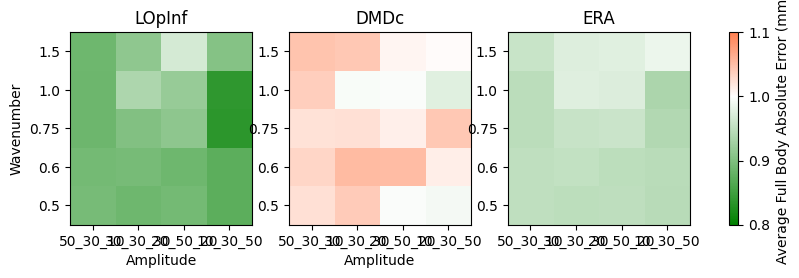

In [96]:
from matplotlib.colors import LinearSegmentedColormap

# define custom colormap: 0->blue, 1->white, 1.1->red
custom_cmap = LinearSegmentedColormap.from_list('custom_red_blue', [(0, 'green'), (0.2/0.3, 'white'), (1.0, 'coral')])

# Figure of 3 stacked heatmaps for physical experiments
fig, ax = plt.subplots(1, 3, figsize=(10, 2.5))
cmap = custom_cmap

# LOpInf Heatmap
im0 = ax[0].imshow(errorHeatmapData[:, :, 0], aspect='auto', cmap=cmap, vmin=0.8, vmax=1.1)
ax[0].set_title('LOpInf')
ax[0].set_xlabel('Amplitude')
ax[0].set_ylabel('Wavenumber')
ax[0].set_xticks(np.arange(len(amplitudes)))
ax[0].set_xticklabels(amplitudes)
ax[0].set_yticks(np.arange(len(wavenumbers)))
ax[0].set_yticklabels(wavenumbers)

# DMDc Heatmap
im1 = ax[1].imshow(errorHeatmapData[:, :, 1], aspect='auto', cmap=cmap, vmin=0.8, vmax=1.1)
ax[1].set_title('DMDc')
ax[1].set_xlabel('Amplitude')
ax[1].set_xticks(np.arange(len(amplitudes)))
ax[1].set_xticklabels(amplitudes)
ax[1].set_yticks(np.arange(len(wavenumbers)))
ax[1].set_yticklabels(wavenumbers)

# ERA Heatmap
im2 = ax[2].imshow(errorHeatmapData[:, :, 2], aspect='auto', cmap=cmap, vmin=0.8, vmax=1.1)
ax[2].set_title('ERA')
ax[2].set_xticks(np.arange(len(amplitudes)))
ax[2].set_xticklabels(amplitudes)
ax[2].set_yticks(np.arange(len(wavenumbers)))
ax[2].set_yticklabels(wavenumbers)

# Add colorbar
cbar = fig.colorbar(im0, ax=ax.ravel().tolist(), shrink=1)
cbar.set_label('Average Full Body Absolute Error (mm)')

plt.savefig(visualizationDir + "physicalExpTrajTracking_Heatmaps.svg", format='svg', dpi=1200)

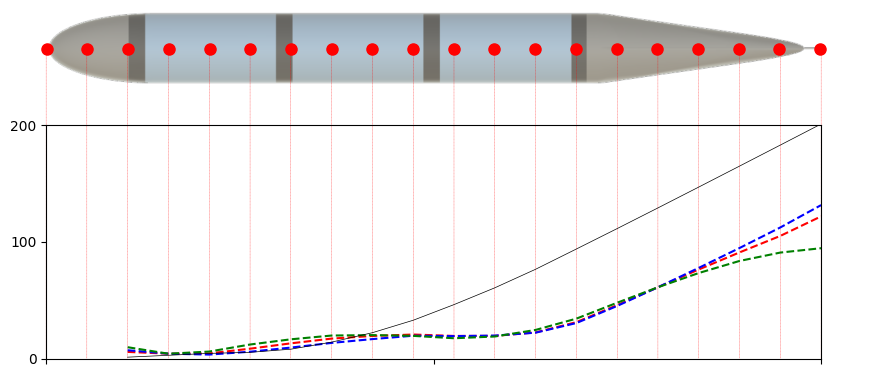

In [99]:
# Plot spatial errors for all three models on a single set of experimental params
amp = "10_30_50"
wavenumber = 1.0
# Era spatial errors
spatial_errors_era = physicalExpParams[(physicalExpParams['model'] == 'era') & (physicalExpParams['amplitudes'] == amp) & (physicalExpParams['wavenumber'] == wavenumber)]['spatial_abs_errors_avg'].values[0]
# DMDc spatial errors
spatial_errors_dmdc = physicalExpParams[(physicalExpParams['model'] == 'dmdc') & (physicalExpParams['amplitudes'] == amp) & (physicalExpParams['wavenumber'] == wavenumber)]['spatial_abs_errors_avg'].values[0]
# LOpInf spatial errors
spatial_errors_lopinf = physicalExpParams[(physicalExpParams['model'] == 'lopinf') & (physicalExpParams['amplitudes'] == amp) & (physicalExpParams['wavenumber'] == wavenumber)]['spatial_abs_errors_avg'].values[0]

# Plot Test Errors for Equal and Tail-Focused Weights
# Make bottom subplot twice as tall as top subplot using height_ratios
fig, ax = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [1, 2]})

# Import svg of fish with dots into top subplot
img = Image.open(visualizationDir + "ShadedFish_Top.png")
ax[0].axis('off')  # Remove boundaries on image

# Crop 20 pixels from either side
width, height = img.size
img_cropped = img.crop((-10, 0, width, height))

# Convert to numpy array and display image
ax[0].imshow(np.array(img_cropped))
# Draw 20 equally spaced red dots across center x-axis of image
num_dots = 20
x_positions = np.linspace(10, width + 10, num_dots)
y_position = height // 2
for x in x_positions:
    ax[0].plot(x, y_position, 'ro', markersize=8)

# Plot spatial error curves on the bottom subplot
ax[1].plot(range(2,20), spatial_errors_era[2:20], label="ERA", color='red', linestyle='--')
ax[1].plot(range(2,20), spatial_errors_dmdc[2:20], label="DMDc", color='blue', linestyle='--')
ax[1].plot(range(2,20), spatial_errors_lopinf[2:20], label="LOpInf", color='green', linestyle='--')
ax[1].plot(range(2,20), spatial_rms_error_doNothing[2:20], label="No Control", color='black', linestyle='-',linewidth=0.5)
ax[1].set_xticks([0, 9.5, 19])
ax[1].set_xticklabels([])
ax[1].set_xlim([0, 19])
# ax[1].set_ylim([0, 2])
# ax[1].set_yticks([0, 1, 2])
# Draw horizontal dotted line at y=1.0
# ax[1].axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax[1].set_ylim([0, 200])
ax[1].set_yticks([0, 100, 200])


# Adjust top subplot position if needed
ax[0].set_position([0.119, 0.6, 0.819, 0.26])

# Draw connection patches over the bottom subplot
x_fractions = np.linspace(0, 1, 20)
for x in x_fractions:
    con = ConnectionPatch(xyA=(x, 1.3), xyB=(x, 0), coordsA="axes fraction", coordsB="axes fraction",
                          axesA=ax[1], axesB=ax[1], color="red", linestyle='--', linewidth=0.2)
    ax[1].add_artist(con)

# Save the figure as svg
plt.savefig(visualizationDir + f"physTraj_outputTrackingErrors_Spatial_Experiment{amp}_{wavenumber}.svg", format='svg', dpi=1200)

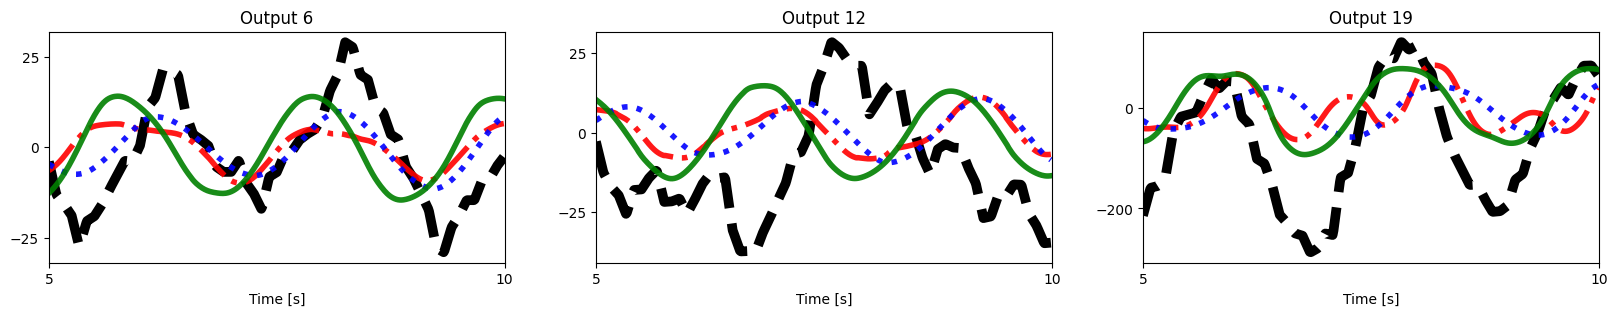

In [98]:
# Output indices to plot
output_indices = [27, 15, 1] # Descdending order of output indices so tail is on the right
# Define the trial to plot
trial_id_lopinf = physicalExpParams[(physicalExpParams['model'] == 'lopinf') & (physicalExpParams['amplitudes'] == amp) & (physicalExpParams['wavenumber'] == wavenumber)]['trial_id'].values[0]
trial_id_dmdc = physicalExpParams[(physicalExpParams['model'] == 'dmdc') & (physicalExpParams['amplitudes'] == amp) & (physicalExpParams['wavenumber'] == wavenumber)]['trial_id'].values[0]
trial_id_era = physicalExpParams[(physicalExpParams['model'] == 'era') & (physicalExpParams['amplitudes'] == amp) & (physicalExpParams['wavenumber'] == wavenumber)]['trial_id'].values[0]

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
# Read in ERA data
    
conn = get_db_connection()
data = fetch_trial_data(conn, int(trial_id_era), n, 1000)
conn.close()
simulation_timesteps_era = np.array([row[0] for row in data])
simulation_times_era = np.array([row[1] for row in data])
input_data_era = np.array([row[2] for row in data]).T
output_data_era = np.array([row[3] for row in data]).T
y_refs_era = np.array([row[4] for row in data]).T
x_hats_era = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_era = output_data_era
U_fom_era = input_data_era
Y0_fom_era = Y_fom_era[:,0]
# Center Y_fom about neutral position
Y_fom_era = Y_fom_era-Y0_fom_era[:,np.newaxis]
# Read in DMDc data
conn = get_db_connection()
data = fetch_trial_data(conn, int(trial_id_dmdc), n, 1000)
conn.close()
simulation_timesteps_dmdc = np.array([row[0] for row in data])
simulation_times_dmdc = np.array([row[1] for row in data])
input_data_dmdc = np.array([row[2] for row in data]).T
output_data_dmdc = np.array([row[3] for row in data]).T
y_refs_dmdc = np.array([row[4] for row in data]).T
x_hats_dmdc = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_dmdc = output_data_dmdc
U_fom_dmdc = input_data_dmdc
Y0_fom_dmdc = Y_fom_dmdc[:,0]
# Center Y_fom about neutral position
Y_fom_dmdc = Y_fom_dmdc-Y0_fom_dmdc[:,np.newaxis]
# Read in LOpInf data
conn = get_db_connection()
data = fetch_trial_data(conn, int(trial_id_lopinf), n, 1000)
conn.close()
simulation_timesteps_lopinf = np.array([row[0] for row in data])
simulation_times_lopinf = np.array([row[1] for row in data])
input_data_lopinf = np.array([row[2] for row in data]).T
output_data_lopinf = np.array([row[3] for row in data]).T
y_refs_lopinf = np.array([row[4] for row in data]).T
x_hats_lopinf = np.array([row[5] for row in data]).T
# Read data to numpy arrays
Y_fom_lopinf = output_data_lopinf
U_fom_lopinf = input_data_lopinf
Y0_fom_lopinf = Y_fom_lopinf[:,0]
# Center Y_fom about neutral position
Y_fom_lopinf = Y_fom_lopinf-Y0_fom_lopinf[:,np.newaxis]


# Plot the references and outputs for each model type at the specified output indices
simulation_times = simulation_times_era  # All models have the same time vector  
for i, output_index in enumerate(output_indices):
    # Plot ERA
    ax[i].plot(simulation_times[500:], y_refs_era[output_index, 500:], label="Reference (ERA)", color='black', linestyle='--', linewidth=7)
    ax[i].plot(simulation_times[500:], Y_fom_era[output_index, 500:], label="Output (ERA)", color='red', linewidth=4, linestyle='-.', alpha=0.9)
    # Plot DMDc
    ax[i].plot(simulation_times[500:], Y_fom_dmdc[output_index, 500:], label="Output (DMDc)", color='blue', linewidth=4,linestyle=':' , alpha=0.9)
    # Plot LOpInf
    ax[i].plot(simulation_times[500:], Y_fom_lopinf[output_index, 500:], label="Output (LOpInf)", color='green', linewidth=4,linestyle='-', alpha=0.9)


    # Set titles and labels
    ax[i].set_title(f"Output {19-(output_index-1)//2}")
    ax[i].set_xlabel("Time [s]")
    # ax[i].set_ylabel("Output Value")
    ax[i].set_xlim([5, 10])
    ax[i].set_xticks([5, 10])
    # Set only 3 y-ticks but make them adaptive to the plot range based on reference
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(3))
    
    

# Save as svg
plt.savefig(visualizationDir + f"physTraj_outputTrajectories_Experiments_{amp}_{wavenumber}.svg", format='svg', dpi=1200)

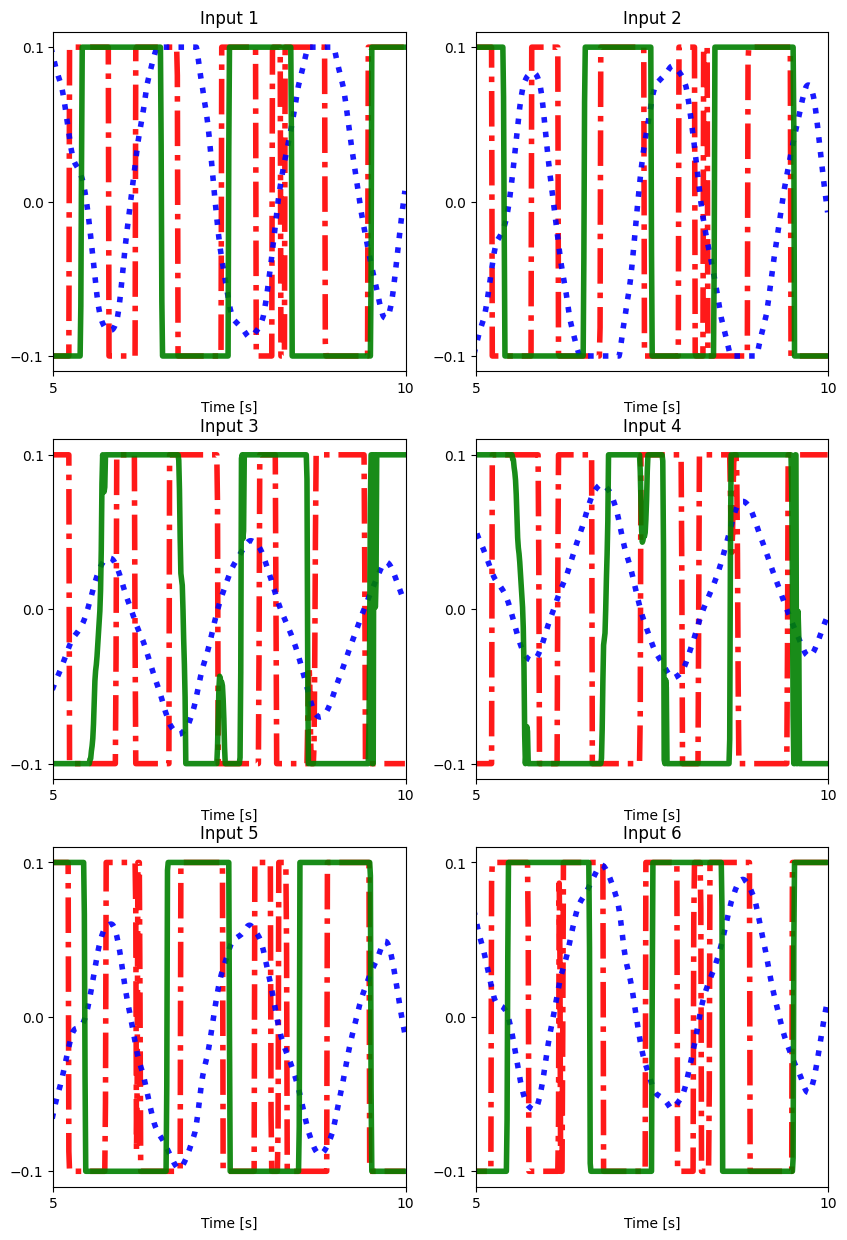

In [106]:
# Plot Inputs
# Plot all 6 inputs separately on subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
input_indices = [0, 1, 2, 3, 4, 5]
for i, input_index in enumerate(input_indices):
    row = i // 2
    col = i % 2
    axs[row, col].plot(simulation_times[:], U_fom_era[input_index, :], label="Input (ERA)", color='red', linewidth=4, linestyle='-.', alpha=0.9)
    axs[row, col].plot(simulation_times[:], U_fom_dmdc[input_index, :], label="Input (DMDc)", color='blue', linewidth=4, linestyle=':', alpha=0.9)
    axs[row, col].plot(simulation_times[:], U_fom_lopinf[input_index, :], label="Input (LOpInf)", color='green', linewidth=4, linestyle='-', alpha=0.9)
    axs[row, col].set_title(f"Input {input_index + 1}")
    axs[row, col].set_xlabel("Time [s]")
    # axs[row, col].set_ylabel("Input Value")
    axs[row, col].set_xlim([5, 10])
    axs[row, col].set_xticks([5, 10])
    # Set only 3 y-ticks but make them adaptive to the plot range based on reference
    axs[row, col].set_ylim([-0.11, 0.11])
    axs[row, col].set_yticks([-0.1, 0, 0.1])
# Save as svg
plt.savefig(visualizationDir + f"physTraj_inputTrajectories_Experiments_{amp}_{wavenumber}.svg", format='svg', dpi=1200)

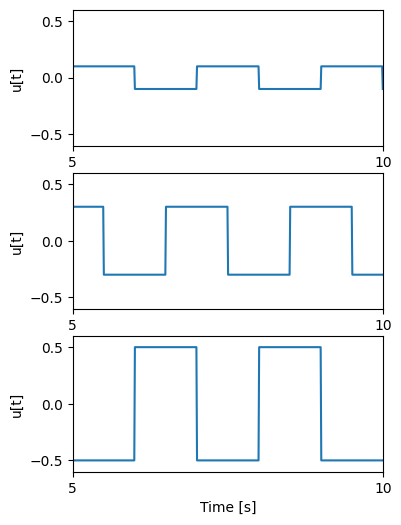

In [70]:
# Plot nominal reference inputs to actuators
ts = np.linspace(5, 10, 500)
freq_nominal = 0.5  # Hz
amp0_nominal = 0.1
amp2_nominal = 0.3
amp4_nominal = 0.5
rel_phases_nominal = np.pi/2  # 90 degrees
# generate square wave nominal inputs
U_nominal = np.zeros((3, len(ts)))
U_nominal[0, :] = -amp0_nominal * signal.square(2 * np.pi * freq_nominal * ts)
U_nominal[1, :] = -amp2_nominal * signal.square(2 * np.pi * freq_nominal * ts + rel_phases_nominal)
U_nominal[2, :] = -amp4_nominal * signal.square(2 * np.pi * freq_nominal * ts + 2 * rel_phases_nominal)

# Plot nominal inputs
fig, axs = plt.subplots(3, 1, figsize=(4, 6))
axs[0].plot(ts, U_nominal[0, :], label='Actuator 0')
axs[1].plot(ts, U_nominal[1, :], label='Actuator 2')
axs[2].plot(ts, U_nominal[2, :], label='Actuator 4')
for i in range(3):
    # axs[i].set_title(f"Nominal Input to Actuator {i*2}")
    axs[i].set_ylabel("u[t]")
    axs[i].set_xlim([5, 10])
    axs[i].set_xticks([5, 10])
    axs[i].set_ylim([-0.6, 0.6])
    axs[i].set_yticks([-0.5, 0, 0.5])
axs[2].set_xlabel("Time [s]")
# Save as svg
plt.savefig(visualizationDir + f"physTraj_nominalInputTrajectories_Experiments.svg", format='svg', dpi=1200)
    